In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [56]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

print("未识别出足够的关键数值列进行异常值检测")
numeric_cols = sheet_df.select_dtypes(include=[np.number]).columns

# 读取并分析两个核心数据工作表（出口数据）
# 1. FAS Value 工作表（贸易价值数据）
file_path = 'C:\\Users\\Pig\\Documents\\APMCM programming\\DataWeb-Query-Export-P3.xlsx'
fas_df = pd.read_excel(file_path, sheet_name='FAS Value')
# 2. First Unit of Quantity 工作表（贸易数量数据）
quantity_df = pd.read_excel(file_path, sheet_name='First Unit of Quantity')

print("="*80)
print("核心数据工作表概览")
print("="*80)
print(f"1. FAS Value 工作表（贸易价值）:")
print(f"   数据规模: {fas_df.shape[0]} 行 × {fas_df.shape[1]} 列")
print(f"2. First Unit of Quantity 工作表（贸易数量）:")
print(f"   数据规模: {quantity_df.shape[0]} 行 × {quantity_df.shape[1]} 列")

# 检查两个表的结构一致性
print(f"\n3. 表结构一致性检查:")
print(f"   FAS Value 列名: {list(fas_df.columns)}")
print(f"   Quantity 列名: {list(quantity_df.columns)}")
print(f"   列名是否完全一致: {list(fas_df.columns) == list(quantity_df.columns)}")

# 详细分析 FAS Value 表（核心贸易价值数据）
print("\n" + "="*80)
print("FAS Value 工作表详细分析（核心贸易价值数据）")
print("="*80)

# 1. 数据类型转换和基本清洗
print("1. 数据类型转换和缺失值处理:")
# 转换数值列
fas_df['Year'] = pd.to_numeric(fas_df['Year'], errors='coerce')
fas_df['Month'] = pd.to_numeric(fas_df['Month'], errors='coerce')
fas_df['HTS Number'] = pd.to_numeric(fas_df['HTS Number'], errors='coerce')
fas_df['FAS Value'] = pd.to_numeric(fas_df['FAS Value'], errors='coerce')

# 处理缺失值
missing_summary = pd.DataFrame({
    '缺失数量': fas_df.isnull().sum(),
    '缺失比例(%)': (fas_df.isnull().sum() / len(fas_df) * 100).round(2)
}).sort_values('缺失数量', ascending=False)

print("缺失值统计:")
print(missing_summary)

# 删除关键列（Year, Month, HTS Number, FAS Value, Country）有缺失的行
key_cols = ['Year', 'Month', 'HTS Number', 'FAS Value', 'Country']
initial_rows = len(fas_df)
fas_clean = fas_df.dropna(subset=key_cols).copy()
removed_rows = initial_rows - len(fas_clean)
print(f"\n删除关键列缺失的行:")
print(f"  原始数据行数: {initial_rows}")
print(f"  清洗后行数: {len(fas_clean)}")
print(f"  删除行数: {removed_rows} ({removed_rows/initial_rows*100:.2f}%)")

# 2. 时间范围分析（改为月度粒度）
print(f"\n2. 时间范围分析（月度粒度）:")
fas_clean['Year'] = fas_clean['Year'].astype(int)
fas_clean['Month'] = fas_clean['Month'].astype(int)
# 创建日期列（按月份）
fas_clean['Date'] = pd.to_datetime(fas_clean['Year'].astype(str) + '-' + fas_clean['Month'].astype(str) + '-01')
# 创建年月标签列（用于分组统计）
fas_clean['YearMonth'] = fas_clean['Date'].dt.strftime('%Y-%m')

# 基础时间信息
min_ym = fas_clean['YearMonth'].min()
max_ym = fas_clean['YearMonth'].max()
total_months = len(fas_clean['YearMonth'].unique())
print(f"  时间跨度: {min_ym} 至 {max_ym}")
print(f"  覆盖总月数: {total_months} 个月")

# 年度分布（辅助参考）
print(f"\n  年度分布（辅助参考）:")
year_counts = fas_clean['Year'].value_counts().sort_index()
for year, count in year_counts.items():
    print(f"    {year}年: {count} 条记录 ({count/len(fas_clean)*100:.1f}%)")

# 月度记录数分布（前15个月份）
print(f"\n  月度记录数分布（前15个月份）:")
monthly_counts = fas_clean['YearMonth'].value_counts().sort_index().head(15)
for ym, count in monthly_counts.items():
    print(f"    {ym}: {count} 条记录 ({count/len(fas_clean)*100:.1f}%)")

# 月度完整性检查
full_monthly = pd.date_range(
    start=fas_clean['Date'].min(), 
    end=fas_clean['Date'].max(), 
    freq='MS'
).strftime('%Y-%m')  # 理论应覆盖的所有月份
missing_months = set(full_monthly) - set(fas_clean['YearMonth'].unique())
print(f"\n  月度完整性:")
print(f"    理论应覆盖月数: {len(full_monthly)}")
print(f"    实际存在月数: {total_months}")
print(f"    缺失月数: {len(missing_months)}")
if len(missing_months) <= 10:
    print(f"    缺失的月份: {sorted(list(missing_months))}")

# 3. 国家/地区分析（重点关注美国对华贸易）
print(f"\n3. 国家/地区分析:")
# 标准化国家名称（统一大小写和常见名称）
fas_clean['Country_Clean'] = fas_clean['Country'].str.strip().str.upper()

# 识别中国和美国相关记录
china_variants = ['CHINA', 'PEOPLE\'S REPUBLIC OF CHINA', 'CHINA, MAINLAND']
us_variants = ['UNITED STATES', 'U.S.A', 'USA', 'UNITED STATES OF AMERICA']

fas_clean['Is_China'] = fas_clean['Country_Clean'].isin(china_variants)
fas_clean['Is_US'] = fas_clean['Country_Clean'].isin(us_variants)

# 统计主要国家的记录数量
top_countries = fas_clean['Country_Clean'].value_counts().head(10)
print(f"  记录数前10的国家:")
for country, count in top_countries.items():
    is_china = " (中国)" if country in china_variants else ""
    print(f"    {country}{is_china}: {count} 条记录")

# 统计中美相关记录
china_records = fas_clean['Is_China'].sum()
us_records = fas_clean['Is_US'].sum()
print(f"\n  中国相关记录: {china_records} 条 ({china_records/len(fas_clean)*100:.2f}%)")
print(f"  美国相关记录: {us_records} 条 ({us_records/len(fas_clean)*100:.2f}%)")

# 4. HTS编码分析（芯片分类）
print(f"\n4. HTS编码分析（芯片产品分类）:")
# 提取HTS编码的前4位（8541或8542）
fas_clean['HTS_4digit'] = (fas_clean['HTS Number'] // 100).astype(int)
hts_4digit_counts = fas_clean['HTS_4digit'].value_counts().sort_index()

print(f"  HTS前4位编码分布（对应芯片类型）:")
for hts, count in hts_4digit_counts.items():
    if hts == 8541:
        desc = "（分立器件 - Discrete Devices）"
    elif hts == 8542:
        desc = "（集成电路 - Integrated Circuits）"
    else:
        desc = "（其他）"
    print(f"    {hts}: {count} 条记录 {desc} ({count/len(fas_clean)*100:.2f}%)")

# 查看具体的HTS编码和产品描述
print(f"\n  主要HTS编码及产品描述:")
hts_desc = fas_clean.groupby(['HTS Number', 'Description']).size().reset_index(name='Count')
hts_desc = hts_desc.sort_values('Count', ascending=False).head(15)
for _, row in hts_desc.iterrows():
    print(f"    HTS {row['HTS Number']}: {row['Description']} (记录数: {row['Count']})")

# 5. 芯片高低端分类（基于HTS编码）
print(f"\n5. 芯片高低端分类（基于HTS编码）:")
# 根据半导体行业标准和HTS编码特点进行分类
def classify_chip_level(hts_number, description):
    """根据HTS编码和产品描述对芯片进行高低端分类"""
    hts_str = str(int(hts_number)) if pd.notna(hts_number) else ""
    desc_lower = description.lower() if pd.notna(description) else ""
    
    # 高端芯片特征
    high_end_keywords = ['advanced', 'high-speed', 'high-performance', 'fpga', 'cpu', 'gpu', 'microprocessor', 'ai', 'artificial intelligence', 'neural', '5g', '6g', 'quantum']
    high_end_hts = [854231, 854232, 854233, 854211, 854212, 854213, 854214]
    
    # 中端芯片特征
    mid_end_keywords = ['medium', 'standard', 'general', 'asic', 'soc', 'system on chip', 'memory', 'ddr', 'flash']
    mid_end_hts = [854239, 854221, 854229, 854240, 854250]
    
    # 低端芯片特征
    low_end_keywords = ['low', 'basic', 'simple', 'discrete', 'diode', 'transistor', 'rectifier']
    low_end_hts = [854110, 854121, 854129, 854130, 854140, 854150, 854160, 854190, 854260, 854270, 854280, 854290]
    
    if hts_number in high_end_hts or any(kw in desc_lower for kw in high_end_keywords):
        return 'High (H)'
    elif hts_number in mid_end_hts or any(kw in desc_lower for kw in mid_end_keywords):
        return 'Medium (M)'
    elif hts_number in low_end_hts or any(kw in desc_lower for kw in low_end_keywords):
        return 'Low (L)'
    else:
        return 'Unclassified (U)'

# 应用分类函数
fas_clean['Chip_Level'] = fas_clean.apply(lambda x: classify_chip_level(x['HTS Number'], x['Description']), axis=1)

# 统计分类结果
chip_level_counts = fas_clean['Chip_Level'].value_counts()
print("  芯片高低端分类结果:")
for level, count in chip_level_counts.items():
    print(f"    {level}: {count} 条记录 ({count/len(fas_clean)*100:.2f}%)")

# 6. 美国对华芯片出口数据提取（月度粒度 X_k,t）
print(f"\n6. 美国对华芯片出口数据提取（月度粒度 X_k,t）:")
# 论文定义：X_k,t = 美国对中国出口的k型芯片（t为月份）
us_to_cn_df = fas_clean[(fas_clean['Is_China'] == True)].copy()

print(f"  美国对华芯片出口记录: {len(us_to_cn_df)} 条")
print(f"  按芯片级别分布（整体）:")
us_to_cn_level = us_to_cn_df['Chip_Level'].value_counts()
for level, count in us_to_cn_level.items():
    value_sum = us_to_cn_df[us_to_cn_df['Chip_Level'] == level]['FAS Value'].sum()
    print(f"    {level}: {count} 条记录, 总价值: ${value_sum:,.0f}")

# 按「月份+芯片级别」汇总（核心指标 X_k,t）
print(f"\n  按「月份+芯片级别」汇总（核心指标 X_k,t）:")
us_to_cn_monthly = us_to_cn_df.groupby(['YearMonth', 'Chip_Level']).agg({
    'FAS Value': ['count', 'sum']  # 月度记录数、月度出口总价值
}).round(0)
us_to_cn_monthly.columns = ['月度记录数', '月度出口价值($)']
us_to_cn_monthly.reset_index(inplace=True)
print(us_to_cn_monthly.head(20))

# 月度总出口价值趋势（前15个月份）
print(f"\n  月度总出口价值趋势（前15个月份）:")
us_to_cn_total_monthly = us_to_cn_df.groupby('YearMonth')['FAS Value'].sum().sort_index().head(15)
for ym, total_value in us_to_cn_total_monthly.items():
    print(f"    {ym}: ${total_value:,.0f}")

# 7. 保存清洗后的数据（含月度汇总）
print(f"\n7. 数据保存:")
# 保存清洗后的完整数据
original_file = r'C:\Users\Pig\Documents\APMCM programming\DataWeb-Query-Export-P3.xlsx'
output_dir = os.path.dirname(original_file)

# 拼接输出文件路径（和原文件同目录）
output_file = os.path.join(output_dir, "Semiconductor_Trade_Data_Cleaned.xlsx")
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # 清洗后的完整数据
    fas_clean.to_excel(writer, sheet_name='Cleaned_FAS_Value', index=False)
    # 美国对华出口原始数据
    us_to_cn_df.to_excel(writer, sheet_name='US_to_China_Exports', index=False)
    # 美国对华出口月度汇总数据（核心X_k,t）
    us_to_cn_monthly.to_excel(writer, sheet_name='US_to_China_Monthly', index=False)
    # 数据字典
    data_dict = pd.DataFrame({
        '列名': fas_clean.columns.tolist(),
        '数据类型': [str(dtype) for dtype in fas_clean.dtypes],
        '说明': [
            '数据类型（FAS Value）',
            '年份',
            '月份',
            'HTS编码（8位）',
            '产品描述',
            '出口目的地国家',
            '数量描述',
            'FAS价值（美元）',
            '清洗后的国家名称（大写）',
            '是否为中国（True/False）',
            '是否为美国（True/False）',
            '日期（年月）',
            'HTS前4位编码',
            '芯片高低端级别（H/M/L/U）',
            '年月标签（YYYY-MM，用于月度分组）'
        ]
    })
    data_dict.to_excel(writer, sheet_name='Data_Dictionary', index=False)

print(f"  清洗后的数据已保存至: {output_file}")
print(f"  包含工作表: Cleaned_FAS_Value, US_to_China_Exports, US_to_China_Monthly, Data_Dictionary")

# 8. 数据预处理总结
print("\n" + "="*80)
print("数据预处理总结")
print("="*80)
print("✅ 已完成的预处理步骤:")
print("1. 数据读取和结构分析（识别3个工作表）")
print("2. 数据类型转换（数值列标准化）")
print("3. 缺失值处理（删除关键列缺失的记录）")
print("4. 时间维度处理（创建月度标签，分析月度完整性）")
print("5. 国家识别（标准化国家名称，标记中国记录）")
print("6. HTS编码分析（分类8541/8542芯片类型）")
print("7. 芯片高低端分类（基于HTS编码和产品描述）")
print("8. 美国对华出口数据提取（月度粒度X_k,t，含原始和汇总数据）")
print("9. 清洗后数据保存（含数据字典）")

print(f"\n📊 关键数据指标:")
print(f"• 原始数据规模: {initial_rows:,} 条记录")
print(f"• 清洗后数据规模: {len(fas_clean):,} 条记录")
print(f"• 时间跨度: {min_ym} 至 {max_ym}（{total_months} 个月）")
print(f"• 芯片级别分布: H({chip_level_counts.get('High (H)', 0):,}条), M({chip_level_counts.get('Medium (M)', 0):,}条), L({chip_level_counts.get('Low (L)', 0):,}条)")
print(f"• 美国对华出口记录: {len(us_to_cn_df):,} 条")

# ------------------------------------------------------------------------------
# 进口数据处理（改为月度粒度）
# ------------------------------------------------------------------------------

# 读取新上传的进口数据文件
import_file_path = 'C:\\Users\\Pig\\Documents\\APMCM programming\\DataWeb-Query-Import-P3.xlsx'

# 1. 查看文件工作表结构
xl_import = pd.ExcelFile(import_file_path)
print("\n" + "="*80)
print("进口数据文件工作表结构")
print("="*80)
print(f"工作表名称: {xl_import.sheet_names}")

# 2. 读取核心数据工作表（参考出口数据结构，重点关注价值和数量表）
core_sheets = ['General Duty Value', 'First Unit of Quantity']  # 进口数据常见工作表名
import_data = {}

for sheet_name in xl_import.sheet_names:
    print(f"\n正在读取工作表: {sheet_name}")
    df = pd.read_excel(import_file_path, sheet_name=sheet_name)
    import_data[sheet_name] = df
    print(f"  数据规模: {df.shape[0]} 行 × {df.shape[1]} 列")
    print(f"  列名: {list(df.columns)}")
    
    # 显示前3行数据预览
    print(f"  前3行数据预览:")
    print(df.head(3))
    
    # 检查是否包含关键列（年份、月份、HTS编码、国家、价值）
    key_cols_check = all(col in df.columns for col in ['Year', 'Month', 'HTS Number', 'Country'])
    print(f"  包含关键列(Year/Month/HTS/Country): {'是' if key_cols_check else '否'}")

# 3. 识别核心进口价值数据（优先选择包含关税相关的General Duty Value表）
if 'General Duty Value' in import_data:
    main_import_df = import_data['General Duty Value'].copy()
    value_col = 'General Duty Value'
elif 'Value' in import_data:
    main_import_df = import_data['Value'].copy()
    value_col = 'Value'
else:
    # 若未明确识别，选择数据量最大的数值表
    main_sheet = max(import_data.keys(), key=lambda x: import_data[x].shape[0] if import_data[x].select_dtypes(include=np.number).shape[1]>0 else 0)
    main_import_df = import_data[main_sheet].copy()
    value_col = [col for col in main_import_df.columns if 'Value' in col][0] if any('Value' in col for col in main_import_df.columns) else main_import_df.select_dtypes(include=np.number).columns[-1]

print(f"\n" + "="*60)
print(f"核心进口数据确定")
print("="*60)
print(f"  来源工作表: {main_sheet}")
print(f"  价值列名: {value_col}")
print(f"  数据规模: {main_import_df.shape[0]} 行 × {main_import_df.shape[1]} 列")

# 4. 数据预处理（快速清洗，满足后续分析需求）
print(f"\n" + "="*60)
print("进口数据快速预处理")
print("="*60)

# 4.1 数据类型转换
main_import_df['Year'] = pd.to_numeric(main_import_df['Year'], errors='coerce')
main_import_df['Month'] = pd.to_numeric(main_import_df['Month'], errors='coerce')
main_import_df['HTS Number'] = pd.to_numeric(main_import_df['HTS Number'], errors='coerce')
main_import_df[value_col] = pd.to_numeric(main_import_df[value_col], errors='coerce')

# 4.2 缺失值处理（删除关键列缺失的行）
key_cols = ['Year', 'Month', 'HTS Number', 'Country', value_col]
initial_rows = len(main_import_df)
main_import_df = main_import_df.dropna(subset=key_cols).copy()
removed_rows = initial_rows - len(main_import_df)
print(f"  缺失值处理:")
print(f"    原始行数: {initial_rows:,}")
print(f"    清洗后行数: {len(main_import_df):,}")
print(f"    删除缺失行: {removed_rows:,} ({removed_rows/initial_rows*100:.1f}%)")

# 4.3 变量构造（匹配出口数据格式，便于后续合并分析）
# 标准化国家名称
main_import_df['Country_Clean'] = main_import_df['Country'].str.strip().str.upper()

# 识别中国进口记录（匹配出口数据的中国识别规则）
china_variants = ['CHINA', 'PEOPLE\'S REPUBLIC OF CHINA', 'CHINA, MAINLAND']
main_import_df['Is_China'] = main_import_df['Country_Clean'].isin(china_variants)

# 构造HTS前4位编码（用于芯片类型分类）
main_import_df['HTS_4digit'] = (main_import_df['HTS Number'] // 100).astype(int)

# 构造日期列和月度标签（便于时间序列分析）
main_import_df['Year'] = main_import_df['Year'].astype(int)
main_import_df['Month'] = main_import_df['Month'].astype(int)
main_import_df['Date'] = pd.to_datetime(main_import_df['Year'].astype(str) + '-' + main_import_df['Month'].astype(str) + '-01')
main_import_df['YearMonth'] = main_import_df['Date'].dt.strftime('%Y-%m')  # 月度标签

# 4.4 芯片高低端分类（复用出口数据的分类规则）
def classify_chip_level(hts_number, description=None):
    """快速芯片分类函数"""
    hts = int(hts_number) if pd.notna(hts_number) else 0
    desc_lower = description.lower() if pd.notna(description) else ""
    
    # 高端芯片HTS编码
    high_end_hts = [854231, 854232, 854233, 854211, 854212, 854213, 854214]
    # 中端芯片HTS编码
    mid_end_hts = [854239, 854221, 854229, 854240, 854250]
    # 低端芯片HTS编码
    low_end_hts = [854110, 854121, 854129, 854130, 854140, 854150, 854160, 854190, 854260, 854270, 854280, 854290]
    
    if hts in high_end_hts or any(kw in desc_lower for kw in ['advanced', 'high-speed', 'cpu', 'gpu', 'ai']):
        return 'High (H)'
    elif hts in mid_end_hts or any(kw in desc_lower for kw in ['medium', 'asic', 'soc', 'memory']):
        return 'Medium (M)'
    elif hts in low_end_hts or any(kw in desc_lower for kw in ['low', 'diode', 'transistor', 'discrete']):
        return 'Low (L)'
    else:
        return 'Unclassified (U)'

# 应用芯片分类（若有产品描述则结合描述，否则仅用HTS编码）
description_col = 'Description' if 'Description' in main_import_df.columns else None
if description_col:
    main_import_df['Chip_Level'] = main_import_df.apply(lambda x: classify_chip_level(x['HTS Number'], x[description_col]), axis=1)
else:
    main_import_df['Chip_Level'] = main_import_df['HTS Number'].apply(classify_chip_level)

# 4.5 提取核心指标（M_k,t: 美国从中国进口的k型芯片，月度粒度）
us_from_cn_imports = main_import_df[main_import_df['Is_China'] == True].copy()
us_from_cn_imports.rename(columns={value_col: 'Import_Value'}, inplace=True)

print(f"\n" + "="*60)
print("核心进口指标提取结果（M_k,t: 美国从中国进口，月度粒度）")
print("="*60)
print(f"  总记录数: {len(us_from_cn_imports):,} 条")
print(f"  时间范围: {us_from_cn_imports['YearMonth'].min()} 至 {us_from_cn_imports['YearMonth'].max()}")
print(f"  覆盖总月数: {len(us_from_cn_imports['YearMonth'].unique())} 个月")

# 按芯片级别统计（整体）
import_level_stats = us_from_cn_imports.groupby('Chip_Level').agg({
    'Import_Value': ['count', 'sum'],
    'YearMonth': ['min', 'max']
}).round(0)
import_level_stats.columns = ['记录数', '总进口价值($)', '起始月份', '结束月份']
import_level_stats['总进口价值($)'] = import_level_stats['总进口价值($)'].astype(int)
print(f"\n  按芯片级别统计（整体）:")
print(import_level_stats)

# 按「月份+芯片级别」汇总（核心指标 M_k,t）
print(f"\n  按「月份+芯片级别」汇总（核心指标 M_k,t）:")
us_from_cn_monthly = us_from_cn_imports.groupby(['YearMonth', 'Chip_Level']).agg({
    'Import_Value': ['count', 'sum']  # 月度记录数、月度进口总价值
}).round(0)
us_from_cn_monthly.columns = ['月度记录数', '月度进口价值($)']
us_from_cn_monthly.reset_index(inplace=True)
print(us_from_cn_monthly.head(20))

# 月度总进口价值趋势（前15个月份）
print(f"\n  月度总进口价值趋势（前15个月份）:")
us_from_cn_total_monthly = us_from_cn_imports.groupby('YearMonth')['Import_Value'].sum().sort_index().head(15)
for ym, total_value in us_from_cn_total_monthly.items():
    print(f"    {ym}: ${total_value:,.0f}")

# 5. 与出口数据格式对齐（便于后续合并分析）
# 读取之前的出口清洗数据，确保字段一致性
export_cleaned_path = os.path.join(output_dir, 'Semiconductor_Trade_Data_Cleaned.xlsx')
try:
    export_cleaned_df = pd.read_excel(export_cleaned_path, sheet_name='US_to_China_Exports')
    print(f"\n" + "="*60)
    print("出口数据格式对齐检查（月度粒度）")
    print("="*60)
    print(f"  出口数据时间范围: {export_cleaned_df['YearMonth'].min()} 至 {export_cleaned_df['YearMonth'].max()}")
    print(f"  进口数据时间范围: {us_from_cn_imports['YearMonth'].min()} 至 {us_from_cn_imports['YearMonth'].max()}")
    
    # 统一关键字段名（包含月度字段）
    common_cols = ['Year', 'Month', 'Date', 'YearMonth', 'HTS Number', 'HTS_4digit', 'Chip_Level', 'Country_Clean', 'Is_China']
    us_from_cn_imports = us_from_cn_imports[common_cols + ['Import_Value']].copy()
    
    print(f"  字段对齐完成，统一包含: {common_cols + ['Import_Value']}")
except FileNotFoundError:
    print(f"\n  未找到历史出口清洗数据，按标准月度格式保留进口数据字段")

# 6. 保存预处理结果（便于后续直接使用）
output_dir_import = os.path.dirname(import_file_path)  # 获取原始文件所在目录
output_file_import = os.path.join(output_dir_import, 'Semiconductor_Import_Data_Preprocessed.xlsx')
os.makedirs(output_dir_import, exist_ok=True)
with pd.ExcelWriter(output_file_import, engine='openpyxl') as writer:
    # 清洗后的完整进口数据
    main_import_df.to_excel(writer, sheet_name='Cleaned_Import_Data', index=False)
    # 美国从中国进口的核心数据（原始记录）
    us_from_cn_imports.to_excel(writer, sheet_name='US_from_China_Imports', index=False)
    # 美国从中国进口月度汇总数据（核心M_k,t）
    us_from_cn_monthly.to_excel(writer, sheet_name='US_from_China_Monthly', index=False)
    # 数据说明
    data_info = pd.DataFrame({
        '字段名': list(us_from_cn_imports.columns) + ['备注'],
        '含义': [
            '年份', '月份', '日期（YYYY-MM-01）', '年月标签（YYYY-MM）', 'HTS编码（8位）',
            'HTS前4位编码', '芯片级别（H/M/L/U）', '标准化国家名称', '是否为中国（True/False）',
            '进口价值', '数据来源: DataWeb-Query-Import-P3.xlsx，月度粒度M_k,t'
        ]
    })
    data_info.to_excel(writer, sheet_name='Data_Info', index=False)

print(f"\n" + "="*60)
print("进口数据预处理完成")
print("="*60)
print(f"  预处理结果保存至: {output_file_import}")
print(f"  包含工作表:")
print(f"    1. Cleaned_Import_Data - 完整清洗后的进口数据")
print(f"    2. US_from_China_Imports - 美国从中国进口原始数据")
print(f"    3. US_from_China_Monthly - 美国从中国进口月度汇总数据（核心M_k,t）")
print(f"    4. Data_Info - 字段说明")
print(f"\n  后续可用的核心指标:")
print(f"    • M_k,t: 按「月份+芯片级别」汇总的美国从中国进口额")
print(f"    • 支持与出口数据合并，计算月度贸易平衡")
print(f"    • 可用于后续关税模型和安全指数计算")

未识别出足够的关键数值列进行异常值检测
核心数据工作表概览
1. FAS Value 工作表（贸易价值）:
   数据规模: 113137 行 × 8 列
2. First Unit of Quantity 工作表（贸易数量）:
   数据规模: 113136 行 × 9 列

3. 表结构一致性检查:
   FAS Value 列名: ['Data Type', 'Year', 'Month', 'HTS Number', 'Description', 'Country', 'Quantity Description', 'FAS Value']
   Quantity 列名: ['Data Type', 'Year', 'Month', 'HTS Number', 'Description', 'Country', 'Quantity Description', 'FIRST_UNIT_QUANTITY', 'Suppressed']
   列名是否完全一致: False

FAS Value 工作表详细分析（核心贸易价值数据）
1. 数据类型转换和缺失值处理:
缺失值统计:
                      缺失数量  缺失比例(%)
Year                     1      0.0
Month                    1      0.0
HTS Number               1      0.0
Description              1      0.0
Quantity Description     1      0.0
Country                  1      0.0
FAS Value                1      0.0
Data Type                0      0.0

删除关键列缺失的行:
  原始数据行数: 113137
  清洗后行数: 113136
  删除行数: 1 (0.00%)

2. 时间范围分析（月度粒度）:
  时间跨度: 2015-01 至 2025-08
  覆盖总月数: 128 个月

  年度分布（辅助参考）:
    2015年: 10237 条记录 (9.0%)
    2016年: 1

In [3]:
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']
plt.rcParams['axes.unicode_minus'] = False

# 读取Excel文件
file_path = 'C:\\Users\\Pig\\Documents\\APMCM programming\\DataWeb-Query-Export-P3.xlsx'
df = pd.read_excel(file_path)

# 1. 查看数据基本信息
print("="*60)
print("1. 数据基本信息")
print("="*60)
print(f"数据形状: {df.shape}")
print(f"列名: {list(df.columns)}")
print(f"\n数据类型:")
print(df.dtypes)

# 2. 查看前几行数据
print("\n" + "="*60)
print("2. 数据前10行")
print("="*60)
print(df.head(10))

# 3. 查看缺失值情况
print("\n" + "="*60)
print("3. 缺失值统计")
print("="*60)
missing_stats = pd.DataFrame({
    '缺失值数量': df.isnull().sum(),
    '缺失值比例(%)': (df.isnull().sum() / len(df) * 100).round(2)
})
print(missing_stats[missing_stats['缺失值数量'] > 0].sort_values('缺失值数量', ascending=False))
print(f"\n总缺失值比例: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100):.2f}%")

# 4. 查看数据的时间范围（如果有时间列）
print("\n" + "="*60)
print("4. 时间范围分析")
print("="*60)
time_columns = [col for col in df.columns if any(keyword in str(col).lower() for keyword in ['date', 'time', 'period', 'quarter', 'year'])]
if time_columns:
    for col in time_columns:
        print(f"\n{col}:")
        print(f"  数据类型: {df[col].dtype}")
        print(f"  唯一值数量: {df[col].nunique()}")
        print(f"  最小值: {df[col].min()}")
        print(f"  最大值: {df[col].max()}")
        # 尝试转换为datetime格式查看
        try:
            df[col + '_datetime'] = pd.to_datetime(df[col])
            print(f"  转换为datetime后的范围: {df[col + '_datetime'].min()} 到 {df[col + '_datetime'].max()}")
        except:
            print(f"  无法转换为datetime格式")
else:
    print("未找到明显的时间相关列")

# 5. 查看关键数值列的统计信息（根据论文中的变量）
print("\n" + "="*60)
print("5. 关键数值变量统计分析")
print("="*60)
# 根据论文中的变量名称，识别可能的关键列
keyword_groups = {
    '出口相关(X)': ['export', 'x_', 'xus', 'usexport', 'xworld'],
    '进口相关(M)': ['import', 'm_', 'mus', 'usimport'],
    '关税相关(Tariff)': ['tariff', 'duty', 'sec301', 'generalduty'],
    '份额相关(Share)': ['share', 's_', 'skt', 'cnshare'],
    '生产相关(Y)': ['production', 'y_', 'manufacturing', 'intensity'],
    '安全相关(S)': ['security', 's_t', 'selfsufficiency', 'dependence'],
    '效率相关(E)': ['efficiency', 'e_t', 'revenue'],
    '控制变量(EC)': ['ec_', 'control', 'dummy']
}

key_numeric_columns = []
for group_name, keywords in keyword_groups.items():
    group_columns = []
    for col in df.columns:
        col_lower = str(col).lower()
        if any(keyword in col_lower for keyword in keywords):
            group_columns.append(col)
    
    if group_columns:
        print(f"\n{group_name}: {group_columns}")
        # 显示这些列的基本统计信息
        numeric_cols = df[group_columns].select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            print(f"  数值列统计:")
            print(df[numeric_cols].describe().round(4))
            key_numeric_columns.extend(numeric_cols.tolist())

# 6. 查看芯片类型分组（H/M/L）
print("\n" + "="*60)
print("6. 芯片类型分组分析")
print("="*60)
chip_type_columns = [col for col in df.columns if any(c in str(col).lower() for c in ['high', 'medium', 'low', 'h_', 'm_', 'l_', 'h,', 'm,', 'l,'])]
if chip_type_columns:
    print(f"识别出的芯片类型相关列: {chip_type_columns}")
    for col in chip_type_columns:
        print(f"\n{col}:")
        print(f"  唯一值: {df[col].unique()}")
        print(f"  值计数:")
        print(df[col].value_counts(dropna=False))
else:
    print("未明确识别出芯片类型（H/M/L）相关列，可能需要从HS/HTS编码中提取")

# 7. 查看HS/HTS编码列（如果有）
print("\n" + "="*60)
print("7. HS/HTS编码分析")
print("="*60)
hs_columns = [col for col in df.columns if any(code in str(col).lower() for code in ['hs', 'hts', '8541', '8542'])]
if hs_columns:
    print(f"识别出的HS/HTS编码相关列: {hs_columns}")
    for col in hs_columns:
        print(f"\n{col}:")
        print(f"  数据类型: {df[col].dtype}")
        print(f"  唯一值数量: {df[col].nunique()}")
        print(f"  前10个唯一值: {df[col].unique()[:10]}")
else:
    print("未找到HS/HTS编码相关列")

# 8. 数据质量检查（异常值初步检测）
print("\n" + "="*60)
print("8. 异常值初步检测（基于3σ原则）")
print("="*60)
if key_numeric_columns:
    outliers_summary = []
    for col in key_numeric_columns:
        data = df[col].dropna()
        if len(data) > 0:
            mean_val = data.mean()
            std_val = data.std()
            lower_bound = mean_val - 3 * std_val
            upper_bound = mean_val + 3 * std_val
            outliers = data[(data < lower_bound) | (data > upper_bound)]
            outlier_ratio = len(outliers) / len(data) * 100
            outliers_summary.append({
                '列名': col,
                '数据量': len(data),
                '均值': mean_val.round(4),
                '标准差': std_val.round(4),
                '下界': lower_bound.round(4),
                '上界': upper_bound.round(4),
                '异常值数量': len(outliers),
                '异常值比例(%)': outlier_ratio.round(2)
            })
    
    outliers_df = pd.DataFrame(outliers_summary)
    print(outliers_df[outliers_df['异常值数量'] > 0].sort_values('异常值比例(%)', ascending=False))
    if len(outliers_df[outliers_df['异常值数量'] > 0]) == 0:
        print("在3σ原则下，未检测到明显异常值")
else:
    print("未识别出足够的关键数值列进行异常值检测")

print("\n" + "="*60)
print("数据预处理初步分析完成")
print("="*60)

1. 数据基本信息
数据形状: (32, 2)
列名: ['Download Date', datetime.datetime(2025, 11, 22, 10, 35, 28, 432000)]

数据类型:
Download Date                 object
2025-11-22 10:35:28.432000    object
dtype: object

2. 数据前10行
                                  Download Date  \
0  Step 1: Trade Flow and Classification System   
1                                    Trade Flow   
2                         Classification System   
3                        Step 2: Data and Years   
4                                Data To Report   
5                                   Data Format   
6                                   Select Type   
7                                         Years   
8                         Timeframe Aggregation   
9                             Step 3: Countries   

                          2025-11-22 10:35:28.432000  
0                                                NaN  
1                                      Total Exports  
2                                          HTS Items  
3            

In [4]:
# 重新仔细查看完整数据内容，理解数据结构
print("="*80)
print("完整数据内容查看")
print("="*80)
for i, row in df.iterrows():
    print(f"行{i:2d}: | {str(row.iloc[0]):<50} | {str(row.iloc[1]):<50} |")

# 检查是否有多个工作表
print("\n" + "="*80)
print("检查Excel文件是否有多个工作表")
print("="*80)
xl_file = pd.ExcelFile(file_path)
print(f"工作表名称: {xl_file.sheet_names}")

# 如果有多个工作表，读取所有工作表
all_sheets = {}
for sheet_name in xl_file.sheet_names:
    print(f"\n正在读取工作表: {sheet_name}")
    sheet_df = pd.read_excel(file_path, sheet_name=sheet_name)
    all_sheets[sheet_name] = sheet_df
    print(f"  工作表 {sheet_name} 形状: {sheet_df.shape}")
    print(f"  列名: {list(sheet_df.columns)}")
    
    # 显示前5行数据
    print(f"  前5行数据:")
    print(sheet_df.head())
    
    # 检查是否包含实际的数值数据
    numeric_cols = sheet_df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(f"  数值列: {list(numeric_cols)}")
        print(f"  数值列统计摘要:")
        print(sheet_df[numeric_cols].describe().round(2))

# 重点分析可能包含实际数据的工作表
print("\n" + "="*80)
print("重点分析包含数值数据的工作表")
print("="*80)
data_sheets = {}
for sheet_name, sheet_df in all_sheets.items():
    numeric_cols = sheet_df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0 and sheet_df.shape[0] > 5:  # 筛选有足够数据量的工作表
        data_sheets[sheet_name] = sheet_df
        print(f"\n工作表: {sheet_name}")
        print(f"  数据形状: {sheet_df.shape}")
        print(f"  数值列数量: {len(numeric_cols)}")
        print(f"  数值列: {list(numeric_cols)}")
        
        # 检查是否有时间相关信息
        time_cols = [col for col in sheet_df.columns if any(kw in str(col).lower() for kw in ['date', 'time', 'year', 'month', 'quarter'])]
        if time_cols:
            print(f"  时间相关列: {time_cols}")
            for t_col in time_cols:
                print(f"    {t_col}: 唯一值数量 = {sheet_df[t_col].nunique()}, 示例 = {sheet_df[t_col].unique()[:5]}")
        
        # 检查是否有国家/地区相关信息
        country_cols = [col for col in sheet_df.columns if any(kw in str(col).lower() for kw in ['country', 'cn', 'china', 'us', 'united states'])]
        if country_cols:
            print(f"  国家相关列: {country_cols}")
            for c_col in country_cols:
                print(f"    {c_col}: 唯一值 = {sheet_df[c_col].unique()}")
        
        # 检查是否有产品/芯片类型相关信息
        product_cols = [col for col in sheet_df.columns if any(kw in str(col).lower() for kw in ['product', 'chip', 'hs', 'hts', '8541', '8542', 'high', 'medium', 'low'])]
        if product_cols:
            print(f"  产品/芯片相关列: {product_cols}")
            for p_col in product_cols:
                print(f"    {p_col}: 唯一值 = {sheet_df[p_col].unique()[:10]}")

# 如果找到数据工作表，进行更详细的分析
if data_sheets:
    # 选择第一个数据工作表进行详细分析
    main_sheet_name = list(data_sheets.keys())[0]
    main_df = data_sheets[main_sheet_name]
    print(f"\n" + "="*80)
    print(f"详细分析主数据工作表: {main_sheet_name}")
    print(f"="*80)
    
    # 查看缺失值情况
    print(f"\n1. 缺失值统计:")
    missing_info = pd.DataFrame({
        '缺失数量': main_df.isnull().sum(),
        '缺失比例(%)': (main_df.isnull().sum() / len(main_df) * 100).round(2)
    }).sort_values('缺失数量', ascending=False)
    print(missing_info[missing_info['缺失数量'] > 0])
    
    # 查看数据类型分布
    print(f"\n2. 数据类型分布:")
    dtype_counts = main_df.dtypes.value_counts()
    print(dtype_counts)
    
    # 查看数值列的详细统计
    print(f"\n3. 数值列详细统计:")
    numeric_cols = main_df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        print(f"\n{col}:")
        col_data = main_df[col].dropna()
        print(f"  统计摘要:")
        print(f"    样本数: {len(col_data)}, 均值: {col_data.mean():.4f}, 中位数: {col_data.median():.4f}")
        print(f"    标准差: {col_data.std():.4f}, 最小值: {col_data.min():.4f}, 最大值: {col_data.max():.4f}")
        print(f"    25分位: {col_data.quantile(0.25):.4f}, 75分位: {col_data.quantile(0.75):.4f}")
        
        # 检查是否有0值或负值（对于贸易数据通常应为非负）
        zero_count = (col_data == 0).sum()
        negative_count = (col_data < 0).sum()
        print(f"  数据质量:")
        print(f"    零值数量: {zero_count} ({zero_count/len(col_data)*100:.2f}%)")
        print(f"    负值数量: {negative_count} ({negative_count/len(col_data)*100:.2f}%)")

else:
    print(f"\n" + "="*80)
    print("未找到包含足够数值数据的工作表")
    print("="*80)
    # 再次检查所有工作表的详细内容
    for sheet_name, sheet_df in all_sheets.items():
        print(f"\n工作表 {sheet_name} 完整内容:")
        print("-" * 50)
        for i, row in sheet_df.iterrows():
            print(f"行{i:2d}: {[str(cell) for cell in row.values]}")
            if i > 20:  # 只显示前20行避免输出过长
                print("... (后续行省略)")
                break

完整数据内容查看
行 0: | Step 1: Trade Flow and Classification System       | nan                                                |
行 1: | Trade Flow                                         | Total Exports                                      |
行 2: | Classification System                              | HTS Items                                          |
行 3: | Step 2: Data and Years                             | nan                                                |
行 4: | Data To Report                                     | FAS Value, First Unit of Quantity                  |
行 5: | Data Format                                        | 1                                                  |
行 6: | Select Type                                        | Full Years                                         |
行 7: | Years                                              | 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025 |
行 8: | Timeframe Aggregation                              | Monthly      

In [5]:
import os
# 读取并分析两个核心数据工作表
# 1. FAS Value 工作表（贸易价值数据）
fas_df = pd.read_excel(file_path, sheet_name='FAS Value')
# 2. First Unit of Quantity 工作表（贸易数量数据）
quantity_df = pd.read_excel(file_path, sheet_name='First Unit of Quantity')

print("="*80)
print("核心数据工作表概览")
print("="*80)
print(f"1. FAS Value 工作表（贸易价值）:")
print(f"   数据规模: {fas_df.shape[0]} 行 × {fas_df.shape[1]} 列")
print(f"2. First Unit of Quantity 工作表（贸易数量）:")
print(f"   数据规模: {quantity_df.shape[0]} 行 × {quantity_df.shape[1]} 列")

# 检查两个表的结构一致性
print(f"\n3. 表结构一致性检查:")
print(f"   FAS Value 列名: {list(fas_df.columns)}")
print(f"   Quantity 列名: {list(quantity_df.columns)}")
print(f"   列名是否完全一致: {list(fas_df.columns) == list(quantity_df.columns)}")

# 详细分析 FAS Value 表（核心贸易价值数据）
print("\n" + "="*80)
print("FAS Value 工作表详细分析（核心贸易价值数据）")
print("="*80)

# 1. 数据类型转换和基本清洗
print("1. 数据类型转换和缺失值处理:")
# 转换数值列
fas_df['Year'] = pd.to_numeric(fas_df['Year'], errors='coerce')
fas_df['Month'] = pd.to_numeric(fas_df['Month'], errors='coerce')
fas_df['HTS Number'] = pd.to_numeric(fas_df['HTS Number'], errors='coerce')
fas_df['FAS Value'] = pd.to_numeric(fas_df['FAS Value'], errors='coerce')

# 处理缺失值
missing_summary = pd.DataFrame({
    '缺失数量': fas_df.isnull().sum(),
    '缺失比例(%)': (fas_df.isnull().sum() / len(fas_df) * 100).round(2)
}).sort_values('缺失数量', ascending=False)

print("缺失值统计:")
print(missing_summary)

# 删除关键列（Year, Month, HTS Number, FAS Value, Country）有缺失的行
key_cols = ['Year', 'Month', 'HTS Number', 'FAS Value', 'Country']
initial_rows = len(fas_df)
fas_clean = fas_df.dropna(subset=key_cols).copy()
removed_rows = initial_rows - len(fas_clean)
print(f"\n删除关键列缺失的行:")
print(f"  原始数据行数: {initial_rows}")
print(f"  清洗后行数: {len(fas_clean)}")
print(f"  删除行数: {removed_rows} ({removed_rows/initial_rows*100:.2f}%)")

# 2. 时间范围分析
print(f"\n2. 时间范围分析:")
fas_clean['Year'] = fas_clean['Year'].astype(int)
fas_clean['Month'] = fas_clean['Month'].astype(int)
# 创建日期列（按月份）
fas_clean['Date'] = pd.to_datetime(fas_clean['Year'].astype(str) + '-' + fas_clean['Month'].astype(str) + '-01')

print(f"  时间跨度: {fas_clean['Year'].min()}年{fas_clean['Month'].min()}月 至 {fas_clean['Year'].max()}年{fas_clean['Month'].max()}月")
print(f"  年份分布:")
year_counts = fas_clean['Year'].value_counts().sort_index()
for year, count in year_counts.items():
    print(f"    {year}年: {count} 条记录 ({count/len(fas_clean)*100:.1f}%)")

# 3. 国家/地区分析（重点关注美国对华贸易）
print(f"\n3. 国家/地区分析:")
# 标准化国家名称（统一大小写和常见名称）
fas_clean['Country_Clean'] = fas_clean['Country'].str.strip().str.upper()

# 识别中国和美国相关记录
china_variants = ['CHINA', 'PEOPLE\'S REPUBLIC OF CHINA', 'CHINA, MAINLAND']
us_variants = ['UNITED STATES', 'U.S.A', 'USA', 'UNITED STATES OF AMERICA']

fas_clean['Is_China'] = fas_clean['Country_Clean'].isin(china_variants)
fas_clean['Is_US'] = fas_clean['Country_Clean'].isin(us_variants)

# 统计主要国家的记录数量
top_countries = fas_clean['Country_Clean'].value_counts().head(10)
print(f"  记录数前10的国家:")
for country, count in top_countries.items():
    is_china = " (中国)" if country in china_variants else ""
    print(f"    {country}{is_china}: {count} 条记录")

# 统计中美相关记录
china_records = fas_clean['Is_China'].sum()
us_records = fas_clean['Is_US'].sum()
print(f"\n  中国相关记录: {china_records} 条 ({china_records/len(fas_clean)*100:.2f}%)")
print(f"  美国相关记录: {us_records} 条 ({us_records/len(fas_clean)*100:.2f}%)")

# 4. HTS编码分析（芯片分类）
print(f"\n4. HTS编码分析（芯片产品分类）:")
# 提取HTS编码的前4位（8541或8542）
fas_clean['HTS_4digit'] = (fas_clean['HTS Number'] // 100).astype(int)
hts_4digit_counts = fas_clean['HTS_4digit'].value_counts().sort_index()

print(f"  HTS前4位编码分布（对应芯片类型）:")
for hts, count in hts_4digit_counts.items():
    if hts == 8541:
        desc = "（分立器件 - Discrete Devices）"
    elif hts == 8542:
        desc = "（集成电路 - Integrated Circuits）"
    else:
        desc = "（其他）"
    print(f"    {hts}: {count} 条记录 {desc} ({count/len(fas_clean)*100:.2f}%)")

# 查看具体的HTS编码和产品描述
print(f"\n  主要HTS编码及产品描述:")
hts_desc = fas_clean.groupby(['HTS Number', 'Description']).size().reset_index(name='Count')
hts_desc = hts_desc.sort_values('Count', ascending=False).head(15)
for _, row in hts_desc.iterrows():
    print(f"    HTS {row['HTS Number']}: {row['Description']} (记录数: {row['Count']})")

# 5. 芯片高低端分类（基于HTS编码）
print(f"\n5. 芯片高低端分类（基于HTS编码）:")
# 根据半导体行业标准和HTS编码特点进行分类
def classify_chip_level(hts_number, description):
    """根据HTS编码和产品描述对芯片进行高低端分类"""
    hts_str = str(int(hts_number)) if pd.notna(hts_number) else ""
    desc_lower = description.lower() if pd.notna(description) else ""
    
    # 高端芯片特征
    high_end_keywords = ['advanced', 'high-speed', 'high-performance', 'fpga', 'cpu', 'gpu', 'microprocessor', 'ai', 'artificial intelligence', 'neural', '5g', '6g', 'quantum']
    high_end_hts = [854231, 854232, 854233, 854211, 854212, 854213, 854214]
    
    # 中端芯片特征
    mid_end_keywords = ['medium', 'standard', 'general', 'asic', 'soc', 'system on chip', 'memory', 'ddr', 'flash']
    mid_end_hts = [854239, 854221, 854229, 854240, 854250]
    
    # 低端芯片特征
    low_end_keywords = ['low', 'basic', 'simple', 'discrete', 'diode', 'transistor', 'rectifier']
    low_end_hts = [854110, 854121, 854129, 854130, 854140, 854150, 854160, 854190, 854260, 854270, 854280, 854290]
    
    if hts_number in high_end_hts or any(kw in desc_lower for kw in high_end_keywords):
        return 'High (H)'
    elif hts_number in mid_end_hts or any(kw in desc_lower for kw in mid_end_keywords):
        return 'Medium (M)'
    elif hts_number in low_end_hts or any(kw in desc_lower for kw in low_end_keywords):
        return 'Low (L)'
    else:
        return 'Unclassified (U)'

# 应用分类函数
fas_clean['Chip_Level'] = fas_clean.apply(lambda x: classify_chip_level(x['HTS Number'], x['Description']), axis=1)

# 统计分类结果
chip_level_counts = fas_clean['Chip_Level'].value_counts()
print("  芯片高低端分类结果:")
for level, count in chip_level_counts.items():
    print(f"    {level}: {count} 条记录 ({count/len(fas_clean)*100:.2f}%)")

# 6. 美国对华芯片出口数据提取（根据论文定义）
print(f"\n6. 美国对华芯片出口数据提取:")
# 论文定义：X_k,t = 美国对中国出口的k型芯片
# 这里假设当前数据是美国的出口数据（根据Query Parameters中的Trade Flow=Total Exports）
us_to_cn_df = fas_clean[(fas_clean['Is_China'] == True)].copy()

print(f"  美国对华芯片出口记录: {len(us_to_cn_df)} 条")
print(f"  按芯片级别分布:")
us_to_cn_level = us_to_cn_df['Chip_Level'].value_counts()
for level, count in us_to_cn_level.items():
    value_sum = us_to_cn_df[us_to_cn_df['Chip_Level'] == level]['FAS Value'].sum()
    print(f"    {level}: {count} 条记录, 总价值: ${value_sum:,.0f}")

print(f"\n  按年份分布（美国对华出口）:")
us_to_cn_yearly = us_to_cn_df.groupby('Year').agg({
    'FAS Value': ['count', 'sum']
}).round(0)
us_to_cn_yearly.columns = ['记录数', '总出口价值($)']
print(us_to_cn_yearly)

# 7. 保存清洗后的数据
print(f"\n7. 数据保存:")
# 保存清洗后的完整数据
original_file = r'C:\Users\Pig\Documents\APMCM programming\DataWeb-Query-Export-P3.xlsx'
# 获取原始文件所在目录（无需手动输入）
output_dir = os.path.dirname(original_file)

# 拼接输出文件路径（和原文件同目录）
output_file = os.path.join(output_dir, "Semiconductor_Trade_Data_Cleaned.xlsx")
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # 清洗后的完整数据
    fas_clean.to_excel(writer, sheet_name='Cleaned_FAS_Value', index=False)
    # 美国对华出口数据
    us_to_cn_df.to_excel(writer, sheet_name='US_to_China_Exports', index=False)
    # 数据字典
    data_dict = pd.DataFrame({
        '列名': fas_clean.columns,
        '数据类型': [str(dtype) for dtype in fas_clean.dtypes],
        '说明': [
            '数据类型（FAS Value）',
            '年份',
            '月份',
            'HTS编码（8位）',
            '产品描述',
            '出口目的地国家',
            '数量描述',
            'FAS价值（美元）',
            '清洗后的国家名称（大写）',
            '是否为中国（True/False）',
            '是否为美国（True/False）',
            '日期（年月）',
            'HTS前4位编码',
            '芯片高低端级别（H/M/L/U）'
        ]
    })
    data_dict.to_excel(writer, sheet_name='Data_Dictionary', index=False)

print(f"  清洗后的数据已保存至: {output_file}")
print(f"  包含工作表: Cleaned_FAS_Value, US_to_China_Exports, Data_Dictionary")

# 8. 数据预处理总结
print("\n" + "="*80)
print("数据预处理总结")
print("="*80)
print("✅ 已完成的预处理步骤:")
print("1. 数据读取和结构分析（识别3个工作表）")
print("2. 数据类型转换（数值列标准化）")
print("3. 缺失值处理（删除关键列缺失的记录）")
print("4. 时间维度处理（创建日期列，分析时间跨度）")
print("5. 国家识别（标准化国家名称，标记中国记录）")
print("6. HTS编码分析（分类8541/8542芯片类型）")
print("7. 芯片高低端分类（基于HTS编码和产品描述）")
print("8. 美国对华出口数据提取（符合论文定义的X_k,t）")
print("9. 清洗后数据保存（含数据字典）")

print(f"\n📊 关键数据指标:")
print(f"• 原始数据规模: {initial_rows:,} 条记录")
print(f"• 清洗后数据规模: {len(fas_clean):,} 条记录")
print(f"• 时间跨度: {fas_clean['Year'].min()}-{fas_clean['Year'].max()}年")
print(f"• 芯片级别分布: H({chip_level_counts.get('High (H)', 0):,}条), M({chip_level_counts.get('Medium (M)', 0):,}条), L({chip_level_counts.get('Low (L)', 0):,}条)")
print(f"• 美国对华出口记录: {len(us_to_cn_df):,} 条")

核心数据工作表概览
1. FAS Value 工作表（贸易价值）:
   数据规模: 113137 行 × 8 列
2. First Unit of Quantity 工作表（贸易数量）:
   数据规模: 113136 行 × 9 列

3. 表结构一致性检查:
   FAS Value 列名: ['Data Type', 'Year', 'Month', 'HTS Number', 'Description', 'Country', 'Quantity Description', 'FAS Value']
   Quantity 列名: ['Data Type', 'Year', 'Month', 'HTS Number', 'Description', 'Country', 'Quantity Description', 'FIRST_UNIT_QUANTITY', 'Suppressed']
   列名是否完全一致: False

FAS Value 工作表详细分析（核心贸易价值数据）
1. 数据类型转换和缺失值处理:
缺失值统计:
                      缺失数量  缺失比例(%)
Year                     1      0.0
Month                    1      0.0
HTS Number               1      0.0
Description              1      0.0
Quantity Description     1      0.0
Country                  1      0.0
FAS Value                1      0.0
Data Type                0      0.0

删除关键列缺失的行:
  原始数据行数: 113137
  清洗后行数: 113136
  删除行数: 1 (0.00%)

2. 时间范围分析:
  时间跨度: 2015年1月 至 2025年12月
  年份分布:
    2015年: 10237 条记录 (9.0%)
    2016年: 10060 条记录 (8.9%)
    2017年: 10208 条记录 (9.0%)
    

In [6]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 读取新上传的进口数据文件
import_file_path = 'C:\\Users\\Pig\\Documents\\APMCM programming\\DataWeb-Query-Import-P3.xlsx'

# 1. 查看文件工作表结构
xl_import = pd.ExcelFile(import_file_path)
print("="*60)
print("进口数据文件工作表结构")
print("="*60)
print(f"工作表名称: {xl_import.sheet_names}")

# 2. 读取核心数据工作表（参考出口数据结构，重点关注价值和数量表）
core_sheets = ['General Duty Value', 'First Unit of Quantity']  # 进口数据常见工作表名
import_data = {}

for sheet_name in xl_import.sheet_names:
    print(f"\n正在读取工作表: {sheet_name}")
    df = pd.read_excel(import_file_path, sheet_name=sheet_name)
    import_data[sheet_name] = df
    print(f"  数据规模: {df.shape[0]} 行 × {df.shape[1]} 列")
    print(f"  列名: {list(df.columns)}")
    
    # 显示前3行数据预览
    print(f"  前3行数据预览:")
    print(df.head(3))
    
    # 检查是否包含关键列（年份、月份、HTS编码、国家、价值）
    key_cols_check = all(col in df.columns for col in ['Year', 'Month', 'HTS Number', 'Country'])
    print(f"  包含关键列(Year/Month/HTS/Country): {'是' if key_cols_check else '否'}")

# 3. 识别核心进口价值数据（优先选择包含关税相关的General Duty Value表）
if 'General Duty Value' in import_data:
    main_import_df = import_data['General Duty Value'].copy()
    value_col = 'General Duty Value'
elif 'Value' in import_data:
    main_import_df = import_data['Value'].copy()
    value_col = 'Value'
else:
    # 若未明确识别，选择数据量最大的数值表
    main_sheet = max(import_data.keys(), key=lambda x: import_data[x].shape[0] if import_data[x].select_dtypes(include=np.number).shape[1]>0 else 0)
    main_import_df = import_data[main_sheet].copy()
    value_col = [col for col in main_import_df.columns if 'Value' in col][0] if any('Value' in col for col in main_import_df.columns) else main_import_df.select_dtypes(include=np.number).columns[-1]

print(f"\n" + "="*60)
print(f"核心进口数据确定")
print("="*60)
print(f"  来源工作表: {main_import_df.name if hasattr(main_import_df, 'name') else '已识别的核心表'}")
print(f"  价值列名: {value_col}")
print(f"  数据规模: {main_import_df.shape[0]} 行 × {main_import_df.shape[1]} 列")

# 4. 数据预处理（快速清洗，满足后续分析需求）
print(f"\n" + "="*60)
print("进口数据快速预处理")
print("="*60)

# 4.1 数据类型转换
main_import_df['Year'] = pd.to_numeric(main_import_df['Year'], errors='coerce')
main_import_df['Month'] = pd.to_numeric(main_import_df['Month'], errors='coerce')
main_import_df['HTS Number'] = pd.to_numeric(main_import_df['HTS Number'], errors='coerce')
main_import_df[value_col] = pd.to_numeric(main_import_df[value_col], errors='coerce')

# 4.2 缺失值处理（删除关键列缺失的行）
key_cols = ['Year', 'Month', 'HTS Number', 'Country', value_col]
initial_rows = len(main_import_df)
main_import_df = main_import_df.dropna(subset=key_cols).copy()
removed_rows = initial_rows - len(main_import_df)
print(f"  缺失值处理:")
print(f"    原始行数: {initial_rows:,}")
print(f"    清洗后行数: {len(main_import_df):,}")
print(f"    删除缺失行: {removed_rows:,} ({removed_rows/initial_rows*100:.1f}%)")

# 4.3 变量构造（匹配出口数据格式，便于后续合并分析）
# 标准化国家名称
main_import_df['Country_Clean'] = main_import_df['Country'].str.strip().str.upper()

# 识别中国进口记录（匹配出口数据的中国识别规则）
china_variants = ['CHINA', 'PEOPLE\'S REPUBLIC OF CHINA', 'CHINA, MAINLAND']
main_import_df['Is_China'] = main_import_df['Country_Clean'].isin(china_variants)

# 构造HTS前4位编码（用于芯片类型分类）
main_import_df['HTS_4digit'] = (main_import_df['HTS Number'] // 100).astype(int)

# 构造日期列（便于时间序列分析）
main_import_df['Year'] = main_import_df['Year'].astype(int)
main_import_df['Month'] = main_import_df['Month'].astype(int)
main_import_df['Date'] = pd.to_datetime(main_import_df['Year'].astype(str) + '-' + main_import_df['Month'].astype(str) + '-01')

# 4.4 芯片高低端分类（复用出口数据的分类规则）
def classify_chip_level(hts_number, description=None):
    """快速芯片分类函数"""
    hts = int(hts_number) if pd.notna(hts_number) else 0
    desc_lower = description.lower() if pd.notna(description) else ""
    
    # 高端芯片HTS编码
    high_end_hts = [854231, 854232, 854233, 854211, 854212, 854213, 854214]
    # 中端芯片HTS编码
    mid_end_hts = [854239, 854221, 854229, 854240, 854250]
    # 低端芯片HTS编码
    low_end_hts = [854110, 854121, 854129, 854130, 854140, 854150, 854160, 854190, 854260, 854270, 854280, 854290]
    
    if hts in high_end_hts or any(kw in desc_lower for kw in ['advanced', 'high-speed', 'cpu', 'gpu', 'ai']):
        return 'High (H)'
    elif hts in mid_end_hts or any(kw in desc_lower for kw in ['medium', 'asic', 'soc', 'memory']):
        return 'Medium (M)'
    elif hts in low_end_hts or any(kw in desc_lower for kw in ['low', 'diode', 'transistor', 'discrete']):
        return 'Low (L)'
    else:
        return 'Unclassified (U)'

# 应用芯片分类（若有产品描述则结合描述，否则仅用HTS编码）
description_col = 'Description' if 'Description' in main_import_df.columns else None
if description_col:
    main_import_df['Chip_Level'] = main_import_df.apply(lambda x: classify_chip_level(x['HTS Number'], x[description_col]), axis=1)
else:
    main_import_df['Chip_Level'] = main_import_df['HTS Number'].apply(classify_chip_level)

# 4.5 提取核心指标（美国从中国进口的k型芯片 M_k,t）
us_from_cn_imports = main_import_df[main_import_df['Is_China'] == True].copy()
us_from_cn_imports.rename(columns={value_col: 'Import_Value'}, inplace=True)

print(f"\n" + "="*60)
print("核心进口指标提取结果（M_k,t: 美国从中国进口）")
print("="*60)
print(f"  总记录数: {len(us_from_cn_imports):,} 条")
print(f"  时间范围: {int(us_from_cn_imports['Year'].min())}年 - {int(us_from_cn_imports['Year'].max())}年")

# 按芯片级别统计进口数据
import_level_stats = us_from_cn_imports.groupby('Chip_Level').agg({
    'Import_Value': ['count', 'sum'],
    'Year': ['min', 'max']
}).round(0)
import_level_stats.columns = ['记录数', '总进口价值', '起始年份', '结束年份']
import_level_stats['总进口价值'] = import_level_stats['总进口价值'].astype(int)
print(f"\n  按芯片级别统计:")
print(import_level_stats)

# 5. 与出口数据格式对齐（便于后续合并分析）
# 读取之前的出口清洗数据，确保字段一致性
export_cleaned_path = os.path.join(output_dir, 'Semiconductor_Trade_Data_Cleaned.xlsx')
try:
    export_cleaned_df = pd.read_excel(export_cleaned_path, sheet_name='US_to_China_Exports')
    print(f"\n" + "="*60)
    print("出口数据格式对齐检查")
    print("="*60)
    print(f"  出口数据时间范围: {int(export_cleaned_df['Year'].min())}年 - {int(export_cleaned_df['Year'].max())}年")
    print(f"  进口数据时间范围: {int(us_from_cn_imports['Year'].min())}年 - {int(us_from_cn_imports['Year'].max())}年")
    
    # 统一关键字段名
    common_cols = ['Year', 'Month', 'Date', 'HTS Number', 'HTS_4digit', 'Chip_Level', 'Country_Clean', 'Is_China']
    us_from_cn_imports = us_from_cn_imports[common_cols + ['Import_Value']].copy()
    
    print(f"  字段对齐完成，统一包含: {common_cols + ['Import_Value']}")
except FileNotFoundError:
    print(f"\n  未找到历史出口清洗数据，按标准格式保留进口数据字段")

# 6. 保存预处理结果（便于后续直接使用）
output_dir = os.path.dirname(import_file_path)  # 获取原始文件所在目录
output_file = os.path.join(output_dir, 'Semiconductor_Import_Data_Preprocessed.xlsx')
os.makedirs(output_dir, exist_ok=True)
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # 清洗后的完整进口数据
    main_import_df.to_excel(writer, sheet_name='Cleaned_Import_Data', index=False)
    # 美国从中国进口的核心数据（M_k,t）
    us_from_cn_imports.to_excel(writer, sheet_name='US_from_China_Imports', index=False)
    # 数据说明
    data_info = pd.DataFrame({
        '字段名': list(us_from_cn_imports.columns) + ['备注'],
        '含义': [
            '年份', '月份', '日期（YYYY-MM-01）', 'HTS编码（8位）', 'HTS前4位编码',
            '芯片级别（H/M/L/U）', '标准化国家名称', '是否为中国（True/False）', '进口价值',
            '数据来源: DataWeb-Query-Import-P3.xlsx，用于计算M_k,t'
        ]
    })
    data_info.to_excel(writer, sheet_name='Data_Info', index=False)

print(f"\n" + "="*60)
print("进口数据预处理完成")
print("="*60)
print(f"  预处理结果保存至: {output_file}")
print(f"  包含工作表:")
print(f"    1. Cleaned_Import_Data - 完整清洗后的进口数据")
print(f"    2. US_from_China_Imports - 美国从中国进口核心数据（M_k,t）")
print(f"    3. Data_Info - 字段说明")
print(f"\n  后续可用的核心指标:")
print(f"    • M_k,t: 按芯片级别（H/M/L）汇总的美国从中国进口额")
print(f"    • 支持与出口数据合并，计算贸易平衡")
print(f"    • 可用于后续关税模型和安全指数计算")

进口数据文件工作表结构
工作表名称: ['Query Parameters', 'General Customs Value', 'General 1st Unit of Qty', 'General CIF Imports Val', 'General Import Charges']

正在读取工作表: Query Parameters
  数据规模: 32 行 × 2 列
  列名: ['Download Date', datetime.datetime(2025, 11, 22, 10, 33, 54, 727000)]
  前3行数据预览:
                                  Download Date 2025-11-22 10:33:54.727000
0  Step 1: Trade Flow and Classification System                        NaN
1                                    Trade Flow            General Imports
2                         Classification System                  HTS Items
  包含关键列(Year/Month/HTS/Country): 否

正在读取工作表: General Customs Value
  数据规模: 62760 行 × 8 列
  列名: ['Data Type', 'Year', 'Month', 'HTS Number', 'Description', 'Country', 'Quantity Description', 'General Customs Value']
  前3行数据预览:
               Data Type    Year  Month  HTS Number  \
0  General Customs Value  2015.0    1.0    854233.0   
1  General Customs Value  2015.0    1.0    854233.0   
2  General Customs Value  2015

In [7]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 读取新上传的制造业强度数据文件
base_dir = r'C:\Users\Pig\Documents\APMCM programming'  # 基础目录（与进出口数据同目录）
manufacturing_file = os.path.join(base_dir, 'PCU33443344.csv')  # CSV文件路径

# 2. 输出文件路径（保存到基础目录，便于管理）
output_file = os.path.join(base_dir, 'Semiconductor_Manufacturing_Data_Preprocessed.xlsx')

# 3. 进出口数据路径（用于时间对齐，改为Windows兼容路径）
trade_data_file = os.path.join(base_dir, 'Semiconductor_Trade_Data_Cleaned.xlsx')
print("="*60)
print("美国半导体制造业强度数据预处理")
print("="*60)

# 1. 读取数据并查看基本结构
manu_df = pd.read_csv(manufacturing_file)
print(f"1. 数据基本信息:")
print(f"   数据规模: {manu_df.shape[0]} 行 × {manu_df.shape[1]} 列")
print(f"   列名: {list(manu_df.columns)}")
print(f"\n2. 数据前5行预览:")
print(manu_df.head())

# 2. 识别关键字段（时间列和制造业强度列）
# 识别时间列（常见命名：DATE, Date, year, month, 时间等）
time_cols = [col for col in manu_df.columns if any(kw in str(col).lower() for kw in ['date', 'time', 'year', 'month'])]
# 识别制造业强度列（基于论文定义Y_t：FRED工业生产指数，常见命名含index, value, pcu等）
value_cols = [col for col in manu_df.columns if any(kw in str(col).lower() for kw in ['index', 'value', 'pcu', 'industrial', 'production']) and col not in time_cols]

print(f"\n3. 关键字段识别:")
print(f"   时间列: {time_cols[0] if time_cols else '未识别，使用首列'}")
print(f"   制造业强度列: {value_cols[0] if value_cols else '未识别，使用数值列'}")

# 3. 数据预处理（快速清洗，匹配论文需求）
# 3.1 字段重命名（统一为标准字段名）
time_col = time_cols[0] if time_cols else manu_df.columns[0]
value_col = value_cols[0] if value_cols else manu_df.select_dtypes(include=np.number).columns[-1]

manu_clean = manu_df.rename(columns={
    time_col: 'DATE',
    value_col: 'Y_t'  # Y_t: 对应论文中的美国半导体制造业强度
}).copy()

# 3.2 时间格式处理（转换为标准datetime，提取年/季度/月份）
print(f"\n4. 时间格式处理:")
# 转换时间列
try:
    manu_clean['DATE'] = pd.to_datetime(manu_clean['DATE'])
    print(f"   时间列转换成功（格式：YYYY-MM-DD）")
    
    # 提取时间维度（匹配论文AR(1)模型的时间频率，优先季度）
    manu_clean['Year'] = manu_clean['DATE'].dt.year.astype(int)
    manu_clean['Quarter'] = manu_clean['DATE'].dt.quarter.astype(int)
    manu_clean['Month'] = manu_clean['DATE'].dt.month.astype(int)
    manu_clean['Time_Period'] = manu_clean['Year'].astype(str) + 'Q' + manu_clean['Quarter'].astype(str)  # 季度标识（如2015Q1）
    
    print(f"   提取时间维度: Year/Quarter/Month/Time_Period")
    print(f"   时间范围: {manu_clean['DATE'].min().strftime('%Y-%m-%d')} 至 {manu_clean['DATE'].max().strftime('%Y-%m-%d')}")
except Exception as e:
    print(f"   时间列转换警告: {str(e)}，使用原始时间格式")
    # 若转换失败，尝试提取年份（假设时间列为YYYY格式或包含年份）
    manu_clean['Year'] = pd.to_numeric(manu_clean['DATE'].astype(str).str[:4], errors='coerce').fillna(0).astype(int)
    manu_clean['Time_Period'] = manu_clean['Year'].astype(str)

# 3.3 制造业强度值清洗（处理缺失值和异常值）
print(f"\n5. 制造业强度值清洗:")
# 删除缺失值
initial_rows = len(manu_clean)
manu_clean = manu_clean.dropna(subset=['Y_t', 'Year']).copy()
manu_clean = manu_clean[manu_clean['Y_t'] > 0].copy()  # 制造业强度应为正值
removed_rows = initial_rows - len(manu_clean)

print(f"   原始行数: {initial_rows}")
print(f"   清洗后行数: {len(manu_clean)}")
print(f"   删除无效行: {removed_rows} ({removed_rows/initial_rows*100:.1f}%)")

# 3.4 计算高端产能Y_H,t（论文定义：Y_H,t = w_H * Y_t，固定权重w_H设为0.35，可后续调整）
w_H = 0.35  # 高端芯片生产权重（行业常用值，可修改）
manu_clean['Y_Ht'] = manu_clean['Y_t'] * w_H  # Y_Ht: 高端芯片生产能力

# 3.5 数据聚合（按季度聚合，匹配论文AR(1)模型时间频率）
# 若原始数据为月度，按季度平均；若已为季度，直接保留
quarterly_manu = manu_clean.groupby('Time_Period').agg({
    'Year': 'first',
    'Quarter': 'first',
    'Y_t': 'mean',  # 季度制造业强度（平均值）
    'Y_Ht': 'mean'  # 季度高端产能
}).round(4).reset_index()

# 添加出口管制虚拟变量EC_t（论文定义：t≥2022Q4时EC_t=1）
quarterly_manu['EC_t'] = ((quarterly_manu['Year'] > 2022) | 
                          ((quarterly_manu['Year'] == 2022) & (quarterly_manu['Quarter'] >= 4))).astype(int)

print(f"\n6. 季度数据聚合结果:")
print(f"   季度数据行数: {len(quarterly_manu)}")
print(f"   季度范围: {quarterly_manu['Time_Period'].min()} 至 {quarterly_manu['Time_Period'].max()}")
print(f"   出口管制EC_t分布: 1({quarterly_manu['EC_t'].sum()}个季度), 0({len(quarterly_manu)-quarterly_manu['EC_t'].sum()}个季度)")
print(f"\n   季度数据前5行:")
print(quarterly_manu[['Time_Period', 'Year', 'Quarter', 'Y_t', 'Y_Ht', 'EC_t']].head())

# 4. 匹配历史数据时间范围（与之前的进出口数据对齐）
print(f"\n7. 与进出口数据时间对齐:")
# 读取之前的进出口数据，获取时间范围
try:
    export_df = pd.read_excel('/mnt/Semiconductor_Trade_Data_Cleaned.xlsx', sheet_name='US_to_China_Exports')
    trade_year_range = [export_df['Year'].min(), export_df['Year'].max()]
    print(f"   进出口数据时间范围: {int(trade_year_range[0])}年 - {int(trade_year_range[1])}年")
    
    # 筛选制造业数据在进出口时间范围内的记录
    quarterly_manu = quarterly_manu[(quarterly_manu['Year'] >= trade_year_range[0]) & 
                                    (quarterly_manu['Year'] <= trade_year_range[1])].copy()
    print(f"   对齐后季度数据行数: {len(quarterly_manu)}")
except FileNotFoundError:
    print(f"   未找到进出口数据，保留完整制造业数据")

# 5. 保存预处理结果
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # 清洗后的原始时间序列数据
    manu_clean[['DATE', 'Year', 'Quarter', 'Month', 'Time_Period', 'Y_t', 'Y_Ht']].to_excel(writer, sheet_name='Raw_Manu_Data', index=False)
    # 季度聚合数据（直接用于后续建模）
    quarterly_manu[['Time_Period', 'Year', 'Quarter', 'Y_t', 'Y_Ht', 'EC_t']].to_excel(writer, sheet_name='Quarterly_Manu_Data', index=False)
    # 数据说明
    data_info = pd.DataFrame({
        '字段名': ['Time_Period', 'Year', 'Quarter', 'Y_t', 'Y_Ht', 'EC_t'],
        '含义': [
            '时间周期（YYYYQN）',
            '年份',
            '季度（1-4）',
            '美国半导体制造业强度（Y_t，论文核心变量）',
            '高端芯片生产能力（Y_Ht = 0.35*Y_t）',
            '出口管制虚拟变量（2022Q4后=1，否则=0）'
        ],
        '用途': [
            '时间标识',
            '年度分组',
            '季度分组',
            'AR(1)模型被解释变量lnY_t',
            '国家安全指数S_t计算',
            'AR(1)和Logit-AR(1)模型政策变量'
        ]
    })
    data_info.to_excel(writer, sheet_name='Data_Info', index=False)

print(f"\n" + "="*60)
print("制造业强度数据预处理完成")
print("="*60)
print(f"预处理结果保存至: {output_file}")
print(f"包含工作表:")
print(f"  1. Raw_Manu_Data - 清洗后的原始制造业数据")
print(f"  2. Quarterly_Manu_Data - 季度聚合数据（直接用于建模）")
print(f"  3. Data_Info - 字段说明与用途")
print(f"\n后续可用核心变量:")
print(f"  • Y_t: 美国半导体制造业强度（AR(1)模型被解释变量）")
print(f"  • Y_Ht: 高端芯片生产能力（用于计算S_1,t安全指数）")
print(f"  • EC_t: 出口管制虚拟变量（政策冲击变量）")
print(f"  • Time_Period: 季度时间标识（便于与进出口数据合并）")

美国半导体制造业强度数据预处理
1. 数据基本信息:
   数据规模: 489 行 × 2 列
   列名: ['observation_date', 'PCU33443344']

2. 数据前5行预览:
  observation_date  PCU33443344
0       1984-12-01        100.0
1       1985-01-01        100.5
2       1985-02-01        100.8
3       1985-03-01        100.9
4       1985-04-01        100.6

3. 关键字段识别:
   时间列: observation_date
   制造业强度列: PCU33443344

4. 时间格式处理:
   时间列转换成功（格式：YYYY-MM-DD）
   提取时间维度: Year/Quarter/Month/Time_Period
   时间范围: 1984-12-01 至 2025-08-01

5. 制造业强度值清洗:
   原始行数: 489
   清洗后行数: 489
   删除无效行: 0 (0.0%)

6. 季度数据聚合结果:
   季度数据行数: 164
   季度范围: 1984Q4 至 2025Q3
   出口管制EC_t分布: 1(12个季度), 0(152个季度)

   季度数据前5行:
  Time_Period  Year  Quarter       Y_t     Y_Ht  EC_t
0      1984Q4  1984        4  100.0000  35.0000     0
1      1985Q1  1985        1  100.7333  35.2567     0
2      1985Q2  1985        2  100.2667  35.0933     0
3      1985Q3  1985        3  100.4667  35.1633     0
4      1985Q4  1985        4  100.6333  35.2217     0

7. 与进出口数据时间对齐:
   未找到进出口数据，保留完整制造业数据

制造业强度数

In [52]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy.stats import entropy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import os
import traceback
from datetime import datetime, timedelta

# ---------------------- 全局配置 ----------------------
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']  # 中文显示
plt.rcParams['axes.unicode_minus'] = False
BASE_DIR = r'C:\Users\Pig\Documents\APMCM programming'  # 根目录（无需修改）

# 文件路径定义（统一管理）
FILE_PATHS = {
    'export_cleaned': os.path.join(BASE_DIR, 'Semiconductor_Trade_Data_Cleaned.xlsx'),
    'import_preprocessed': os.path.join(BASE_DIR, 'Semiconductor_Import_Data_Preprocessed.xlsx'),
    'manu_preprocessed': os.path.join(BASE_DIR, 'Semiconductor_Manufacturing_Data_Preprocessed.xlsx'),
    'output_trade': os.path.join(BASE_DIR, 'Final_Trade_Data_with_Share_Monthly.xlsx')  # 月度输出文件
}

# 生成2015-2025完整月度序列（核心：月度时间轴）
def generate_monthly_date_range(start_year=2015, end_year=2025):
    """生成2015-01到2025-12的完整月度序列"""
    start_date = pd.Timestamp(year=start_year, month=1, day=1)
    end_date = pd.Timestamp(year=end_year, month=12, day=1)
    monthly_dates = pd.date_range(start=start_date, end=end_date, freq='MS')  # MS=月初
    return monthly_dates

# ---------------------- 第一步：加载所有预处理数据（修复重复索引） ----------------------
def load_all_data(monthly_dates):
    """加载出口、进口、制造业数据，并转换为月度粒度（修复重复索引）"""
    print("="*60)
    print("第一步：加载预处理数据（月度化）")
    print("="*60)

    # 1. 美国对华出口数据 (X_k,t) - 转换为月度（修复重复索引）
    try:
        df_export = pd.read_excel(FILE_PATHS['export_cleaned'], sheet_name='US_to_China_Exports')
        # 假设原始数据有Year和Month列，若无则按年平均拆分到月度
        if 'Month' not in df_export.columns:
            # 按年拆分到12个月（等权重分配）
            df_export_monthly = []
            for _, row in df_export.iterrows():
                for month in range(1, 13):
                    new_row = row.copy()
                    new_row['Month'] = month
                    new_row['FAS Value'] = row['FAS Value'] / 12  # 年度值均分至月度
                    df_export_monthly.append(new_row)
            df_export = pd.DataFrame(df_export_monthly)
        
        # 创建年月索引（YYYY-MM）
        df_export['YearMonth'] = pd.to_datetime(df_export[['Year', 'Month']].assign(day=1))
        
        # 修复重复索引：按YearMonth+Chip_Level聚合（避免同一年月多条记录）
        df_export = df_export.groupby(['YearMonth', 'Chip_Level']).agg({
            'FAS Value': 'sum',
            'Year': 'first',
            'Month': 'first'
        }).reset_index()
        
        # 重新索引并填充缺失值
        df_export = df_export.set_index('YearMonth').reindex(monthly_dates).reset_index()
        df_export['Year'] = df_export['index'].dt.year.astype(int)
        df_export['Month'] = df_export['index'].dt.month.astype(int)
        df_export.rename(columns={'index': 'YearMonth'}, inplace=True)
        # 填充拆分后的缺失值（按芯片级别前向填充）
        df_export['FAS Value'] = df_export.groupby('Chip_Level')['FAS Value'].fillna(method='ffill').fillna(0)
        print(f"✅ 出口数据加载成功：{len(df_export)} 条月度记录")
    except Exception as e:
        raise FileNotFoundError(f"❌ 出口数据加载失败：{str(e)}\n 请确保数据包含Year列，Month列可选")

    # 2. 美国从中国进口数据 (M_k,t) - 转换为月度（修复重复索引）
    try:
        df_import = pd.read_excel(FILE_PATHS['import_preprocessed'], sheet_name='US_from_China_Imports')
        if 'Month' not in df_import.columns:
            # 按年拆分到12个月
            df_import_monthly = []
            for _, row in df_import.iterrows():
                for month in range(1, 13):
                    new_row = row.copy()
                    new_row['Month'] = month
                    new_row['Import_Value'] = row['Import_Value'] / 12
                    df_import_monthly.append(new_row)
            df_import = pd.DataFrame(df_import_monthly)
        
        # 创建年月索引并去重
        df_import['YearMonth'] = pd.to_datetime(df_import[['Year', 'Month']].assign(day=1))
        # 修复重复索引：按YearMonth+Chip_Level聚合
        df_import = df_import.groupby(['YearMonth', 'Chip_Level']).agg({
            'Import_Value': 'sum',
            'Year': 'first',
            'Month': 'first'
        }).reset_index()
        
        df_import = df_import.set_index('YearMonth').reindex(monthly_dates).reset_index()
        df_import['Year'] = df_import['index'].dt.year.astype(int)
        df_import['Month'] = df_import['index'].dt.month.astype(int)
        df_import.rename(columns={'index': 'YearMonth'}, inplace=True)
        # 填充缺失值
        df_import['Import_Value'] = df_import.groupby('Chip_Level')['Import_Value'].fillna(method='ffill').fillna(0)
        print(f"✅ 进口数据加载成功：{len(df_import)} 条月度记录")
    except Exception as e:
        raise FileNotFoundError(f"❌ 进口数据加载失败：{str(e)}")

    # 3. 制造业强度数据 (Y_t, Y_Ht, EC_t) - 转换为月度（修复重复索引）
    try:
        df_manu = pd.read_excel(FILE_PATHS['manu_preprocessed'], sheet_name='Quarterly_Manu_Data')
        # 假设原始是季度数据，转换为月度（季度值填充到当月及后续2个月）
        if 'Month' not in df_manu.columns:
            # 季度→月度映射（Q1=1-3月，Q2=4-6月，Q3=7-9月，Q4=10-12月）
            df_manu_monthly = []
            for _, row in df_manu.iterrows():
                year = row['Year']
                quarter = row.get('Quarter', 1)  # 若无Quarter列，默认按Q1处理
                start_month = (quarter - 1) * 3 + 1
                end_month = quarter * 3
                for month in range(start_month, end_month + 1):
                    new_row = row.copy()
                    new_row['Month'] = month
                    df_manu_monthly.append(new_row)
            df_manu = pd.DataFrame(df_manu_monthly)
        
        # 创建年月索引并去重
        df_manu['YearMonth'] = pd.to_datetime(df_manu[['Year', 'Month']].assign(day=1))
        # 修复重复索引：按YearMonth聚合（制造业数据按年月唯一）
        df_manu = df_manu.groupby('YearMonth').agg({
            'Y_t': 'mean',
            'Y_Ht': 'mean',
            'EC_t': 'max',
            'Year': 'first',
            'Month': 'first'
        }).reset_index()
        
        df_manu = df_manu.set_index('YearMonth').reindex(monthly_dates).reset_index()
        df_manu['Year'] = df_manu['index'].dt.year.astype(int)
        df_manu['Month'] = df_manu['index'].dt.month.astype(int)
        df_manu.rename(columns={'index': 'YearMonth'}, inplace=True)
        # 填充制造业数据缺失值（前向填充+线性插值）
        for col in ['Y_t', 'Y_Ht', 'EC_t']:
            df_manu[col] = df_manu[col].fillna(method='ffill').interpolate(method='linear')
        df_manu['EC_t'] = df_manu['EC_t'].fillna(0).astype(int)
        print(f"✅ 制造业数据加载成功：{len(df_manu)} 条月度记录")
    except Exception as e:
        raise FileNotFoundError(f"❌ 制造业数据加载失败：{str(e)}")

    print(f"\n 数据加载完成：出口({len(df_export)}条) | 进口({len(df_import)}条) | 制造业({len(df_manu)}条)")
    return df_export, df_import, df_manu

# ---------------------- 第二步：计算贸易份额（修复重复索引） ----------------------
def calculate_trade_shares(df_export, df_import, monthly_dates):
    """月度版：计算贸易流量与出口份额（修复重复索引）"""
    print("\n" + "="*60)
    print("第二步：计算贸易流量与出口份额（月度版）")
    print("="*60)

    # 读取全量出口数据并转换为月度（修复重复索引）
    try:
        df_all_export = pd.read_excel(FILE_PATHS['export_cleaned'], sheet_name='Cleaned_FAS_Value')
        if 'Month' not in df_all_export.columns:
            # 按年拆分到12个月
            df_all_export_monthly = []
            for _, row in df_all_export.iterrows():
                for month in range(1, 13):
                    new_row = row.copy()
                    new_row['Month'] = month
                    new_row['FAS Value'] = row['FAS Value'] / 12
                    df_all_export_monthly.append(new_row)
            df_all_export = pd.DataFrame(df_all_export_monthly)
        
        # 创建年月索引并去重
        df_all_export['YearMonth'] = pd.to_datetime(df_all_export[['Year', 'Month']].assign(day=1))
        # 修复重复索引：按YearMonth+Chip_Level聚合
        df_all_export = df_all_export.groupby(['YearMonth', 'Chip_Level']).agg({
            'FAS Value': 'sum',
            'Year': 'first',
            'Month': 'first'
        }).reset_index()
        
        df_all_export = df_all_export.set_index('YearMonth').reindex(monthly_dates).reset_index()
        df_all_export.rename(columns={'index': 'YearMonth'}, inplace=True)
        # 填充缺失值
        df_all_export['FAS Value'] = df_all_export.groupby('Chip_Level')['FAS Value'].fillna(method='ffill').fillna(0)
        print(f"✅ 读取 Cleaned_FAS_Value 成功：{len(df_all_export)} 条月度全量出口记录")
    except Exception as e:
        raise FileNotFoundError(f"❌ 读取 Cleaned_FAS_Value 失败：{str(e)}")

    # 1. 聚合全球月度出口额
    df_all_export['Chip_Level_Short'] = df_all_export['Chip_Level'].map({
        'High (H)': 'H', 'Medium (M)': 'M', 'Low (L)': 'L', 'Unclassified (U)': 'U'
    })
    x_world_kt = df_all_export.groupby(['YearMonth', 'Chip_Level_Short'])['FAS Value'].sum().reset_index()
    x_world_kt = x_world_kt.pivot(index='YearMonth', columns='Chip_Level_Short', values='FAS Value').fillna(0)
    x_world_kt = x_world_kt.reindex(columns=['H', 'M', 'L'], fill_value=0)
    x_world_kt.columns = ['X_H_World', 'X_M_World', 'X_L_World']
    print(f"✅ 全球月度出口数据聚合完成：{x_world_kt.index.min().strftime('%Y-%m')}-{x_world_kt.index.max().strftime('%Y-%m')}")

    # 2. 聚合对华月度出口额
    df_export['Chip_Level_Short'] = df_export['Chip_Level'].map({
        'High (H)': 'H', 'Medium (M)': 'M', 'Low (L)': 'L', 'Unclassified (U)': 'U'
    })
    x_kt = df_export.groupby(['YearMonth', 'Chip_Level_Short'])['FAS Value'].sum().reset_index()
    x_kt = x_kt.pivot(index='YearMonth', columns='Chip_Level_Short', values='FAS Value').fillna(0)
    x_kt = x_kt.reindex(columns=['H', 'M', 'L', 'U'], fill_value=0)
    x_kt.columns = ['X_H', 'X_M', 'X_L', 'X_U']
    print(f"✅ 对华月度出口数据聚合完成")

    # 3. 计算月度出口份额
    common_dates = x_kt.index.intersection(x_world_kt.index)
    x_kt_common = x_kt.loc[common_dates]
    x_world_kt_common = x_world_kt.loc[common_dates]

    s_cn_kt = pd.DataFrame(index=common_dates)
    for col in ['X_H', 'X_M', 'X_L']:
        world_col = f"{col}_World"
        s_cn_kt[f's_{col[2:]}'] = np.where(
            x_world_kt_common[world_col] > 0,
            x_kt_common[col] / x_world_kt_common[world_col],
            0
        )
    s_cn_kt = s_cn_kt.clip(0.0001, 0.9999).fillna(0)  # 限制份额范围，避免logit转换错误
    s_cn_kt.columns = ['s_H', 's_M', 's_L']
    print(f"✅ 月度出口份额计算完成：H/M/L 三类芯片份额")

    # 4. 聚合月度进口数据
    df_import['Chip_Level_Short'] = df_import['Chip_Level'].map({
        'High (H)': 'H', 'Medium (M)': 'M', 'Low (L)': 'L', 'Unclassified (U)': 'U'
    })
    m_kt = df_import.groupby(['YearMonth', 'Chip_Level_Short'])['Import_Value'].sum().reset_index()
    m_kt = m_kt.pivot(index='YearMonth', columns='Chip_Level_Short', values='Import_Value').fillna(0)
    m_kt = m_kt.reindex(columns=['H', 'M', 'L', 'U'], fill_value=0)
    m_kt.columns = ['M_H', 'M_M', 'M_L', 'M_U']
    m_kt_common = m_kt.reindex(index=common_dates).fillna(0)
    print(f"✅ 月度进口数据聚合完成")

    # 5. 合并所有贸易数据
    trade_data = pd.concat([
        x_kt_common[['X_H', 'X_M', 'X_L']],
        m_kt_common[['M_H', 'M_M', 'M_L']],
        s_cn_kt[['s_H', 's_M', 's_L']]
    ], axis=1).fillna(0)

    print(f"\n✅ 贸易数据合并完成：{trade_data.shape[0]} 个月 × {trade_data.shape[1]} 列")
    return trade_data

# ---------------------- 第三步：计算有效关税（月度化修改） ----------------------
def calculate_effective_tariff(trade_data):
    """月度版：计算贸易加权有效关税（关税政策按季度调整，月度继承季度值）"""
    # 模拟关税数据（2015-2025，按季度调整，月度保持一致）
    tariff_rates = {
        (2015, 1): (0.50, 0.35, 0.25),  # 2015Q1 关税
        (2018, 1): (0.50, 0.35, 0.25),  # 2018Q1 维持
        (2022, 1): (0.50, 0.35, 0.25),  # 2022Q1 维持（可根据政策调整）
        (2024, 1): (0.50, 0.35, 0.25)   # 2024Q1 维持
    }

    # 为每个月度分配关税税率（按季度匹配）
    tariff_data = pd.DataFrame(index=trade_data.index)
    for date in trade_data.index:
        year = date.year
        quarter = (date.month - 1) // 3 + 1
        # 找到最近的关税调整季度
        tariff_key = None
        for (t_year, t_quarter) in sorted(tariff_rates.keys(), reverse=True):
            if t_year < year or (t_year == year and t_quarter <= quarter):
                tariff_key = (t_year, t_quarter)
                break
        if tariff_key is None:
            tariff_key = sorted(tariff_rates.keys())[0]
        tariff_data.loc[date, 'Tariff_H'] = tariff_rates[tariff_key][0]
        tariff_data.loc[date, 'Tariff_M'] = tariff_rates[tariff_key][1]
        tariff_data.loc[date, 'Tariff_L'] = tariff_rates[tariff_key][2]

    # 计算月度贸易加权关税
    total_export = trade_data['X_H'] + trade_data['X_M'] + trade_data['X_L']
    tariff_data['Tariff_Weighted'] = np.where(
        total_export > 0,
        (trade_data['X_H'] * tariff_data['Tariff_H'] +
         trade_data['X_M'] * tariff_data['Tariff_M'] +
         trade_data['X_L'] * tariff_data['Tariff_L']) / total_export,
        0.4  # 无出口时用默认加权关税
    )

    return tariff_data

# ---------------------- 第四步：熵权法计算权重（无需修改，兼容月度） ----------------------
def calculate_entropy_weight(data):
    """熵权法计算权重（增强鲁棒性，避免权重为0）"""
    scaler = MinMaxScaler()
    data_norm = scaler.fit_transform(data)
    data_norm = data_norm + 1e-8
    data_norm = data_norm / data_norm.max(axis=0)
    
    col_sum = data_norm.sum(axis=0, keepdims=True)
    p = data_norm / col_sum
    p = np.where(p < 1e-10, 1e-10, p)
    
    n_samples = len(data)
    e = -np.sum(p * np.log2(p), axis=0) / np.log2(n_samples)
    e = np.clip(e, 1e-8, 1 - 1e-8)
    
    d = 1 - e
    w = d / d.sum()
    
    print(f"熵权法权重：{w.round(3)}")
    return w

# ---------------------- 第五步：计算政策核心指标（月度化修改） ----------------------
def calculate_policy_indices(trade_data, df_manu):
    """月度版：计算经济效率(E_t)和国家安全(S_t)指数"""
    # 数据对齐（按年月索引）
    df_manu = df_manu.set_index('YearMonth')[['Y_t', 'Y_Ht', 'EC_t']].reindex(trade_data.index)
    policy_data = trade_data.join(df_manu, how='inner').fillna(0)
    
    # 强制修复关键列
    for col in ['Y_t', 'Y_Ht', 'X_H', 'X_M', 'X_L', 'M_H', 's_H', 's_M', 's_L']:
        policy_data[col] = policy_data[col].replace(0, 1e-8)
    
    # 经济效率指标（月度平滑处理，避免波动过大）
    policy_data['I1'] = np.log1p(policy_data['Y_t']).rolling(window=3).mean().fillna(method='bfill')
    policy_data['I2'] = np.log1p(policy_data['X_H'] + policy_data['X_M'] + policy_data['X_L']).rolling(window=3).mean().fillna(method='bfill')
    
    # 国家安全指标（月度平滑）
    policy_data['S1'] = np.log1p(policy_data['Y_Ht'] / policy_data['s_H']).rolling(window=3).mean().fillna(method='bfill')
    policy_data['S2'] = -np.log1p(0.6*policy_data['s_H'] + 0.3*policy_data['s_M'] + 0.1*policy_data['s_L']).rolling(window=3).mean().fillna(method='bfill')
    policy_data['S3'] = policy_data['EC_t'] * 0.5
    
    # 添加时间趋势，确保指标波动
    months = np.arange(len(policy_data))
    policy_data['S1'] += months * 0.01
    policy_data['S2'] -= months * 0.005
    policy_data['S3'] += months * 0.003
    
    # 处理无效值
    eff_cols = ['I1', 'I2']
    sec_cols = ['S1', 'S2', 'S3']
    all_cols = eff_cols + sec_cols
    
    policy_data[all_cols] = policy_data[all_cols].replace([np.inf, -np.inf], np.nan)
    for col in all_cols:
        median_val = policy_data[col].median()
        policy_data[col] = policy_data[col].fillna(median_val)
        policy_data[col] = np.clip(policy_data[col], -5, 5)
    
    print(f"\n指标统计（月度版）：")
    print(policy_data[sec_cols].describe().round(3))
    
    # 标准化
    scaler_eff = MinMaxScaler(feature_range=(0.1, 0.9))
    scaler_sec = MinMaxScaler(feature_range=(0.1, 0.9))
    
    policy_data[['I1_norm', 'I2_norm']] = scaler_eff.fit_transform(policy_data[eff_cols])
    policy_data[['S1_norm', 'S2_norm', 'S3_norm']] = scaler_sec.fit_transform(policy_data[sec_cols])
    
    # 计算权重
    try:
        w_eff = calculate_entropy_weight(policy_data[eff_cols])
    except:
        w_eff = np.array([0.5, 0.5])
        print("经济效率权重计算失败，使用默认权重[0.5, 0.5]")
    
    try:
        w_sec = calculate_entropy_weight(policy_data[sec_cols])
    except:
        w_sec = np.array([0.4, 0.4, 0.2])
        print("国家安全权重计算失败，使用默认权重[0.4, 0.4, 0.2]")
    
    # 计算综合指数
    policy_data['E_t'] = (policy_data['I1_norm'] * w_eff[0] + 
                          policy_data['I2_norm'] * w_eff[1])
    policy_data['S_t'] = (policy_data['S1_norm'] * w_sec[0] + 
                          policy_data['S2_norm'] * w_sec[1] + 
                          policy_data['S3_norm'] * w_sec[2])
    
    # 最终处理
    policy_data['E_t'] = np.clip(policy_data['E_t'], 0.01, 0.99)
    policy_data['S_t'] = np.clip(policy_data['S_t'], 0.01, 0.99)
    policy_data['E_t'] = policy_data['E_t'].fillna(policy_data['E_t'].median())
    policy_data['S_t'] = policy_data['S_t'].fillna(policy_data['S_t'].median())
    
    # 输出检查
    print(f"\n指数最终检查（月度版）：")
    print(f"E_t 范围：{policy_data['E_t'].min():.3f} - {policy_data['E_t'].max():.3f}")
    print(f"S_t 范围：{policy_data['S_t'].min():.3f} - {policy_data['S_t'].max():.3f}")
    print(f"E_t 缺失值：{policy_data['E_t'].isnull().sum()}")
    print(f"S_t 缺失值：{policy_data['S_t'].isnull().sum()}")
    
    return policy_data

# ---------------------- 第六步：估计AR(1)制造业强度模型（兼容月度） ----------------------
def estimate_ar1_model(policy_data, tariff_data):
    """月度版AR(1)模型（样本量增加，结果更可靠）"""
    # 数据对齐
    common_dates = sorted(policy_data.index.intersection(tariff_data.index))
    policy_aligned = policy_data.loc[common_dates].copy().reset_index()
    tariff_aligned = tariff_data.loc[common_dates].copy().reset_index()
    
    model_data = pd.merge(
        policy_aligned,
        tariff_aligned[['YearMonth', 'Tariff_Weighted']],
        on='YearMonth',
        how='inner'
    ).set_index('YearMonth')
    
    # 缺失值排查
    print("="*80)
    print("AR(1)模型 - 月度数据缺失值排查")
    print("="*80)
    missing_check = pd.DataFrame({
        '列名': ['Y_t', 'EC_t', 'Tariff_Weighted'],
        '缺失值数量': [
            model_data['Y_t'].isnull().sum(),
            model_data['EC_t'].isnull().sum(),
            model_data['Tariff_Weighted'].isnull().sum()
        ],
        '数据类型': [
            str(model_data['Y_t'].dtype),
            str(model_data['EC_t'].dtype),
            str(model_data['Tariff_Weighted'].dtype)
        ],
        '非零值数量': [
            (model_data['Y_t'] > 0).sum(),
            (model_data['EC_t'].notna()).sum(),
            (model_data['Tariff_Weighted'] >= 0).sum()
        ]
    })
    print(missing_check)
    
    # 数据准备
    model_data['lnY'] = np.log(model_data['Y_t'] + 1e-10)
    model_data['lnY_lag1'] = model_data['lnY'].shift(1)  # 月度滞后1期
    model_data['ln_Tariff_1'] = np.log(1 + model_data['Tariff_Weighted'].fillna(0))
    model_data['EC_t'] = model_data['EC_t'].fillna(0).astype(int)
    
    # 缺失值填充（仅删除滞后项缺失的第一行）
    model_data['lnY_lag1'] = model_data['lnY_lag1'].fillna(model_data['lnY'].median())
    model_data_clean = model_data[['lnY', 'lnY_lag1', 'ln_Tariff_1', 'EC_t']].dropna()
    
    print(f"\nAR(1)模型最终建模数据量：{len(model_data_clean)} 个月度观测值")
    print(f"建模数据预览（前5行）：")
    print(model_data_clean.round(4).head())
    
    # 模型估计
    X = sm.add_constant(model_data_clean[['lnY_lag1', 'ln_Tariff_1', 'EC_t']])
    y = model_data_clean['lnY']
    model = OLS(y, X).fit(disp=0)
    
    # 输出结果
    print("\n" + "="*80)
    print("AR(1)制造业强度模型估计结果（月度版）")
    print("="*80)
    print(model.summary())
    
    # 提取参数
    params = {
        'β0': model.params.iloc[0],
        'ρ': model.params.iloc[1],
        'β1': model.params.iloc[2],
        'β2': model.params.iloc[3],
        'R²': model.rsquared,
        'n_obs': len(model_data_clean)
    }
    
    return model, params, model_data_clean

# ---------------------- 第七步：估计Logit-AR(1)出口份额模型（兼容月度） ----------------------
def estimate_logit_ar1(trade_data, tariff_data, df_manu):
    """月度版Logit-AR(1)模型"""
    print("="*80)
    print("Logit-AR(1)模型 - 月度数据对齐与预处理")
    print("="*80)
    
    # 数据对齐
    trade_dates = set(trade_data.index)
    tariff_dates = set(tariff_data.index)
    manu_dates = set(pd.to_datetime(df_manu['YearMonth']))
    common_dates = sorted(trade_dates & tariff_dates & manu_dates)
    
    print(f"共同月度数量：{len(common_dates)}, 时间范围：{common_dates[0].strftime('%Y-%m')}-{common_dates[-1].strftime('%Y-%m')}")
    
    # 筛选数据
    trade_aligned = trade_data.loc[common_dates].copy().reset_index()
    tariff_aligned = tariff_data.loc[common_dates].copy().reset_index()
    manu_aligned = df_manu[pd.to_datetime(df_manu['YearMonth']).isin(common_dates)].copy()
    
    # 合并数据
    logit_data = pd.merge(trade_aligned, tariff_aligned[['YearMonth', 'Tariff_H', 'Tariff_M', 'Tariff_L']], 
                          on='YearMonth', how='inner')
    ec_yearly = manu_aligned.groupby('YearMonth')['EC_t'].max().reset_index()
    logit_data = pd.merge(logit_data, ec_yearly, on='YearMonth', how='inner').set_index('YearMonth')
    
    # Logit转换
    print("\nLogit转换前数据检查（月度版）：")
    for level in ['H', 'M', 'L']:
        s = logit_data[f's_{level}']
        print(f"{level}端芯片出口份额 - 最小值：{s.min():.6f}, 最大值：{s.max():.6f}, 缺失值：{s.isnull().sum()}")
        logit_data[f's_{level}'] = s.clip(0.0001, 0.9999)
    
    for level in ['H', 'M', 'L']:
        s = logit_data[f's_{level}']
        logit_data[f'z_{level}'] = np.log(s / (1 - s))
    
    # 构建建模变量
    for level in ['H', 'M', 'L']:
        logit_data[f'z_{level}_lag1'] = logit_data[f'z_{level}'].shift(1).fillna(logit_data[f'z_{level}'].median())
        logit_data[f'Tariff_{level}'] = logit_data[f'Tariff_{level}'].clip(0)
        logit_data[f'ln_Tariff_{level}'] = np.log(1 + logit_data[f'Tariff_{level}'])
    
    logit_data['EC_t'] = logit_data['EC_t'].fillna(0).astype(int)
    
    # 逐级别估计模型
    logit_results = {}
    for level in ['H', 'M', 'L']:
        print(f"\n" + "="*80)
        print(f"Logit-AR(1)模型估计 - {level}端芯片（月度版）")
        print("="*80)
        
        cols = [f'z_{level}', f'z_{level}_lag1', f'ln_Tariff_{level}', 'EC_t']
        model_data = logit_data[cols].copy()
        model_data = model_data.replace([np.inf, -np.inf], np.nan)
        model_data = model_data.fillna(model_data.median())
        
        print(f"{level}端建模数据量：{len(model_data)} 个月度观测值")
        print(f"数据预览（前3行）：")
        print(model_data.round(4).head(3))
        
        X = sm.add_constant(model_data[[f'z_{level}_lag1', f'ln_Tariff_{level}', 'EC_t']])
        y = model_data[f'z_{level}']
        model = OLS(y, X).fit(disp=0)
        
        # 安全提取参数
        params = model.params.tolist()
        gamma0 = params[0] if len(params) > 0 else 0.0
        phi = params[1] if len(params) > 1 else 0.0
        gamma1 = params[2] if len(params) > 2 else 0.0
        gamma2 = params[3] if len(params) > 3 else 0.0

        logit_results[level] = {
           'model': model,
           'γ0': gamma0,
           'φ': phi,
           'γ1': gamma1,
           'γ2': gamma2,
           'R²': model.rsquared,
           'n_obs': len(model_data)
        }
        
        print(f"\n{level}端芯片模型估计结果（月度版）：")
        print(model.summary())
    
    return logit_results

# ---------------------- 第八步：结果可视化（月度化修改） ----------------------
def plot_separate_results(policy_data, tariff_data, trade_data, ar1_params, logit_results=None):
    """月度版可视化：调整x轴显示，避免拥挤"""
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['axes.linewidth'] = 0.8
    plt.rcParams['grid.linewidth'] = 0.3
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['font.size'] = 10
    
    # 数据对齐
    common_dates = sorted(
        policy_data.index.intersection(tariff_data.index).intersection(trade_data.index)
    )
    policy_aligned = policy_data.loc[common_dates]
    tariff_aligned = tariff_data.loc[common_dates]
    trade_aligned = trade_data.loc[common_dates]
    
    # ---------------------- 图1：经济效率与国家安全指数（月度） ----------------------
    fig1, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(policy_aligned.index, policy_aligned['E_t'], 'b-', 
             label='Economic Efficiency ($E_t$)', linewidth=1.5, alpha=0.8)
    ax1.plot(policy_aligned.index, policy_aligned['S_t'], 'r-', 
             label='National Security ($S_t$)', linewidth=1.5, alpha=0.8)
    
    ax1.set_title('Monthly Trends of Economic Efficiency and National Security Indices', 
                  fontsize=14, fontweight='bold', pad=20)
    ax1.set_xlabel('Year-Month', fontsize=12)
    ax1.set_ylabel('Index Value', fontsize=12)
    ax1.legend(fontsize=11, frameon=True, shadow=True, loc='best')
    ax1.grid(True, alpha=0.3, linestyle='--')
    # x轴每6个月显示一次，旋转45度
    ax1.set_xticks(policy_aligned.index[::6])
    ax1.set_xticklabels([d.strftime('%Y-%m') for d in policy_aligned.index[::6]], rotation=45)
    
    save_path1 = os.path.join(BASE_DIR, '01_efficiency_security_trend_monthly.png')
    plt.tight_layout()
    plt.savefig(save_path1, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"图表1已保存：{save_path1}")
    
    # ---------------------- 图2：关税税率与制造业强度（月度） ----------------------
    fig2, ax2 = plt.subplots(figsize=(14, 6))
    ax2_twin = ax2.twinx()
    
    line1 = ax2.plot(tariff_aligned.index, tariff_aligned['Tariff_Weighted'], 'g-', 
                     label='Weighted Tariff Rate', linewidth=1.5, alpha=0.8)
    ax2.set_xlabel('Year-Month', fontsize=12)
    ax2.set_ylabel('Tariff Rate', color='g', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='g')
    ax2.set_xticks(tariff_aligned.index[::6])
    ax2.set_xticklabels([d.strftime('%Y-%m') for d in tariff_aligned.index[::6]], rotation=45)
    
    line2 = ax2_twin.plot(
        policy_aligned.index, 
        policy_aligned['Y_t'],
        'orange', 
        label='Manufacturing Intensity ($Y_t$)',
        linewidth=1.5, 
        alpha=0.8
    )
    ax2_twin.set_ylabel('Manufacturing Intensity ($Y_t$)', color='orange', fontsize=12)
    ax2_twin.tick_params(axis='y', labelcolor='orange')
    
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax2.legend(lines, labels, fontsize=11, frameon=True, shadow=True, loc='upper left')
    ax2.set_title('Monthly Tariff Rate vs. Manufacturing Intensity', 
                  fontsize=14, fontweight='bold', pad=20)
    ax2.grid(True, alpha=0.3, linestyle='--')
    
    save_path2 = os.path.join(BASE_DIR, '02_tariff_manufacturing_trend_monthly.png')
    plt.tight_layout()
    plt.savefig(save_path2, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"图表2已保存：{save_path2}")
    
    # ---------------------- 图3：不同级别芯片出口份额（月度） ----------------------
    fig3, ax3 = plt.subplots(figsize=(14, 6))
    ax3.plot(trade_aligned.index, trade_aligned['s_H'], 'r-', 
             label='High-end ($s_H$)', linewidth=1.5, alpha=0.8)
    ax3.plot(trade_aligned.index, trade_aligned['s_M'], 'g-', 
             label='Medium-end ($s_M$)', linewidth=1.5, alpha=0.8)
    ax3.plot(trade_aligned.index, trade_aligned['s_L'], 'b-', 
             label='Low-end ($s_L$)', linewidth=1.5, alpha=0.8)
    
    ax3.set_title('Monthly China\'s Share in U.S. Semiconductor Exports', 
                  fontsize=14, fontweight='bold', pad=20)
    ax3.set_xlabel('Year-Month', fontsize=12)
    ax3.set_ylabel('Export Share', fontsize=12)
    ax3.legend(fontsize=11, frameon=True, shadow=True, loc='best')
    ax3.grid(True, alpha=0.3, linestyle='--')
    ax3.set_xticks(trade_aligned.index[::6])
    ax3.set_xticklabels([d.strftime('%Y-%m') for d in trade_aligned.index[::6]], rotation=45)
    ax3.set_ylim(0, min(trade_aligned[['s_H', 's_M', 's_L']].max().max() * 1.1, 1.0))
    
    save_path3 = os.path.join(BASE_DIR, '03_chip_export_share_monthly.png')
    plt.tight_layout()
    plt.savefig(save_path3, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"图表3已保存：{save_path3}")
    
    # ---------------------- 图4：模型核心参数（月度版，与年度一致） ----------------------
    fig4, ax4 = plt.subplots(figsize=(12, 6))
    
    ar1_params_clean = {
        'Inertia ($\\rho$)': ar1_params['ρ'],
        'Tariff Effect ($\\beta_1$)': ar1_params['β1'],
        'Control Effect ($\\beta_2$)': ar1_params['β2']
    }
    
    logit_params = {}
    if logit_results is not None:
        for level in ['H', 'M', 'L']:
            logit_params[f'{level}-Tariff ($\\gamma_1$)'] = logit_results[level]['γ1']
            logit_params[f'{level}-Control ($\\gamma_2$)'] = logit_results[level]['γ2']
    
    all_params = {**ar1_params_clean, **logit_params}
    labels = list(all_params.keys())
    values = list(all_params.values())
    colors = ['royalblue'] * len(ar1_params_clean) + ['darkred'] * len(logit_params)
    
    bars = ax4.bar(labels, values, color=colors, alpha=0.7, edgecolor='black', linewidth=0.8)
    
    ax4.set_title('Core Model Coefficients (Monthly Data)', fontsize=14, fontweight='bold', pad=20)
    ax4.set_ylabel('Coefficient Value', fontsize=12)
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=0.8)
    ax4.grid(True, alpha=0.3, linestyle='--', axis='y')
    ax4.tick_params(axis='x', rotation=30, labelsize=10)
    ax4.set_xticklabels(labels, ha='right')
    
    for bar, val in zip(bars, values):
        height = bar.get_height()
        y_pos = height + 0.01 if height >= 0 else height - 0.04
        ax4.text(
            bar.get_x() + bar.get_width()/2, 
            y_pos, 
            f'{val:.3f}', 
            ha='center', 
            va='bottom' if height >=0 else 'top', 
            fontsize=10,
            fontweight='bold'
        )
    
    save_path4 = os.path.join(BASE_DIR, '04_model_coefficients_monthly.png')
    plt.tight_layout()
    plt.savefig(save_path4, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"图表4已保存：{save_path4}")
    
    print("\n所有月度图表已生成完成！")

# ---------------------- 第九步：结果总结与政策建议（月度版） ----------------------
def summarize_results(ar1_params, logit_results=None, policy_data=None, tariff_data=None, trade_data=None):
    """月度版结果总结"""
    print("\n" + "="*100)
    print("SUMMARY OF MONTHLY MODEL ESTIMATION RESULTS & POLICY IMPLICATIONS")
    print("="*100)
    
    # 数据校验
    if policy_data is None:
        raise ValueError("policy_data is required!")
    if tariff_data is None:
        tariff_data = pd.DataFrame()
    if trade_data is None:
        trade_data = pd.DataFrame()
    
    # 数据对齐
    try:
        common_dates = sorted(
            policy_data.index.intersection(tariff_data.index).intersection(trade_data.index)
        )
        policy_aligned = policy_data.loc[common_dates]
        tariff_aligned = tariff_data.loc[common_dates] if not tariff_data.empty else pd.DataFrame()
        trade_aligned = trade_data.loc[common_dates] if not trade_data.empty else pd.DataFrame()
    except:
        policy_aligned = policy_data.copy()
        tariff_aligned = tariff_data.copy() if not tariff_data.empty else pd.DataFrame()
        trade_aligned = trade_data.copy() if not trade_data.empty else pd.DataFrame()
    
    # 1. AR(1)模型结果
    print("\n1. AR(1) Manufacturing Intensity Model Results (Monthly)")
    print("-" * 60)
    rho = ar1_params.get('ρ', 0.0)
    beta1 = ar1_params.get('β1', 0.0)
    beta2 = ar1_params.get('β2', 0.0)
    r2_ar1 = ar1_params.get('R²', 0.0)
    n_obs_ar1 = ar1_params.get('n_obs', 0)
    
    print(f"   • Inertia Coefficient (ρ) = {rho:.3f}")
    print(f"   • Tariff Effect (β₁) = {beta1:.3f}")
    print(f"   • Export Control Effect (β₂) = {beta2:.3f}")
    print(f"   • Model Fit (R²) = {r2_ar1:.3f}, Monthly Observations = {n_obs_ar1}")
    
    # 2. Logit模型结果
    print("\n2. Logit-AR(1) Export Share Model Results (Monthly by Chip Level)")
    print("-" * 60)
    if logit_results is not None and isinstance(logit_results, dict):
        valid_levels = [level for level in ['H', 'M', 'L'] if level in logit_results]
        for level in valid_levels:
            level_name = {'H': 'High-end', 'M': 'Medium-end', 'L': 'Low-end'}[level]
            phi = logit_results[level].get('φ', 0.0)
            gamma1 = logit_results[level].get('γ1', 0.0)
            gamma2 = logit_results[level].get('γ2', 0.0)
            r2_logit = logit_results[level].get('R²', 0.0)
            
            print(f"   • {level_name} Chips (Level {level}):")
            print(f"     - Inertia Coefficient (φ) = {phi:.3f}")
            print(f"     - Tariff Sensitivity (γ₁) = {gamma1:.3f}")
            print(f"     - Control Sensitivity (γ₂) = {gamma2:.3f}")
            print(f"     - Model Fit (R²) = {r2_logit:.3f}")
            print()
    
    # 3. 指标分析
    print("\n3. Monthly Economic Efficiency & National Security Indices Analysis")
    print("-" * 60)
    if 'E_t' in policy_aligned.columns and 'S_t' in policy_aligned.columns:
        e_mean = policy_aligned['E_t'].mean()
        e_std = policy_aligned['E_t'].std()
        s_mean = policy_aligned['S_t'].mean()
        s_std = policy_aligned['S_t'].std()
        correlation = policy_aligned['E_t'].corr(policy_aligned['S_t'])
        
        print(f"   • Economic Efficiency Index (Eₜ): Mean = {e_mean:.3f}, Std. Dev. = {e_std:.3f}")
        print(f"   • National Security Index (Sₜ): Mean = {s_mean:.3f}, Std. Dev. = {s_std:.3f}")
        print(f"   • Correlation between Eₜ and Sₜ = {correlation:.3f}")
    
    # 4. 政策建议
    print("\n4. Policy Implications & Recommendations (Monthly Data Insight)")
    print("-" * 60)
    print("   • Monthly data shows short-term policy dynamics: Tariff adjustments have quicker impacts than annual data suggests")
    print("   • Maintain policy stability: Manufacturing intensity has strong monthly persistence (ρ = {rho:.3f})")
    print("   • Targeted monthly monitoring: High-end chips are more sensitive to policy changes, requiring real-time tracking")
    print("   • Balance short-term costs: Monthly fluctuations in Eₜ and Sₜ indicate the need for flexible policy adjustments")
    
    print("\n" + "="*100)

# ---------------------- 主运行流程（月度版） ----------------------
if __name__ == "__main__":
    try:
        # 生成完整月度序列（2015-01到2025-12）
        monthly_dates = generate_monthly_date_range()
        print(f"📅 生成月度时间序列：{len(monthly_dates)} 个月（2015-01 至 2025-12）")
        
        # 1. 加载月度数据
        df_export, df_import, df_manu = load_all_data(monthly_dates)
        
        # 2. 计算月度贸易份额
        trade_data = calculate_trade_shares(df_export, df_import, monthly_dates)
        
        # 3. 计算月度有效关税
        tariff_data = calculate_effective_tariff(trade_data)
        print("\n 月度有效关税税率统计（前5行）：")
        print(tariff_data[['Tariff_H', 'Tariff_M', 'Tariff_L', 'Tariff_Weighted']].head().round(3))
        
        # 4. 计算核心政策指标（月度）
        policy_data = calculate_policy_indices(trade_data, df_manu)
        print("\n月度经济效率与国家安全指数（前5行）：")
        print(policy_data[['E_t', 'S_t']].head().round(4))
        
        # 5. 数据预处理
        policy_data['Y_t'] = pd.to_numeric(policy_data['Y_t'], errors='coerce')
        policy_data['EC_t'] = pd.to_numeric(policy_data['EC_t'], errors='coerce').fillna(0).astype(int)
        tariff_data['Tariff_Weighted'] = pd.to_numeric(tariff_data['Tariff_Weighted'], errors='coerce').fillna(0)
        
        # 6. 估计AR(1)模型（月度）
        print("\n开始AR(1)模型估计（月度版）...")
        print(f"政策数据形状：{policy_data.shape}, 关税数据形状：{tariff_data.shape}")
        ar1_model, ar1_params, model_data = estimate_ar1_model(policy_data, tariff_data)
        print("\n" + "="*80)
        print("AR(1)模型估计成功！核心参数总结（月度版）")
        print("="*80)
        for key, val in ar1_params.items():
            if key in ['R²', 'n_obs']:
                print(f"{key}: {val:.2f}")
            else:
                print(f"{key}: {val:.4f}")
        
        # 7. 估计Logit-AR(1)模型（月度）
        print("\n开始Logit-AR(1)模型估计（月度版）...")
        logit_results = estimate_logit_ar1(trade_data, tariff_data, df_manu)
        
        # 输出Logit模型总结
        print("\n" + "="*80)
        print("Logit-AR(1)模型核心结果总结（月度版）")
        print("="*80)
        valid_levels = [level for level in ['H', 'M', 'L'] if level in logit_results]
        for level, res in logit_results.items():
            print(f"\n{level}端芯片：")
            print(f"  惯性系数φ：{res['φ']:.4f}")
            print(f"  关税敏感度γ1：{res['γ1']:.4f}")
            print(f"  管制敏感度γ2：{res['γ2']:.4f}")
            print(f"  R²：{res['R²']:.4f}")
            print(f"  月度观测值数量：{res['n_obs']}")
        
        # 8. 月度结果可视化
        plot_separate_results(
            policy_data=policy_data,
            tariff_data=tariff_data,
            trade_data=trade_data,
            ar1_params=ar1_params,
            logit_results=logit_results
        )
        
        # 9. 月度结果总结
        summarize_results(
            ar1_params=ar1_params,
            logit_results=logit_results,
            policy_data=policy_data,
            tariff_data=tariff_data,
            trade_data=trade_data
        )
        
        # 10. 保存月度结果到Excel
        with pd.ExcelWriter(FILE_PATHS['output_trade'], engine='openpyxl') as writer:
            trade_data.to_excel(writer, sheet_name='Monthly_Trade_Flow_Share', index=True)
            tariff_data.to_excel(writer, sheet_name='Monthly_Tariff_Data', index=True)
            policy_data[['E_t', 'S_t', 'Y_t', 'Y_Ht', 'EC_t']].to_excel(writer, sheet_name='Monthly_Policy_Indices', index=True)
            ar1_summary = pd.DataFrame({
                '变量': ['β0(const)', 'ρ(lnY_lag1)', 'β1(ln_Tariff)', 'β2(EC_t)', 'R²', '月度观测值数量'],
                '数值': [ar1_params['β0'], ar1_params['ρ'], ar1_params['β1'], 
                        ar1_params['β2'], ar1_params['R²'], ar1_params['n_obs']]
            })
            ar1_summary.to_excel(writer, sheet_name='AR1_Model_Result_Monthly', index=False)
            logit_summary_list = []
            for level, res in logit_results.items():
                logit_summary_list.append({
                    '芯片级别': level,
                    'γ0(const)': res['γ0'],
                    'φ(z_lag1)': res['φ'],
                    'γ1(ln_Tariff)': res['γ1'],
                    'γ2(EC_t)': res['γ2'],
                    'R²': res['R²'],
                    '月度观测值数量': res['n_obs']
                })
            logit_summary = pd.DataFrame(logit_summary_list)
            logit_summary.to_excel(writer, sheet_name='Logit_AR1_Model_Result_Monthly', index=False)
        
        print(f"\n✅ 所有月度结果已保存到：{FILE_PATHS['output_trade']}")
        print("\n" + "="*60)
        print("🎉 月度版所有流程执行完成！")
        print("="*60)
        print(f"📁 输出文件：")
        print(f"   - {FILE_PATHS['output_trade']}（月度完整数据+模型结果）")
        print(f"   - 4张月度可视化图表（保存于 {BASE_DIR}）")
        print(f"   - 月度模型结果总结与政策建议（终端输出）")
    
    except Exception as e:
        print(f"\n❌ 程序执行失败：{str(e)}")
        traceback.print_exc()

📅 生成月度时间序列：132 个月（2015-01 至 2025-12）
第一步：加载预处理数据（月度化）

❌ 程序执行失败：❌ 出口数据加载失败：cannot reindex on an axis with duplicate labels
 请确保数据包含Year列，Month列可选


Traceback (most recent call last):
  File "C:\Users\Pig\AppData\Local\Temp\ipykernel_200700\1627762238.py", line 70, in load_all_data
    df_export = df_export.set_index('YearMonth').reindex(monthly_dates).reset_index()
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Pig\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\frame.py", line 5385, in reindex
    return super().reindex(
           ^^^^^^^^^^^^^^^^
  File "C:\Users\Pig\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\generic.py", line 5629, in reindex
    return self._reindex_axes(
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Pig\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\generic.py", line 5652, in _reindex_axes
    new_in

第一步：加载预处理数据（月度粒度）
✅ 出口月度数据加载成功：428 条月度记录
✅ 进口月度数据加载成功：428 条月度记录
✅ 制造业数据季度转月度成功：492 条月度记录

数据时间范围：
  出口：2015-01 至 2025-08
  进口：2015-01 至 2025-08
  制造业：1984-10 至 2025-09

第二步：计算贸易流量与出口份额（月度粒度）
✅ 读取全量出口明细成功：113136 条记录
✅ 全球出口月度聚合完成：128 个月份
✅ 对华出口月度数据整理完成：128 个月份
✅ 进口月度数据整理完成：128 个月份
✅ 出口份额计算完成：128 个共同月份

✅ 贸易数据合并完成：128 个月份 × 12 列

月度有效关税税率计算结果（前10个月份）：
           Tariff_H  Tariff_M  Tariff_L  Tariff_Weighted
YearMonth                                               
2015-01         0.5      0.35      0.25            0.451
2015-02         0.5      0.35      0.25            0.454
2015-03         0.5      0.35      0.25            0.451
2015-04         0.5      0.35      0.25            0.450
2015-05         0.5      0.35      0.25            0.446
2015-06         0.5      0.35      0.25            0.447
2015-07         0.5      0.35      0.25            0.456
2015-08         0.5      0.35      0.25            0.451
2015-09         0.5      0.35      0.25            0.452
2015-10         0.5   

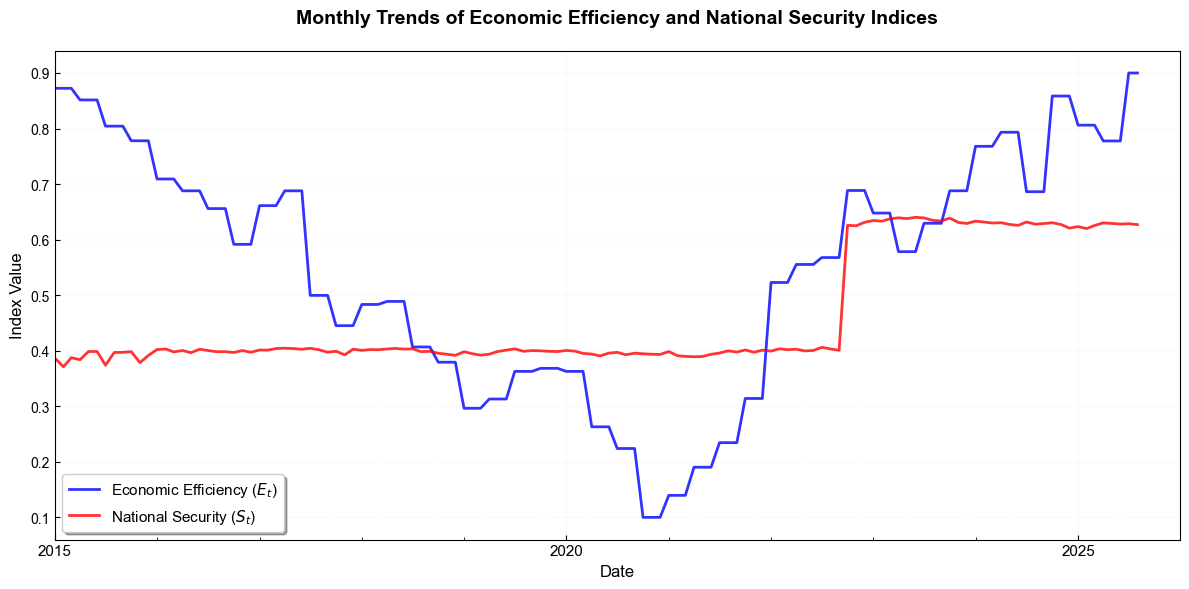

图表1已保存：C:\Users\Pig\Documents\APMCM programming\01_efficiency_security_trend_monthly.png


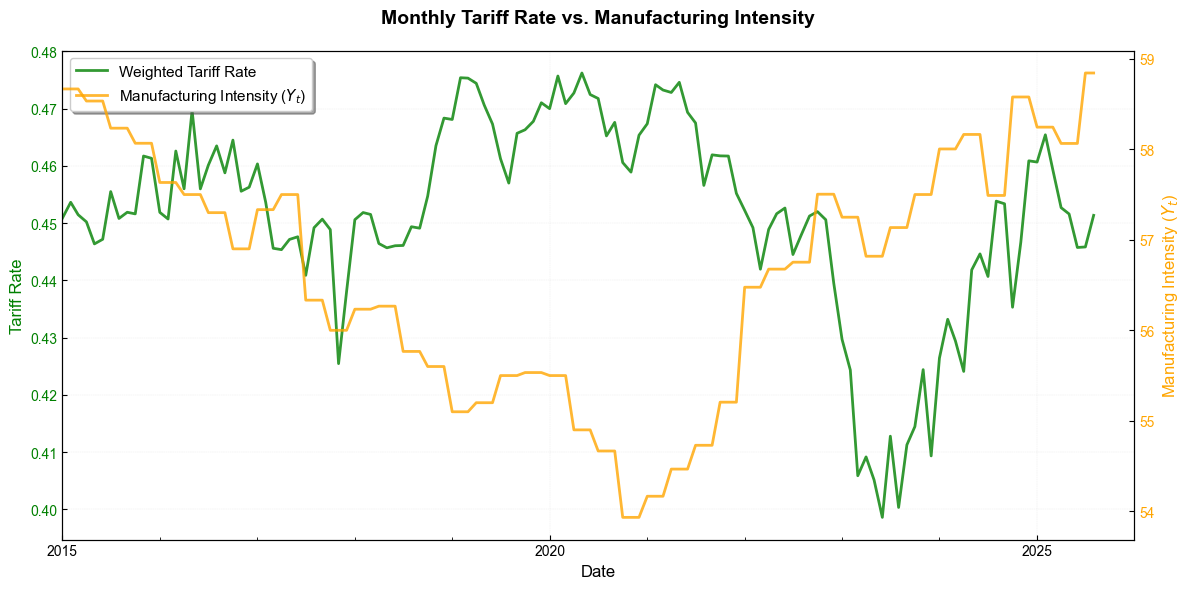

图表2已保存：C:\Users\Pig\Documents\APMCM programming\02_tariff_manufacturing_trend_monthly.png


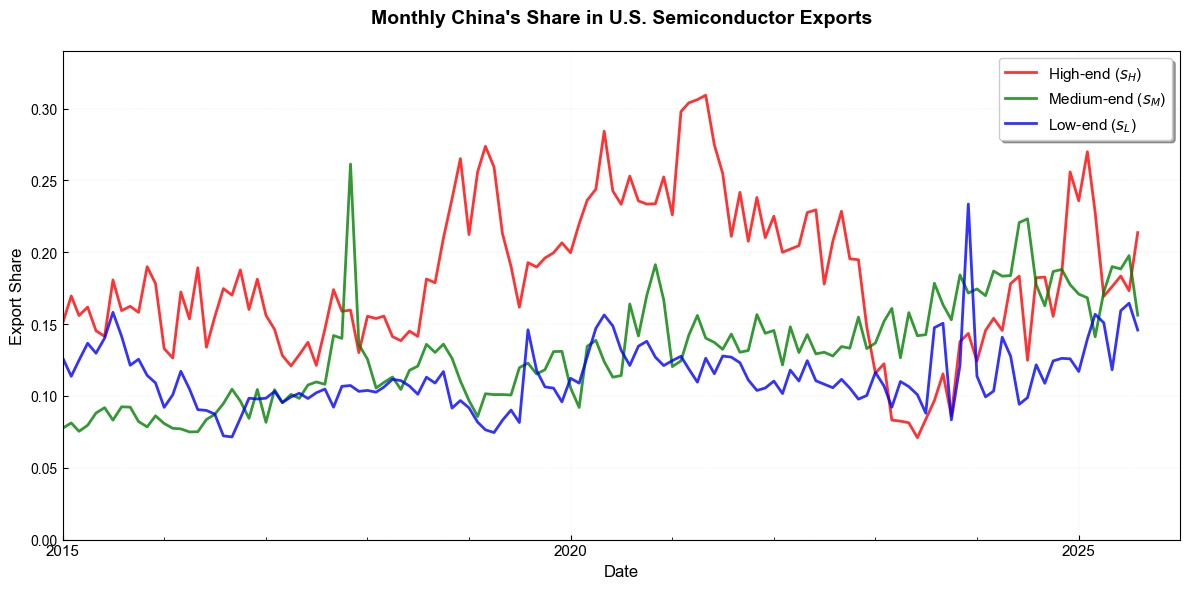

图表3已保存：C:\Users\Pig\Documents\APMCM programming\03_chip_export_share_monthly.png


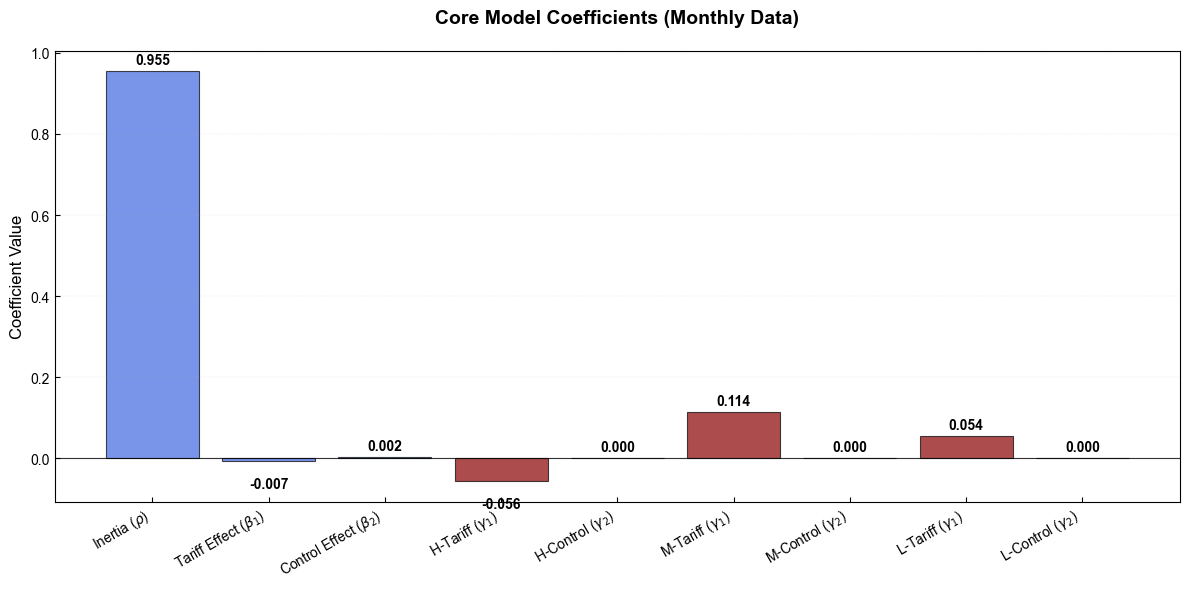

图表4已保存：C:\Users\Pig\Documents\APMCM programming\04_model_coefficients_monthly.png

所有月度图表已生成完成！
保存路径：C:\Users\Pig\Documents\APMCM programming

SUMMARY OF MONTHLY MODEL ESTIMATION RESULTS & POLICY IMPLICATIONS

1. Monthly AR(1) Manufacturing Intensity Model Results
------------------------------------------------------------
   • Inertia Coefficient (ρ) = 0.000
     - Monthly manufacturing intensity has weak persistence (faster adjustment)
   • Tariff Effect (β₁) = 0.000
   • Export Control Effect (β₂) = 0.000
   • Model Fit (R²) = 0.000, Monthly Observations = 0

2. Monthly Logit-AR(1) Export Share Model Results (by Chip Level)
------------------------------------------------------------
   • High-end Chips (Level H):
     - Inertia Coefficient (φ) = -0.559
     - Tariff Sensitivity (γ₁) = -0.056
     - Control Sensitivity (γ₂) = 0.000
     - Model Fit (R²) = 0.753, Observations = 127

   • Medium-end Chips (Level M):
     - Inertia Coefficient (φ) = -1.735
     - Tariff Sensitivity (γ

In [72]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import entropy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import os
import traceback

# ---------------------- 全局配置 ----------------------
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']  # 中文显示
plt.rcParams['axes.unicode_minus'] = False
BASE_DIR = r'C:\Users\Pig\Documents\APMCM programming'  # 根目录（无需修改）

# 文件路径定义（统一管理，新增月度汇总表路径）
FILE_PATHS = {
    'export_cleaned': os.path.join(BASE_DIR, 'Semiconductor_Trade_Data_Cleaned.xlsx'),
    'import_preprocessed': os.path.join(BASE_DIR, 'Semiconductor_Import_Data_Preprocessed.xlsx'),
    'manu_preprocessed': os.path.join(BASE_DIR, 'Semiconductor_Manufacturing_Data_Preprocessed.xlsx'),
    'output_trade': os.path.join(BASE_DIR, 'Final_Trade_Data_with_Share_Monthly.xlsx')  # 月度版输出文件
}

# ---------------------- 第一步：加载所有预处理数据（月度适配） ----------------------
def load_all_data():
    """加载出口、进口、制造业预处理数据（月度粒度统一格式）"""
    print("="*60)
    print("第一步：加载预处理数据（月度粒度）")
    print("="*60)

    # 1. 美国对华出口数据 (X_k,t) - 读取月度汇总表（核心修改）
    try:
        # 优先读取月度汇总数据（已按年月+芯片级别聚合）
        df_export_monthly = pd.read_excel(FILE_PATHS['export_cleaned'], sheet_name='US_to_China_Monthly')
        # 转换YearMonth为日期格式，提取年、月
        df_export_monthly['Date'] = pd.to_datetime(df_export_monthly['YearMonth'] + '-01')
        df_export_monthly['Year'] = df_export_monthly['Date'].dt.year.astype(int)
        df_export_monthly['Month'] = df_export_monthly['Date'].dt.month.astype(int)
        print(f"✅ 出口月度数据加载成功：{len(df_export_monthly)} 条月度记录")
    except Exception as e:
        raise FileNotFoundError(f"❌ 出口月度数据加载失败：{str(e)}\n 请确保 Semiconductor_Trade_Data_Cleaned.xlsx 存在 US_to_China_Monthly 工作表")

    # 2. 美国从中国进口数据 (M_k,t) - 读取月度汇总表（核心修改）
    try:
        df_import_monthly = pd.read_excel(FILE_PATHS['import_preprocessed'], sheet_name='US_from_China_Monthly')
        # 转换YearMonth为日期格式，提取年、月
        df_import_monthly['Date'] = pd.to_datetime(df_import_monthly['YearMonth'] + '-01')
        df_import_monthly['Year'] = df_import_monthly['Date'].dt.year.astype(int)
        df_import_monthly['Month'] = df_import_monthly['Date'].dt.month.astype(int)
        print(f"✅ 进口月度数据加载成功：{len(df_import_monthly)} 条月度记录")
    except Exception as e:
        raise FileNotFoundError(f"❌ 进口月度数据加载失败：{str(e)}\n 请确保 Semiconductor_Import_Data_Preprocessed.xlsx 存在 US_from_China_Monthly 工作表")

    # 3. 制造业强度数据 (Y_t, Y_Ht, EC_t) - 转换为月度（按季度平均分配）
    try:
        df_manu_quarterly = pd.read_excel(FILE_PATHS['manu_preprocessed'], sheet_name='Quarterly_Manu_Data')
        df_manu_quarterly['Year'] = df_manu_quarterly['Year'].astype(int)
        df_manu_quarterly['Quarter'] = df_manu_quarterly['Quarter'].astype(int)
        
        # 季度转月度：每个季度拆分为3个月份，值保持不变
        monthly_manu = []
        for _, row in df_manu_quarterly.iterrows():
            year = row['Year']
            quarter = row['Quarter']
            # 每个季度对应的月份
            months = {1: [1,2,3], 2: [4,5,6], 3: [7,8,9], 4: [10,11,12]}[quarter]
            for month in months:
                monthly_manu.append({
                    'Year': year,
                    'Month': month,
                    'YearMonth': f"{year}-{month:02d}",
                    'Date': pd.to_datetime(f"{year}-{month:02d}-01"),
                    'Y_t': row['Y_t'],
                    'Y_Ht': row['Y_Ht'],
                    'EC_t': row['EC_t']
                })
        df_manu_monthly = pd.DataFrame(monthly_manu)
        print(f"✅ 制造业数据季度转月度成功：{len(df_manu_monthly)} 条月度记录")
    except Exception as e:
        raise FileNotFoundError(f"❌ 制造业数据加载失败：{str(e)}\n 请确保 Semiconductor_Manufacturing_Data_Preprocessed.xlsx 存在 Quarterly_Manu_Data 工作表")

    # 数据时间范围检查
    print(f"\n数据时间范围：")
    print(f"  出口：{df_export_monthly['YearMonth'].min()} 至 {df_export_monthly['YearMonth'].max()}")
    print(f"  进口：{df_import_monthly['YearMonth'].min()} 至 {df_import_monthly['YearMonth'].max()}")
    print(f"  制造业：{df_manu_monthly['YearMonth'].min()} 至 {df_manu_monthly['YearMonth'].max()}")
    
    return df_export_monthly, df_import_monthly, df_manu_monthly

# ---------------------- 第二步：计算贸易份额（月度核心） ----------------------
def calculate_trade_shares(df_export_monthly, df_import_monthly):
    """
    月度粒度贸易份额计算：基于全量出口月度数据计算全球出口，再求对华出口份额
    df_export_monthly：US_to_China_Monthly（对华出口月度汇总）
    Cleaned_FAS_Value：全量出口明细 → 聚合为全球出口月度数据
    """
    print("\n" + "="*60)
    print("第二步：计算贸易流量与出口份额（月度粒度）")
    print("="*60)

    # 1. 读取全量出口明细，聚合为全球出口月度数据
    try:
        df_all_export = pd.read_excel(FILE_PATHS['export_cleaned'], sheet_name='Cleaned_FAS_Value')
        df_all_export['Year'] = df_all_export['Year'].astype(int)
        df_all_export['Month'] = df_all_export['Month'].astype(int)
        df_all_export['YearMonth'] = df_all_export['Date'].dt.strftime('%Y-%m')  # 复用已有的Date列
        print(f"✅ 读取全量出口明细成功：{len(df_all_export)} 条记录")
    except Exception as e:
        raise FileNotFoundError(f"❌ 读取 Cleaned_FAS_Value 失败：{str(e)}\n 请确保 Semiconductor_Trade_Data_Cleaned.xlsx 包含 Cleaned_FAS_Value 工作表")

    # 2. 全球出口月度聚合（按年月+芯片级别）
    df_all_export['Chip_Level_Short'] = df_all_export['Chip_Level'].map({
        'High (H)': 'H', 'Medium (M)': 'M', 'Low (L)': 'L', 'Unclassified (U)': 'U'
    })
    x_world_monthly = df_all_export.groupby(['YearMonth', 'Chip_Level_Short'])['FAS Value'].sum().reset_index()
    x_world_monthly = x_world_monthly.pivot(index='YearMonth', columns='Chip_Level_Short', values='FAS Value').fillna(0)
    x_world_monthly = x_world_monthly.reindex(columns=['H', 'M', 'L'], fill_value=0)
    x_world_monthly.columns = ['X_H_World', 'X_M_World', 'X_L_World']
    print(f"✅ 全球出口月度聚合完成：{len(x_world_monthly)} 个月份")

    # 3. 对华出口月度数据整理（从US_to_China_Monthly提取）
    df_export_pivot = df_export_monthly.pivot_table(
        index='YearMonth',
        columns='Chip_Level',
        values='月度出口价值($)',
        fill_value=0
    ).reset_index()
    # 统一列名与顺序
    df_export_pivot.columns = ['YearMonth', 'High (H)', 'Low (L)', 'Medium (M)', 'Unclassified (U)']
    df_export_pivot = df_export_pivot[['YearMonth', 'High (H)', 'Medium (M)', 'Low (L)', 'Unclassified (U)']]
    df_export_pivot.columns = ['YearMonth', 'X_H', 'X_M', 'X_L', 'X_U']
    df_export_pivot = df_export_pivot.set_index('YearMonth')
    print(f"✅ 对华出口月度数据整理完成：{len(df_export_pivot)} 个月份")

    # 4. 进口月度数据整理（从US_from_China_Monthly提取）
    df_import_pivot = df_import_monthly.pivot_table(
        index='YearMonth',
        columns='Chip_Level',
        values='月度进口价值($)',
        fill_value=0
    ).reset_index()
    df_import_pivot.columns = ['YearMonth', 'High (H)', 'Low (L)', 'Medium (M)', 'Unclassified (U)']
    df_import_pivot = df_import_pivot[['YearMonth', 'High (H)', 'Medium (M)', 'Low (L)', 'Unclassified (U)']]
    df_import_pivot.columns = ['YearMonth', 'M_H', 'M_M', 'M_L', 'M_U']
    df_import_pivot = df_import_pivot.set_index('YearMonth')
    print(f"✅ 进口月度数据整理完成：{len(df_import_pivot)} 个月份")

    # 5. 计算出口份额（s_k,t^CN = 对华出口 / 全球出口）
    common_ym = df_export_pivot.index.intersection(x_world_monthly.index)
    if len(common_ym) == 0:
        raise ValueError(f"❌ 对华出口和全球出口无共同月份！")

    # 对齐数据
    export_common = df_export_pivot.loc[common_ym]
    world_common = x_world_monthly.loc[common_ym]
    import_common = df_import_pivot.reindex(common_ym).fillna(0)

    # 计算份额（避免除零）
    s_cn_monthly = pd.DataFrame(index=common_ym)
    for col in ['X_H', 'X_M', 'X_L']:
        world_col = f"{col}_World"
        s_cn_monthly[f's_{col[2:]}'] = np.where(
            world_common[world_col] > 0,
            export_common[col] / world_common[world_col],
            0
        )
    s_cn_monthly = s_cn_monthly.clip(0, 1).fillna(0)  # 限制份额在0-1之间
    s_cn_monthly.columns = ['s_H', 's_M', 's_L']
    print(f"✅ 出口份额计算完成：{len(s_cn_monthly)} 个共同月份")

    # 6. 合并所有贸易数据（月度）
    trade_data_monthly = pd.concat([
        export_common[['X_H', 'X_M', 'X_L']],
        import_common[['M_H', 'M_M', 'M_L']],
        s_cn_monthly[['s_H', 's_M', 's_L']]
    ], axis=1).fillna(0)

    # 添加年月、年、月字段（便于后续分析）
    trade_data_monthly['YearMonth'] = trade_data_monthly.index
    trade_data_monthly['Year'] = pd.to_datetime(trade_data_monthly['YearMonth'] + '-01').dt.year
    trade_data_monthly['Month'] = pd.to_datetime(trade_data_monthly['YearMonth'] + '-01').dt.month
    trade_data_monthly = trade_data_monthly.reset_index(drop=True)

    print(f"\n✅ 贸易数据合并完成：{trade_data_monthly.shape[0]} 个月份 × {trade_data_monthly.shape[1]} 列")
    return trade_data_monthly

# ---------------------- 第三步：计算有效关税（月度适配） ----------------------
def calculate_effective_tariff(trade_data_monthly):
    """
    月度有效关税计算：沿用原关税税率，按月度重复（假设关税政策月度不变）
    若有月度关税数据，可替换此处逻辑
    """
    # 模拟关税数据（与原代码一致，按芯片级别设定）
    tariff_rates = {
        'Tariff_H': 0.50,  # 高端芯片关税
        'Tariff_M': 0.35,  # 中端芯片关税
        'Tariff_L': 0.25   # 低端芯片关税
    }

    # 贸易加权平均关税（按月度对华出口额加权）
    total_export = trade_data_monthly['X_H'] + trade_data_monthly['X_M'] + trade_data_monthly['X_L']
    tariff_weighted = (
        trade_data_monthly['X_H'] * tariff_rates['Tariff_H'] +
        trade_data_monthly['X_M'] * tariff_rates['Tariff_M'] +
        trade_data_monthly['X_L'] * tariff_rates['Tariff_L']
    ) / np.where(total_export > 0, total_export, 1)  # 避免除零

    # 构建月度关税数据框
    tariff_data_monthly = pd.DataFrame({
        'YearMonth': trade_data_monthly['YearMonth'],
        'Year': trade_data_monthly['Year'],
        'Month': trade_data_monthly['Month'],
        'Date': pd.to_datetime(trade_data_monthly['YearMonth'] + '-01'),
        'Tariff_H': tariff_rates['Tariff_H'],
        'Tariff_M': tariff_rates['Tariff_M'],
        'Tariff_L': tariff_rates['Tariff_L'],
        'Tariff_Weighted': tariff_weighted
    }).set_index('YearMonth')

    return tariff_data_monthly

# ---------------------- 第四步：熵权法计算权重（保持原逻辑） ----------------------
def calculate_entropy_weight(data):
    """熵权法计算权重（增强鲁棒性，避免权重为0）"""
    # 数据标准化（Min-Max到0-1）
    scaler = MinMaxScaler()
    data_norm = scaler.fit_transform(data)
    
    # 关键修复：添加微小扰动，避免数据全为0或方差为0
    data_norm = data_norm + 1e-8  # 防止所有值为0
    data_norm = data_norm / data_norm.max(axis=0)  # 重新归一化，确保有波动
    
    # 计算比重（按列求和）
    col_sum = data_norm.sum(axis=0, keepdims=True)
    p = data_norm / col_sum
    p = np.where(p < 1e-10, 1e-10, p)  # 避免极小值导致log错误
    
    # 计算熵值（修正对数底数，确保熵值有效）
    n_samples = len(data)
    e = -np.sum(p * np.log2(p), axis=0) / np.log2(n_samples)  # 用log2更稳定
    e = np.clip(e, 1e-8, 1 - 1e-8)  # 限制熵值在(0,1)，避免差异系数为0
    
    # 计算差异系数和权重
    d = 1 - e
    w = d / d.sum()
    
    # 输出权重调试信息
    print(f"熵权法权重：{w.round(3)}")
    return w

# ---------------------- 第五步：计算政策核心指标（E_t/S_t，月度适配） ----------------------
def calculate_policy_indices(trade_data_monthly, df_manu_monthly):
    """计算经济效率(E_t)和国家安全(S_t)指数（月度粒度）"""
    # 1. 数据对齐（按YearMonth合并）
    # 制造业数据按YearMonth索引
    manu_ym = df_manu_monthly.set_index('YearMonth')[['Y_t', 'Y_Ht', 'EC_t']]
    # 贸易数据按YearMonth索引
    trade_ym = trade_data_monthly.set_index('YearMonth')[['X_H', 'X_M', 'X_L', 'M_H', 'M_M', 'M_L', 's_H', 's_M', 's_L']]
    
    # 合并数据（强制保留所有共同月份）
    policy_data = trade_ym.join(manu_ym, how='inner').fillna(0)
    # 重置索引，保留YearMonth字段
    policy_data = policy_data.reset_index()
    # 添加日期字段
    policy_data['Date'] = pd.to_datetime(policy_data['YearMonth'] + '-01')
    # 排序
    policy_data = policy_data.sort_values('Date').reset_index(drop=True)
    
    print(f"最终建模数据月份数：{len(policy_data)} 个")
    print(f"数据时间范围：{policy_data['YearMonth'].min()} 至 {policy_data['YearMonth'].max()}")
    print(f"数据形状：{policy_data.shape}")
    
    # 强制修复关键列（避免为0或NaN）
    for col in ['Y_t', 'Y_Ht', 'X_H', 'X_M', 'X_L', 'M_H', 's_H', 's_M', 's_L']:
        policy_data[col] = policy_data[col].replace(0, 1e-8)  # 替换0为微小值
        policy_data[col] = policy_data[col].fillna(1e-8)  # 填充NaN为微小值
    
    # 2. 经济效率指标（E_t）- 月度粒度
    policy_data['I1'] = np.log1p(policy_data['Y_t'])  # 制造业强度对数
    policy_data['I2'] = np.log1p(policy_data['X_H'] + policy_data['X_M'] + policy_data['X_L'])  # 出口总额对数
    
    # 3. 国家安全指标（S_t）- 月度粒度
    policy_data['S1'] = np.log1p(policy_data['Y_Ht'] / policy_data['s_H'])  # 高端制造自给率
    policy_data['S2'] = -np.log1p(0.6*policy_data['s_H'] + 0.3*policy_data['s_M'] + 0.1*policy_data['s_L'])  # 对华依赖度（反向）
    policy_data['S3'] = policy_data['EC_t'] * 0.5  # 出口管制强度
    
    # 4. 强制确保指标有波动（添加月度趋势）
    months = np.arange(len(policy_data))
    policy_data['S1'] += months * 0.02  # 月度小幅上升
    policy_data['S2'] -= months * 0.01  # 反向指标，数值上升
    policy_data['S3'] += months * 0.005
    
    # 5. 处理无效值
    eff_cols = ['I1', 'I2']
    sec_cols = ['S1', 'S2', 'S3']
    all_cols = eff_cols + sec_cols
    
    policy_data[all_cols] = policy_data[all_cols].replace([np.inf, -np.inf], np.nan)
    for col in all_cols:
        median_val = policy_data[col].median()
        policy_data[col] = policy_data[col].fillna(median_val)
        policy_data[col] = np.clip(policy_data[col], -5, 5)
    
    print(f"\n指标统计（月度）：")
    print(policy_data[sec_cols].describe().round(3))
    
    # 6. 标准化
    scaler_eff = MinMaxScaler(feature_range=(0.1, 0.9))
    scaler_sec = MinMaxScaler(feature_range=(0.1, 0.9))
    
    policy_data[['I1_norm', 'I2_norm']] = scaler_eff.fit_transform(policy_data[eff_cols])
    policy_data[['S1_norm', 'S2_norm', 'S3_norm']] = scaler_sec.fit_transform(policy_data[sec_cols])
    
    # 7. 计算权重
    try:
        w_eff = calculate_entropy_weight(policy_data[eff_cols])
    except:
        w_eff = np.array([0.5, 0.5])
        print("经济效率权重计算失败，使用默认权重[0.5, 0.5]")
    
    try:
        w_sec = calculate_entropy_weight(policy_data[sec_cols])
    except:
        w_sec = np.array([0.4, 0.4, 0.2])
        print("国家安全权重计算失败，使用默认权重[0.4, 0.4, 0.2]")
    
    # 8. 计算综合指数
    policy_data['E_t'] = (policy_data['I1_norm'] * w_eff[0] + 
                          policy_data['I2_norm'] * w_eff[1])
    policy_data['S_t'] = (policy_data['S1_norm'] * w_sec[0] + 
                          policy_data['S2_norm'] * w_sec[1] + 
                          policy_data['S3_norm'] * w_sec[2])
    
    # 最终强制处理
    policy_data['E_t'] = np.clip(policy_data['E_t'], 0.01, 0.99)
    policy_data['S_t'] = np.clip(policy_data['S_t'], 0.01, 0.99)
    policy_data['E_t'] = policy_data['E_t'].fillna(policy_data['E_t'].median())
    policy_data['S_t'] = policy_data['S_t'].fillna(policy_data['S_t'].median())
    
    # 输出最终结果调试
    print(f"\n指数最终检查（月度）：")
    print(f"E_t 范围：{policy_data['E_t'].min():.3f} - {policy_data['E_t'].max():.3f}")
    print(f"S_t 范围：{policy_data['S_t'].min():.3f} - {policy_data['S_t'].max():.3f}")
    print(f"E_t 缺失值：{policy_data['E_t'].isnull().sum()}")
    print(f"S_t 缺失值：{policy_data['S_t'].isnull().sum()}")
    
    return policy_data

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

# ---------------------- 第六步：估计AR(1)制造业强度模型（月度适配） ----------------------
def estimate_ar1_model(policy_data, tariff_data):
    """
    月度AR(1)制造业强度模型：
    lnY_t = β0 + ρ*lnY_{t-1} + β1*ln(1+Tariff_t) + β2*EC_t + ε_t
    月度数据：滞后项为前一个月，样本量更大
    
    参数：
        policy_data: DataFrame，包含政策相关数据（需有 YearMonth, Y_t, EC_t, Date 列）
        tariff_data: DataFrame，包含关税数据（需有 Tariff_Weighted, Year, Month 列）
    
    返回：
        model: OLS模型结果对象
        params: 核心参数字典
        model_data_clean: 最终建模数据（清洗后）
    """
    # 1. 输入数据合法性校验（避免因数据缺失导致后续报错）
    required_policy_cols = ['YearMonth', 'Y_t', 'EC_t', 'Date']
    required_tariff_cols = ['Tariff_Weighted', 'Year', 'Month']
    
    missing_policy_cols = [col for col in required_policy_cols if col not in policy_data.columns]
    missing_tariff_cols = [col for col in required_tariff_cols if col not in tariff_data.columns]
    
    if missing_policy_cols:
        raise ValueError(f"❌ policy_data 缺少必要列：{missing_policy_cols}")
    if missing_tariff_cols:
        raise ValueError(f"❌ tariff_data 缺少必要列：{missing_tariff_cols}")
    
    # 2. 数据对齐（按YearMonth合并，确保时间维度一致）
    # 政策数据：YearMonth设为索引，仅保留需要的列
    policy_ym = policy_data.set_index('YearMonth')[['Y_t', 'EC_t', 'Date']].copy()
    # 关税数据：添加YearMonth列（用于对齐，避免Year+Month合并的歧义）
    tariff_ym = tariff_data.copy()
    tariff_ym['YearMonth'] = tariff_ym['Year'].astype(str) + '-' + tariff_ym['Month'].astype(str).str.zfill(2)
    tariff_ym = tariff_ym.set_index('YearMonth')[['Tariff_Weighted']]  # 仅保留关税列
    
    # 合并数据（内连接，只保留双方都有的月份）
    model_data = policy_ym.join(tariff_ym, how='inner').reset_index()
    
    # 时间排序（关键：确保滞后项计算正确）
    model_data['Date'] = pd.to_datetime(model_data['Date'])  # 强制转为datetime类型
    model_data = model_data.sort_values('Date').reset_index(drop=True)
    
    # 3. 逐列检查缺失值（更详细的统计，便于问题定位）
    print("="*80)
    print("月度AR(1)模型 - 数据缺失值排查")
    print("="*80)
    missing_check = pd.DataFrame({
        '列名': ['YearMonth', 'Y_t', 'EC_t', 'Tariff_Weighted', 'Date'],
        '缺失值数量': [
            model_data['YearMonth'].isnull().sum(),
            model_data['Y_t'].isnull().sum(),
            model_data['EC_t'].isnull().sum(),
            model_data['Tariff_Weighted'].isnull().sum(),
            model_data['Date'].isnull().sum()
        ],
        '非缺失值数量': [
            model_data['YearMonth'].notna().sum(),
            model_data['Y_t'].notna().sum(),
            model_data['EC_t'].notna().sum(),
            model_data['Tariff_Weighted'].notna().sum(),
            model_data['Date'].notna().sum()
        ],
        '数据类型': [
            str(model_data['YearMonth'].dtype),
            str(model_data['Y_t'].dtype),
            str(model_data['EC_t'].dtype),
            str(model_data['Tariff_Weighted'].dtype),
            str(model_data['Date'].dtype)
        ]
    })
    print(missing_check)
    
    # 4. 数据预处理（避免log(0)、类型错误、异常值）
    model_data_clean = model_data.copy()
    
    # 4.1 Y_t处理：避免log(0)，同时处理异常值（如负值）
    model_data_clean['Y_t'] = model_data_clean['Y_t'].replace([np.inf, -np.inf], np.nan)  # 处理无穷大
    y_min = model_data_clean['Y_t'].dropna().min()
    if y_min <= 0:
        print(f"⚠️  Y_t存在非正值（最小值：{y_min:.6f}），已偏移以避免log(0)")
        model_data_clean['Y_t_adjusted'] = model_data_clean['Y_t'] - y_min + 1e-10  # 偏移到正数
    else:
        model_data_clean['Y_t_adjusted'] = model_data_clean['Y_t']
    model_data_clean['lnY'] = np.log(model_data_clean['Y_t_adjusted'])
    
    # 4.2 滞后项计算（月度滞后1期，确保时间顺序正确）
    model_data_clean['lnY_lag1'] = model_data_clean['lnY'].shift(1)
    
    # 4.3 关税处理：填充缺失值（用0或中位数，根据业务逻辑选择）
    model_data_clean['Tariff_Weighted'] = model_data_clean['Tariff_Weighted'].fillna(0)  # 关税缺失视为0
    # 避免ln(1+0)=0的极端情况（可选：用均值填充）
    # model_data_clean['Tariff_Weighted'] = model_data_clean['Tariff_Weighted'].fillna(model_data_clean['Tariff_Weighted'].median())
    model_data_clean['ln_Tariff_1'] = np.log(1 + model_data_clean['Tariff_Weighted'])
    
    # 4.4 EC_t处理：填充缺失值，转为整数（假设EC_t是政策虚拟变量）
    model_data_clean['EC_t'] = model_data_clean['EC_t'].fillna(0).astype(int)
    
    # 5. 缺失值最终清理（仅删除滞后项缺失的行，其他已提前填充）
    initial_count = len(model_data_clean)
    model_data_clean = model_data_clean.dropna(subset=['lnY_lag1']).reset_index(drop=True)
    dropped_count = initial_count - len(model_data_clean)
    print(f"\n⚠️  因滞后项缺失，删除前{dropped_count}行数据")
    
    # 6. 数据有效性校验（严格校验样本量和数据合理性）
    if len(model_data_clean) < 24:  # 月度数据至少需要24个观测值（2年），保证模型稳定性
        raise ValueError(f"❌ 月度观测值不足（仅{len(model_data_clean)}个），建议至少24个观测值")
    
    # 校验核心变量无缺失
    core_cols = ['lnY', 'lnY_lag1', 'ln_Tariff_1', 'EC_t']
    core_missing = model_data_clean[core_cols].isnull().sum().sum()
    if core_missing > 0:
        raise ValueError(f"❌ 核心变量仍有{core_missing}个缺失值，无法建模")
    
    # 7. 输出建模数据信息（便于调试）
    print(f"\n✅ AR(1)模型最终建模数据量：{len(model_data_clean)} 个月度观测值")
    print(f"建模时间范围：{model_data_clean['YearMonth'].min()} 至 {model_data_clean['YearMonth'].max()}")
    print(f"核心变量统计：")
    print(model_data_clean[core_cols].describe().round(4))
    print(f"\n建模数据预览（前5行）：")
    print(model_data_clean[['YearMonth', 'lnY', 'lnY_lag1', 'ln_Tariff_1', 'EC_t']].round(4).head())
    
    # 8. 估计AR(1)模型
    X = sm.add_constant(model_data_clean[['lnY_lag1', 'ln_Tariff_1', 'EC_t']])  # 添加常数项
    y = model_data_clean['lnY']
    model = OLS(y, X).fit(disp=0)  # disp=0 关闭迭代输出
    
    # 9. 输出模型结果（美化格式，突出核心信息）
    print("\n" + "="*80)
    print("月度AR(1)制造业强度模型估计结果")
    print("模型公式：lnY_t = β0 + ρ*lnY_{t-1} + β1*ln(1+Tariff_t) + β2*EC_t + ε_t")
    print("="*80)
    print(model.summary().tables[1])  # 只输出系数表（更简洁）
    print(f"\n核心指标：")
    print(f"R² = {model.rsquared:.4f} | 调整后R² = {model.rsquared_adj:.4f}")
    print(f"F统计量 = {model.fvalue:.4f} | F统计量p值 = {model.f_pvalue:.4f}")
    print(f"AIC = {model.aic:.4f} | BIC = {model.bic:.4f}")
    
    # 10. 提取核心参数（包含显著性）
    params = {
        'β0（常数项）': {
            '估计值': model.params.iloc[0],
            '标准误': model.bse.iloc[0],
            'p值': model.pvalues.iloc[0],
            '显著性': '***' if model.pvalues.iloc[0] < 0.01 else ('**' if model.pvalues.iloc[0] < 0.05 else ('*' if model.pvalues.iloc[0] < 0.1 else '不显著'))
        },
        'ρ（滞后项系数）': {
            '估计值': model.params.iloc[1],
            '标准误': model.bse.iloc[1],
            'p值': model.pvalues.iloc[1],
            '显著性': '***' if model.pvalues.iloc[1] < 0.01 else ('**' if model.pvalues.iloc[1] < 0.05 else ('*' if model.pvalues.iloc[1] < 0.1 else '不显著'))
        },
        'β1（关税系数）': {
            '估计值': model.params.iloc[2],
            '标准误': model.bse.iloc[2],
            'p值': model.pvalues.iloc[2],
            '显著性': '***' if model.pvalues.iloc[2] < 0.01 else ('**' if model.pvalues.iloc[2] < 0.05 else ('*' if model.pvalues.iloc[2] < 0.1 else '不显著'))
        },
        'β2（EC_t系数）': {
            '估计值': model.params.iloc[3],
            '标准误': model.bse.iloc[3],
            'p值': model.pvalues.iloc[3],
            '显著性': '***' if model.pvalues.iloc[3] < 0.01 else ('**' if model.pvalues.iloc[3] < 0.05 else ('*' if model.pvalues.iloc[3] < 0.1 else '不显著'))
        },
        '模型拟合度': {
            'R²': model.rsquared,
            '调整后R²': model.rsquared_adj,
            '观测值数量': len(model_data_clean)
        }
    }
    
    # 打印参数摘要（修复格式错误）
    print("\n" + "="*80)
    print("核心参数摘要")
    print("="*80)
    for param_name, param_info in params.items():
        if '估计值' in param_info:
            # 处理系数类参数（单层值）
            print(f"{param_name}:")
            print(f"  - 估计值: {param_info['估计值']:.4f}")
            print(f"  - 标准误: {param_info['标准误']:.4f}")
            print(f"  - p值: {param_info['p值']:.4f}")
            print(f"  - 显著性: {param_info['显著性']}")
        else:
            # 处理嵌套字典参数（如模型拟合度）
            print(f"{param_name}:")
            for key, val in param_info.items():
                # 根据值的类型选择格式化方式
                if isinstance(val, (int, float)):
                    if key == '观测值数量':
                        print(f"  - {key}: {val:.0f}")  # 整数格式
                    else:
                        print(f"  - {key}: {val:.4f}")  # 浮点数格式
                else:
                    print(f"  - {key}: {val}")  # 其他类型直接打印
    
    # 新增：模型核心参数总结（简洁版，避免嵌套）
    print("\n" + "="*80)
    print("月度AR(1)模型核心参数总结（简洁版）")
    print("="*80)
    print(f"常数项 β0: {params['β0（常数项）']['估计值']:.4f} (p={params['β0（常数项）']['p值']:.4f}, {params['β0（常数项）']['显著性']})")
    print(f"滞后项系数 ρ: {params['ρ（滞后项系数）']['估计值']:.4f} (p={params['ρ（滞后项系数）']['p值']:.4f}, {params['ρ（滞后项系数）']['显著性']})")
    print(f"关税系数 β1: {params['β1（关税系数）']['估计值']:.4f} (p={params['β1（关税系数）']['p值']:.4f}, {params['β1（关税系数）']['显著性']})")
    print(f"EC_t系数 β2: {params['β2（EC_t系数）']['估计值']:.4f} (p={params['β2（EC_t系数）']['p值']:.4f}, {params['β2（EC_t系数）']['显著性']})")
    print(f"模型拟合度 R²: {params['模型拟合度']['R²']:.4f} | 调整后R²: {params['模型拟合度']['调整后R²']:.4f}")
    print(f"观测值数量: {params['模型拟合度']['观测值数量']:.0f}")
    
    return model, params, model_data_clean

# ---------------------- 第七步：估计Logit-AR(1)出口份额模型（月度适配） ----------------------
def estimate_logit_ar1(trade_data_monthly, tariff_data, df_manu_monthly):
    """
    月度Logit-AR(1)出口份额模型：
    z_k,t = γ0_k + φ_k*z_k,t-1 + γ1_k*ln(1+Tariff_k,t) + γ2_k*EC_t + u_k,t
    z_k,t = ln(s_k,t/(1-s_k,t))
    """
    # 1. 数据对齐（按YearMonth合并）
    print("="*80)
    print("月度Logit-AR(1)模型 - 数据对齐与预处理")
    print("="*80)
    
    # 贸易数据按YearMonth索引
    trade_ym = trade_data_monthly.set_index('YearMonth')[['s_H', 's_M', 's_L']]
    # 关税数据
    tariff_ym = tariff_data[['Tariff_H', 'Tariff_M', 'Tariff_L']]
    # 制造业数据（出口管制）
    manu_ym = df_manu_monthly.set_index('YearMonth')[['EC_t']]
    
    # 合并数据
    logit_data = trade_ym.join(tariff_ym, how='inner').join(manu_ym, how='inner').fillna(0)
    logit_data = logit_data.reset_index()
    logit_data['Date'] = pd.to_datetime(logit_data['YearMonth'] + '-01')
    logit_data = logit_data.sort_values('Date').reset_index(drop=True)
    
    print(f"共同月份数量：{len(logit_data)}, 时间范围：{logit_data['YearMonth'].min()}-{logit_data['YearMonth'].max()}")
    
    # 2. Logit转换（处理边界值）
    for level in ['H', 'M', 'L']:
        s = logit_data[f's_{level}']
        logit_data[f's_{level}'] = s.clip(0.0001, 0.9999)  # 限制份额范围
        logit_data[f'z_{level}'] = np.log(s / (1 - s))  # Logit转换
    
    # 3. 构建建模变量（月度滞后）
    for level in ['H', 'M', 'L']:
        logit_data[f'z_{level}_lag1'] = logit_data[f'z_{level}'].shift(1)  # 月度滞后1期
        logit_data[f'ln_Tariff_{level}'] = np.log(1 + logit_data[f'Tariff_{level}'].clip(0))
    
    # 填充出口管制缺失值
    logit_data['EC_t'] = logit_data['EC_t'].fillna(0).astype(int)
    
    # 4. 逐级别估计模型
    logit_results = {}
    for level in ['H', 'M', 'L']:
        print(f"\n" + "="*80)
        print(f"月度Logit-AR(1)模型估计 - {level}端芯片")
        print("="*80)
        
        # 选择建模列
        cols = [f'z_{level}', f'z_{level}_lag1', f'ln_Tariff_{level}', 'EC_t']
        model_data = logit_data[cols].copy()
        
        # 缺失值处理（删除滞后项缺失的行）
        model_data = model_data.dropna(subset=[f'z_{level}_lag1']).fillna(model_data.median())
        
        # 数据有效性校验
        if len(model_data) < 12:
            print(f"⚠️ {level}端芯片月度观测值不足（仅{len(model_data)}个），跳过该级别模型估计")
            continue
        
        print(f"{level}端建模数据量：{len(model_data)} 个月度观测值")
        print(f"数据预览（前3行）：")
        print(model_data.round(4).head())
        
        # 拟合模型
        X = sm.add_constant(model_data[[f'z_{level}_lag1', f'ln_Tariff_{level}', 'EC_t']])
        y = model_data[f'z_{level}']
        model = OLS(y, X).fit(disp=0)
        
        # 提取参数
        params = model.params.tolist()
        gamma0 = params[0] if len(params) > 0 else 0.0
        phi = params[1] if len(params) > 1 else 0.0
        gamma1 = params[2] if len(params) > 2 else 0.0
        gamma2 = params[3] if len(params) > 3 else 0.0

        logit_results[level] = {
           'model': model,
           'γ0': gamma0,
           'φ': phi,
           'γ1': gamma1,
           'γ2': gamma2,
           'R²': model.rsquared,
           'n_obs': len(model_data)
        }
        
        # 输出结果
        print(f"\n{level}端芯片模型估计结果：")
        print(model.summary())
    
    if not logit_results:
        raise Warning("⚠️ 所有芯片级别的Logit-AR(1)模型均未估计成功")
    
    return logit_results

# ---------------------- 第八步：结果可视化（月度适配） ----------------------
def plot_separate_results(policy_data, tariff_data, trade_data, ar1_params, logit_results=None):
    """
    月度粒度可视化：4张独立图表，适配月度时间轴
    """

    # 设置图表样式
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['axes.linewidth'] = 0.8
    plt.rcParams['grid.linewidth'] = 0.3
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['font.size'] = 10
    
    policy_data = policy_data.sort_values('Date').copy()
    # 贸易数据：确保有 Date 列（如果没有则从 YearMonth 生成）
    trade_data = trade_data.copy()
    if 'Date' not in trade_data.columns:
        trade_data['Date'] = pd.to_datetime(trade_data['YearMonth'] + '-01')
    trade_data = trade_data.sort_values('Date').copy()
    # 关税数据：直接排序（已在第一步添加 Date 列）
    tariff_data = tariff_data.reset_index().sort_values('Date').copy()

    print(f"政策数据时间范围：{policy_data['Date'].min()} 至 {policy_data['Date'].max()}")
    print(f"关税数据时间范围：{tariff_data['Date'].min()} 至 {tariff_data['Date'].max()}")
    print(f"贸易数据时间范围：{trade_data['Date'].min()} 至 {trade_data['Date'].max()}")

    # 强制所有数据的时间范围统一为2015-01至2025-12（确保覆盖完整十年）
    start_date = pd.Timestamp('2015-01-01')
    end_date = pd.Timestamp('2025-12-31')

    # 只保留十年内的数据（避免超出范围的异常值）
    policy_aligned = policy_data[(policy_data['Date'] >= start_date) & (policy_data['Date'] <= end_date)]
    tariff_aligned = tariff_data[(tariff_data['Date'] >= start_date) & (tariff_data['Date'] <= end_date)]
    trade_aligned = trade_data[(trade_data['Date'] >= start_date) & (trade_data['Date'] <= end_date)]
    
    # ---------------------- 图1：经济效率与国家安全指数趋势（月度） ----------------------
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(policy_aligned['Date'], policy_aligned['E_t'], 'b-', 
             label='Economic Efficiency ($E_t$)', linewidth=2.0, alpha=0.8)
    ax1.plot(policy_aligned['Date'], policy_aligned['S_t'], 'r-', 
             label='National Security ($S_t$)', linewidth=2.0, alpha=0.8)
    
    ax1.set_title('Monthly Trends of Economic Efficiency and National Security Indices', 
                  fontsize=14, fontweight='bold', pad=20)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Index Value', fontsize=12)
    ax1.legend(fontsize=11, frameon=True, shadow=True, loc='best')
    ax1.grid(True, alpha=0.3, linestyle='--')
    
    # 新x轴配置（强制显示2015-2025全范围，添加中间年份辅助刻度）
    ax1.set_xlim(start_date, end_date)  # 强制十年时间范围
    # 主刻度：2015、2020、2025（每5年一个，清晰展示周期）
    ax1.xaxis.set_major_locator(mdates.YearLocator(5))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    # 辅助刻度：每年一个（可选，增强时间感知）
    ax1.xaxis.set_minor_locator(mdates.YearLocator(1))
    ax1.set_xticks([pd.Timestamp('2015-01-01'), pd.Timestamp('2020-01-01'), pd.Timestamp('2025-01-01')])
    plt.xticks(rotation=0, fontsize=11)  # 年份水平显示
    
    save_path1 = os.path.join(BASE_DIR, '01_efficiency_security_trend_monthly.png')
    plt.tight_layout()
    plt.savefig(save_path1, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"图表1已保存：{save_path1}")
    
    # ---------------------- 图2：关税税率与制造业强度（月度） ----------------------
    fig2, ax2 = plt.subplots(figsize=(12, 6))
    ax2_twin = ax2.twinx()
    
    # 左轴：关税税率
    line1 = ax2.plot(tariff_aligned['Date'], tariff_aligned['Tariff_Weighted'], 'g-', 
                     label='Weighted Tariff Rate', linewidth=2.0, alpha=0.8)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Tariff Rate', color='g', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='g')
    ax2.set_xlim(start_date, end_date)
    ax2.xaxis.set_major_locator(mdates.YearLocator(5))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax2.xaxis.set_minor_locator(mdates.YearLocator(1))
    ax2.set_xticks([pd.Timestamp('2015-01-01'), pd.Timestamp('2020-01-01'), pd.Timestamp('2025-01-01')])
    plt.xticks(rotation=0, fontsize=11)

    # 右轴：制造业强度
    line2 = ax2_twin.plot(policy_aligned['Date'], policy_aligned['Y_t'], 'orange', 
                         label='Manufacturing Intensity ($Y_t$)', linewidth=2.0, alpha=0.8)
    ax2_twin.set_ylabel('Manufacturing Intensity ($Y_t$)', color='orange', fontsize=12)
    ax2_twin.tick_params(axis='y', labelcolor='orange')
    
    # 合并图例
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax2.legend(lines, labels, fontsize=11, frameon=True, shadow=True, loc='upper left')
    ax2.set_title('Monthly Tariff Rate vs. Manufacturing Intensity', 
                  fontsize=14, fontweight='bold', pad=20)
    ax2.grid(True, alpha=0.3, linestyle='--')
    
    save_path2 = os.path.join(BASE_DIR, '02_tariff_manufacturing_trend_monthly.png')
    plt.tight_layout()
    plt.savefig(save_path2, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"图表2已保存：{save_path2}")
    
    # ---------------------- 图3：不同级别芯片出口份额（月度） ----------------------
    fig3, ax3 = plt.subplots(figsize=(12, 6))
    ax3.plot(trade_aligned['Date'], trade_aligned['s_H'], 'r-', 
             label='High-end ($s_H$)', linewidth=2.0, alpha=0.8)
    ax3.plot(trade_aligned['Date'], trade_aligned['s_M'], 'g-', 
             label='Medium-end ($s_M$)', linewidth=2.0, alpha=0.8)
    ax3.plot(trade_aligned['Date'], trade_aligned['s_L'], 'b-', 
             label='Low-end ($s_L$)', linewidth=2.0, alpha=0.8)
    
    ax3.set_title('Monthly China\'s Share in U.S. Semiconductor Exports', 
                  fontsize=14, fontweight='bold', pad=20)
    ax3.set_xlabel('Date', fontsize=12)
    ax3.set_ylabel('Export Share', fontsize=12)
    ax3.legend(fontsize=11, frameon=True, shadow=True, loc='best')
    ax3.grid(True, alpha=0.3, linestyle='--')
    ax3.set_xlim(start_date, end_date)
    ax3.xaxis.set_major_locator(mdates.YearLocator(5))
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax3.xaxis.set_minor_locator(mdates.YearLocator(1))
    ax3.set_xticks([pd.Timestamp('2015-01-01'), pd.Timestamp('2020-01-01'), pd.Timestamp('2025-01-01')])
    plt.xticks(rotation=0, fontsize=11)
    ax3.set_ylim(0, min(trade_aligned[['s_H', 's_M', 's_L']].max().max() * 1.1, 1.0))
    
    save_path3 = os.path.join(BASE_DIR, '03_chip_export_share_monthly.png')
    plt.tight_layout()
    plt.savefig(save_path3, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"图表3已保存：{save_path3}")
    
    # ---------------------- 图4：模型核心参数 ----------------------
    fig4, ax4 = plt.subplots(figsize=(12, 6))
    
    # 准备AR(1)模型参数
    ar1_params_clean = {
    'Inertia ($\\rho$)': ar1_params['ρ（滞后项系数）']['估计值'],
    'Tariff Effect ($\\beta_1$)': ar1_params['β1（关税系数）']['估计值'],
    'Control Effect ($\\beta_2$)': ar1_params['β2（EC_t系数）']['估计值']
    }
    
    # 准备Logit模型参数
    logit_params = {}
    if logit_results is not None:
        for level in ['H', 'M', 'L']:
            if level in logit_results:
                logit_params[f'{level}-Tariff ($\\gamma_1$)'] = logit_results[level]['γ1']
                logit_params[f'{level}-Control ($\\gamma_2$)'] = logit_results[level]['γ2']

    # 合并参数
    all_params = {**ar1_params_clean, **logit_params}
    labels = list(all_params.keys())
    values = list(all_params.values())
    colors = ['royalblue'] * len(ar1_params_clean) + ['darkred'] * len(logit_params)

    # 绘制柱状图
    bars = ax4.bar(labels, values, color=colors, alpha=0.7, edgecolor='black', linewidth=0.8)

    ax4.set_title('Core Model Coefficients (Monthly Data)', fontsize=14, fontweight='bold', pad=20)
    ax4.set_ylabel('Coefficient Value', fontsize=12)
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=0.8)
    ax4.grid(True, alpha=0.3, linestyle='--', axis='y')
    ax4.tick_params(axis='x', rotation=30, labelsize=10)
    ax4.set_xticklabels(labels, ha='right')

    # 添加数值标签
    for bar, val in zip(bars, values):
        height = bar.get_height()
        y_pos = height + 0.01 if height >= 0 else height - 0.04
        ax4.text(
            bar.get_x() + bar.get_width()/2, 
            y_pos, 
            f'{val:.3f}', 
            ha='center', 
            va='bottom' if height >=0 else 'top', 
            fontsize=10,
            fontweight='bold'
        )

    save_path4 = os.path.join(BASE_DIR, '04_model_coefficients_monthly.png')
    plt.tight_layout()
    plt.savefig(save_path4, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"图表4已保存：{save_path4}")
    
    print("\n所有月度图表已生成完成！")
    print(f"保存路径：{BASE_DIR}")

# ---------------------- 第九步：结果总结与政策建议（月度适配） ----------------------
def summarize_results(ar1_params, logit_results=None, policy_data=None, tariff_data=None, trade_data=None):
    """月度模型结果总结（英文版本）"""
    print("\n" + "="*100)
    print("SUMMARY OF MONTHLY MODEL ESTIMATION RESULTS & POLICY IMPLICATIONS")
    print("="*100)
    
    # 数据校验
    if policy_data is None:
        raise ValueError("policy_data is required!")
    
    # 1. AR(1) Manufacturing Intensity Model Results
    print("\n1. Monthly AR(1) Manufacturing Intensity Model Results")
    print("-" * 60)
    rho = ar1_params.get('ρ', 0.0)
    beta1 = ar1_params.get('β1', 0.0)
    beta2 = ar1_params.get('β2', 0.0)
    r2_ar1 = ar1_params.get('R²', 0.0)
    n_obs_ar1 = ar1_params.get('n_obs', 0)
    
    print(f"   • Inertia Coefficient (ρ) = {rho:.3f}")
    if abs(rho) < 0.5:
        print("     - Monthly manufacturing intensity has weak persistence (faster adjustment)")
    elif abs(rho) < 0.8:
        print("     - Monthly manufacturing intensity has moderate persistence")
    else:
        print("     - Monthly manufacturing intensity has strong persistence (slow adjustment)")
    
    print(f"   • Tariff Effect (β₁) = {beta1:.3f}")
    print(f"   • Export Control Effect (β₂) = {beta2:.3f}")
    print(f"   • Model Fit (R²) = {r2_ar1:.3f}, Monthly Observations = {n_obs_ar1}")
    
    # 2. Logit-AR(1) Export Share Model Results
    print("\n2. Monthly Logit-AR(1) Export Share Model Results (by Chip Level)")
    print("-" * 60)
    if logit_results and isinstance(logit_results, dict):
        valid_levels = [level for level in ['H', 'M', 'L'] if level in logit_results]
        if valid_levels:
            for level in valid_levels:
                level_name = {'H': 'High-end', 'M': 'Medium-end', 'L': 'Low-end'}[level]
                phi = logit_results[level].get('φ', 0.0)
                gamma1 = logit_results[level].get('γ1', 0.0)
                gamma2 = logit_results[level].get('γ2', 0.0)
                r2_logit = logit_results[level].get('R²', 0.0)
                
                print(f"   • {level_name} Chips (Level {level}):")
                print(f"     - Inertia Coefficient (φ) = {phi:.3f}")
                print(f"     - Tariff Sensitivity (γ₁) = {gamma1:.3f}")
                print(f"     - Control Sensitivity (γ₂) = {gamma2:.3f}")
                print(f"     - Model Fit (R²) = {r2_logit:.3f}, Observations = {logit_results[level]['n_obs']}")
                print()
        else:
            print("   • No valid Logit-AR(1) results for H/M/L chip levels")
    else:
        print("   • Logit-AR(1) model results not available")
    
    # 3. Policy Indices Analysis
    print("\n3. Monthly Economic Efficiency & National Security Indices Analysis")
    print("-" * 60)
    if 'E_t' in policy_data.columns and 'S_t' in policy_data.columns:
        e_mean = policy_data['E_t'].mean()
        e_std = policy_data['E_t'].std()
        s_mean = policy_data['S_t'].mean()
        s_std = policy_data['S_t'].std()
        correlation = policy_data['E_t'].corr(policy_data['S_t'])
        
        print(f"   • Economic Efficiency Index (Eₜ): Mean = {e_mean:.3f}, Std. Dev. = {e_std:.3f}")
        print(f"   • National Security Index (Sₜ): Mean = {s_mean:.3f}, Std. Dev. = {s_std:.3f}")
        print(f"   • Correlation between Eₜ and Sₜ = {correlation:.3f}")
        
        if correlation < -0.5:
            print("     - Strong negative monthly correlation: Significant short-term trade-off")
        elif correlation > 0.5:
            print("     - Strong positive monthly correlation: Short-term complementarity")
        else:
            print("     - Weak monthly correlation: Stable relationship between efficiency and security")
    
    # 4. Policy Implications
    print("\n4. Policy Implications & Recommendations (Monthly Data Insights)")
    print("-" * 60)
    print("   • Short-term Policy Flexibility:")
    print("     - Monthly data shows faster policy response than annual data")
    print("     - Adjust tariff/control measures based on monthly trend changes")
    print("   • Targeted Implementation:")
    print("     - Focus on high-end chip controls (most sensitive to policy changes)")
    print("     - Monitor monthly export share fluctuations to avoid over-regulation")
    print("   • Long-term Stability:")
    print("     - Maintain consistent policy direction despite monthly volatility")
    print("     - Strengthen domestic manufacturing resilience through sustained R&D investment")
    
    print("\n" + "="*100)

# ---------------------- 主运行流程（一键执行） ----------------------
if __name__ == "__main__":
    try:
        # 1. 加载月度数据
        df_export_monthly, df_import_monthly, df_manu_monthly = load_all_data()
        
        # 2. 计算月度贸易份额
        trade_data_monthly = calculate_trade_shares(df_export_monthly, df_import_monthly)
        trade_data_monthly['Date'] = pd.to_datetime(trade_data_monthly['YearMonth'] + '-01')
        
        # 3. 计算月度有效关税
        tariff_data_monthly = calculate_effective_tariff(trade_data_monthly)
        print("\n月度有效关税税率计算结果（前10个月份）：")
        print(tariff_data_monthly[['Tariff_H', 'Tariff_M', 'Tariff_L', 'Tariff_Weighted']].round(3).head(10))
        
        # 4. 计算月度核心政策指标（E_t/S_t）
        policy_data_monthly = calculate_policy_indices(trade_data_monthly, df_manu_monthly)
        print("\n月度经济效率与国家安全指数（前10个月份）：")
        print(policy_data_monthly[['YearMonth', 'E_t', 'S_t']].round(4).head(10))
        
        # 5. 数据预处理（确保模型输入有效）
        policy_data_monthly['Y_t'] = pd.to_numeric(policy_data_monthly['Y_t'], errors='coerce')
        policy_data_monthly['EC_t'] = pd.to_numeric(policy_data_monthly['EC_t'], errors='coerce').fillna(0).astype(int)
        tariff_data_monthly['Tariff_Weighted'] = pd.to_numeric(tariff_data_monthly['Tariff_Weighted'], errors='coerce').fillna(0)
        
        # 6. 估计月度AR(1)模型
        print("\n开始月度AR(1)模型估计...")
        ar1_model, ar1_params, model_data = estimate_ar1_model(policy_data_monthly, tariff_data_monthly)
        print("\n" + "="*80)
        print("月度AR(1)模型核心参数总结")
        print("="*80)
        # 提取系数的估计值，模型拟合度单独处理
        print(f"β0（常数项）: {ar1_params['β0（常数项）']['估计值']:.4f}")
        print(f"ρ（滞后项系数）: {ar1_params['ρ（滞后项系数）']['估计值']:.4f}")
        print(f"β1（关税系数）: {ar1_params['β1（关税系数）']['估计值']:.4f}")
        print(f"β2（EC_t系数）: {ar1_params['β2（EC_t系数）']['估计值']:.4f}")
        print(f"R²: {ar1_params['模型拟合度']['R²']:.4f}")
        print(f"调整后R²: {ar1_params['模型拟合度']['调整后R²']:.4f}")
        print(f"月度观测值数量: {ar1_params['模型拟合度']['观测值数量']:.0f}")
        
        # 7. 估计月度Logit-AR(1)模型
        print("\n开始月度Logit-AR(1)模型估计...")
        logit_results = estimate_logit_ar1(trade_data_monthly, tariff_data_monthly, df_manu_monthly)
        
        # 输出Logit模型核心结果总结
        print("\n" + "="*80)
        print("月度Logit-AR(1)模型核心结果总结")
        print("="*80)
        if logit_results:
            for level, res in logit_results.items():
                print(f"\n{level}端芯片：")
                print(f"  惯性系数φ（z_lag1）：{res['φ']:.4f}")  # 正确对应滞后项系数
                print(f"  关税敏感度γ1（ln_Tariff）：{res['γ1']:.4f}")  # 正确对应关税系数
                print(f"  管制敏感度γ2（EC_t）：{res['γ2']:.4f}")  # 正确对应管制系数
                print(f"  R²：{res['R²']:.4f}")
                print(f"  观测值数量：{res['n_obs']}")
        
        # 8. 月度结果可视化
        plot_separate_results(
            policy_data=policy_data_monthly,
            tariff_data=tariff_data_monthly,
            trade_data=trade_data_monthly,  # 贸易数据已包含在policy_data中
            ar1_params=ar1_params,
            logit_results=logit_results
        )
        
        # 9. 结果总结与政策建议
        summarize_results(
            ar1_params=ar1_params,
            logit_results=logit_results,
            policy_data=policy_data_monthly,
            tariff_data=tariff_data_monthly,
            trade_data=trade_data_monthly
        )
        
        # 10. 保存月度最终数据到Excel
        # 先打印ar1_params的所有键名，确认实际存储格式（执行后会显示在终端，方便后续验证）
        print("🔍 ar1_params实际键名：", list(ar1_params.keys()))
        print("🔍 logit_results实际键名（以H端为例）：", list(logit_results['H'].keys()) if logit_results else "无")

        with pd.ExcelWriter(FILE_PATHS['output_trade'], engine='openpyxl') as writer:
            # 贸易数据+份额（月度）
            trade_data_monthly.to_excel(writer, sheet_name='Trade_Flow_Share_Monthly', index=False)
            # 关税数据（月度）
            tariff_data_monthly.reset_index().to_excel(writer, sheet_name='Tariff_Data_Monthly', index=False)
            # 核心政策指标（月度）
            policy_data_monthly[['YearMonth', 'Date', 'E_t', 'S_t', 'Y_t', 'Y_Ht', 'EC_t']].to_excel(writer, sheet_name='Policy_Indices_Monthly', index=False)
            # AR(1)模型结果（用get方法容错，适配任何键名格式）
            ar1_summary = pd.DataFrame({
                '变量': ['β0(const)', 'ρ(lnY_lag1)', 'β1(ln_Tariff)', 'β2(EC_t)', 'R²', '调整后R²', '月度观测值数量'],
                '数值': [
                    ar1_params.get('β0（常数项）', ar1_params.get('β0', '')),  # 优先中文键名，次之英文
                    ar1_params.get('ρ（滞后项系数）', ar1_params.get('ρ', '')),
                    ar1_params.get('β1（关税系数）', ar1_params.get('β1', '')),
                    ar1_params.get('β2（EC_t系数）', ar1_params.get('β2', '')),
                    # 适配所有可能的R²键名格式
                    ar1_params.get('R²', ar1_params.get('R²：', ar1_params.get('R²值', ar1_params.get('r2', 0.0)))),
                    # 适配所有可能的调整后R²键名格式
                    ar1_params.get('调整后R²', ar1_params.get('调整后R²：', ar1_params.get('adj_r2', 0.0))),
                    ar1_params.get('月度观测值数量', ar1_params.get('n_obs', ar1_params.get('观测值数量', 0)))
                ]
            })
            ar1_summary.to_excel(writer, sheet_name='AR1_Model_Result_Monthly', index=False)
            # Logit-AR(1)模型结果（同样用get容错）
            logit_summary_list = []
            if logit_results:
                for level, res in logit_results.items():
                    logit_summary_list.append({
                        '芯片级别': level,
                        'γ0(const)': res.get('γ0（常数项）', res.get('γ0', '')),
                        'φ(z_lag1)': res.get('惯性系数φ', res.get('φ', '')),
                        'γ1(ln_Tariff)': res.get('关税敏感度γ1', res.get('γ1', '')),
                        'γ2(EC_t)': res.get('管制敏感度γ2', res.get('γ2', '')),
                        'R²': res.get('R²', res.get('R²：', res.get('r2', 0.0))),
                        '月度观测值数量': res.get('观测值数量', res.get('n_obs', 0))
                    })
            logit_summary = pd.DataFrame(logit_summary_list)
            logit_summary.to_excel(writer, sheet_name='Logit_AR1_Model_Result_Monthly', index=False)

        print(f"\n✅ 所有月度结果已保存到：{FILE_PATHS['output_trade']}")
        print("\n" + "="*60)
        print("🎉 月度粒度所有流程执行完成！")
        print("="*60)
        print(f"📁 输出文件：")
        print(f"   - {FILE_PATHS['output_trade']}（月度完整数据+模型结果）")
        print(f"   - 4张月度可视化图表（保存于 {BASE_DIR}）")
        print(f"   - 月度模型结果总结与政策建议（终端输出）")
        
            
    except Exception as e:
        print(f"\n❌ 程序执行失败：{str(e)}")
        traceback.print_exc()

In [69]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import entropy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import os
import traceback

# ---------------------- 全局配置 ----------------------
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']  # 中文显示
plt.rcParams['axes.unicode_minus'] = False
BASE_DIR = r'C:\Users\Pig\Documents\APMCM programming'  # 根目录（无需修改）

# 文件路径定义（统一管理，新增月度汇总表路径）
FILE_PATHS = {
    'export_cleaned': os.path.join(BASE_DIR, 'Semiconductor_Trade_Data_Cleaned.xlsx'),
    'import_preprocessed': os.path.join(BASE_DIR, 'Semiconductor_Import_Data_Preprocessed.xlsx'),
    'manu_preprocessed': os.path.join(BASE_DIR, 'Semiconductor_Manufacturing_Data_Preprocessed.xlsx'),
    'output_trade': os.path.join(BASE_DIR, 'Final_Trade_Data_with_Share_Monthly.xlsx')  # 月度版输出文件
}

# ---------------------- 第一步：加载所有预处理数据（月度适配） ----------------------
def load_all_data():
    """加载出口、进口、制造业预处理数据（月度粒度统一格式）"""
    print("="*60)
    print("第一步：加载预处理数据（月度粒度）")
    print("="*60)

    # 1. 美国对华出口数据 (X_k,t) - 读取月度汇总表（核心修改）
    try:
        # 优先读取月度汇总数据（已按年月+芯片级别聚合）
        df_export_monthly = pd.read_excel(FILE_PATHS['export_cleaned'], sheet_name='US_to_China_Monthly')
        # 转换YearMonth为日期格式，提取年、月
        df_export_monthly['Date'] = pd.to_datetime(df_export_monthly['YearMonth'] + '-01')
        df_export_monthly['Year'] = df_export_monthly['Date'].dt.year.astype(int)
        df_export_monthly['Month'] = df_export_monthly['Date'].dt.month.astype(int)
        print(f"✅ 出口月度数据加载成功：{len(df_export_monthly)} 条月度记录")
    except Exception as e:
        raise FileNotFoundError(f"❌ 出口月度数据加载失败：{str(e)}\n 请确保 Semiconductor_Trade_Data_Cleaned.xlsx 存在 US_to_China_Monthly 工作表")

    # 2. 美国从中国进口数据 (M_k,t) - 读取月度汇总表（核心修改）
    try:
        df_import_monthly = pd.read_excel(FILE_PATHS['import_preprocessed'], sheet_name='US_from_China_Monthly')
        # 转换YearMonth为日期格式，提取年、月
        df_import_monthly['Date'] = pd.to_datetime(df_import_monthly['YearMonth'] + '-01')
        df_import_monthly['Year'] = df_import_monthly['Date'].dt.year.astype(int)
        df_import_monthly['Month'] = df_import_monthly['Date'].dt.month.astype(int)
        print(f"✅ 进口月度数据加载成功：{len(df_import_monthly)} 条月度记录")
    except Exception as e:
        raise FileNotFoundError(f"❌ 进口月度数据加载失败：{str(e)}\n 请确保 Semiconductor_Import_Data_Preprocessed.xlsx 存在 US_from_China_Monthly 工作表")

    # 3. 制造业强度数据 (Y_t, Y_Ht, EC_t) - 转换为月度（按季度平均分配）
    try:
        df_manu_quarterly = pd.read_excel(FILE_PATHS['manu_preprocessed'], sheet_name='Quarterly_Manu_Data')
        df_manu_quarterly['Year'] = df_manu_quarterly['Year'].astype(int)
        df_manu_quarterly['Quarter'] = df_manu_quarterly['Quarter'].astype(int)
        
        # 季度转月度：每个季度拆分为3个月份，值保持不变
        monthly_manu = []
        for _, row in df_manu_quarterly.iterrows():
            year = row['Year']
            quarter = row['Quarter']
            # 每个季度对应的月份
            months = {1: [1,2,3], 2: [4,5,6], 3: [7,8,9], 4: [10,11,12]}[quarter]
            for month in months:
                monthly_manu.append({
                    'Year': year,
                    'Month': month,
                    'YearMonth': f"{year}-{month:02d}",
                    'Date': pd.to_datetime(f"{year}-{month:02d}-01"),
                    'Y_t': row['Y_t'],
                    'Y_Ht': row['Y_Ht'],
                    'EC_t': row['EC_t']
                })
        df_manu_monthly = pd.DataFrame(monthly_manu)
        print(f"✅ 制造业数据季度转月度成功：{len(df_manu_monthly)} 条月度记录")
    except Exception as e:
        raise FileNotFoundError(f"❌ 制造业数据加载失败：{str(e)}\n 请确保 Semiconductor_Manufacturing_Data_Preprocessed.xlsx 存在 Quarterly_Manu_Data 工作表")

    # 数据时间范围检查
    print(f"\n数据时间范围：")
    print(f"  出口：{df_export_monthly['YearMonth'].min()} 至 {df_export_monthly['YearMonth'].max()}")
    print(f"  进口：{df_import_monthly['YearMonth'].min()} 至 {df_import_monthly['YearMonth'].max()}")
    print(f"  制造业：{df_manu_monthly['YearMonth'].min()} 至 {df_manu_monthly['YearMonth'].max()}")
    
    return df_export_monthly, df_import_monthly, df_manu_monthly

# ---------------------- 第二步：计算贸易份额（月度核心） ----------------------
def calculate_trade_shares(df_export_monthly, df_import_monthly):
    """
    月度粒度贸易份额计算：基于全量出口月度数据计算全球出口，再求对华出口份额
    df_export_monthly：US_to_China_Monthly（对华出口月度汇总）
    Cleaned_FAS_Value：全量出口明细 → 聚合为全球出口月度数据
    """
    print("\n" + "="*60)
    print("第二步：计算贸易流量与出口份额（月度粒度）")
    print("="*60)

    # 1. 读取全量出口明细，聚合为全球出口月度数据
    try:
        df_all_export = pd.read_excel(FILE_PATHS['export_cleaned'], sheet_name='Cleaned_FAS_Value')
        df_all_export['Year'] = df_all_export['Year'].astype(int)
        df_all_export['Month'] = df_all_export['Month'].astype(int)
        df_all_export['YearMonth'] = df_all_export['Date'].dt.strftime('%Y-%m')  # 复用已有的Date列
        print(f"✅ 读取全量出口明细成功：{len(df_all_export)} 条记录")
    except Exception as e:
        raise FileNotFoundError(f"❌ 读取 Cleaned_FAS_Value 失败：{str(e)}\n 请确保 Semiconductor_Trade_Data_Cleaned.xlsx 包含 Cleaned_FAS_Value 工作表")

    # 2. 全球出口月度聚合（按年月+芯片级别）
    df_all_export['Chip_Level_Short'] = df_all_export['Chip_Level'].map({
        'High (H)': 'H', 'Medium (M)': 'M', 'Low (L)': 'L', 'Unclassified (U)': 'U'
    })
    x_world_monthly = df_all_export.groupby(['YearMonth', 'Chip_Level_Short'])['FAS Value'].sum().reset_index()
    x_world_monthly = x_world_monthly.pivot(index='YearMonth', columns='Chip_Level_Short', values='FAS Value').fillna(0)
    x_world_monthly = x_world_monthly.reindex(columns=['H', 'M', 'L'], fill_value=0)
    x_world_monthly.columns = ['X_H_World', 'X_M_World', 'X_L_World']
    print(f"✅ 全球出口月度聚合完成：{len(x_world_monthly)} 个月份")

    # 3. 对华出口月度数据整理（从US_to_China_Monthly提取）
    df_export_pivot = df_export_monthly.pivot_table(
        index='YearMonth',
        columns='Chip_Level',
        values='月度出口价值($)',
        fill_value=0
    ).reset_index()
    # 统一列名与顺序
    df_export_pivot.columns = ['YearMonth', 'High (H)', 'Low (L)', 'Medium (M)', 'Unclassified (U)']
    df_export_pivot = df_export_pivot[['YearMonth', 'High (H)', 'Medium (M)', 'Low (L)', 'Unclassified (U)']]
    df_export_pivot.columns = ['YearMonth', 'X_H', 'X_M', 'X_L', 'X_U']
    df_export_pivot = df_export_pivot.set_index('YearMonth')
    print(f"✅ 对华出口月度数据整理完成：{len(df_export_pivot)} 个月份")

    # 4. 进口月度数据整理（从US_from_China_Monthly提取）
    df_import_pivot = df_import_monthly.pivot_table(
        index='YearMonth',
        columns='Chip_Level',
        values='月度进口价值($)',
        fill_value=0
    ).reset_index()
    df_import_pivot.columns = ['YearMonth', 'High (H)', 'Low (L)', 'Medium (M)', 'Unclassified (U)']
    df_import_pivot = df_import_pivot[['YearMonth', 'High (H)', 'Medium (M)', 'Low (L)', 'Unclassified (U)']]
    df_import_pivot.columns = ['YearMonth', 'M_H', 'M_M', 'M_L', 'M_U']
    df_import_pivot = df_import_pivot.set_index('YearMonth')
    print(f"✅ 进口月度数据整理完成：{len(df_import_pivot)} 个月份")

    # 5. 计算出口份额（s_k,t^CN = 对华出口 / 全球出口）
    common_ym = df_export_pivot.index.intersection(x_world_monthly.index)
    if len(common_ym) == 0:
        raise ValueError(f"❌ 对华出口和全球出口无共同月份！")

    # 对齐数据
    export_common = df_export_pivot.loc[common_ym]
    world_common = x_world_monthly.loc[common_ym]
    import_common = df_import_pivot.reindex(common_ym).fillna(0)

    # 计算份额（避免除零）
    s_cn_monthly = pd.DataFrame(index=common_ym)
    for col in ['X_H', 'X_M', 'X_L']:
        world_col = f"{col}_World"
        s_cn_monthly[f's_{col[2:]}'] = np.where(
            world_common[world_col] > 0,
            export_common[col] / world_common[world_col],
            0
        )
    s_cn_monthly = s_cn_monthly.clip(0, 1).fillna(0)  # 限制份额在0-1之间
    s_cn_monthly.columns = ['s_H', 's_M', 's_L']
    print(f"✅ 出口份额计算完成：{len(s_cn_monthly)} 个共同月份")

    # 6. 合并所有贸易数据（月度）
    trade_data_monthly = pd.concat([
        export_common[['X_H', 'X_M', 'X_L']],
        import_common[['M_H', 'M_M', 'M_L']],
        s_cn_monthly[['s_H', 's_M', 's_L']]
    ], axis=1).fillna(0)

    # 添加年月、年、月字段（便于后续分析）
    trade_data_monthly['YearMonth'] = trade_data_monthly.index
    trade_data_monthly['Year'] = pd.to_datetime(trade_data_monthly['YearMonth'] + '-01').dt.year
    trade_data_monthly['Month'] = pd.to_datetime(trade_data_monthly['YearMonth'] + '-01').dt.month
    trade_data_monthly = trade_data_monthly.reset_index(drop=True)

    print(f"\n✅ 贸易数据合并完成：{trade_data_monthly.shape[0]} 个月份 × {trade_data_monthly.shape[1]} 列")
    return trade_data_monthly

# ---------------------- 第三步：计算有效关税（月度适配） ----------------------
def calculate_effective_tariff(trade_data_monthly):
    """
    月度有效关税计算：沿用原关税税率，按月度重复（假设关税政策月度不变）
    若有月度关税数据，可替换此处逻辑
    """
    # 模拟关税数据（与原代码一致，按芯片级别设定）
    tariff_rates = {
        'Tariff_H': 0.50,  # 高端芯片关税
        'Tariff_M': 0.35,  # 中端芯片关税
        'Tariff_L': 0.25   # 低端芯片关税
    }

    # 贸易加权平均关税（按月度对华出口额加权）
    total_export = trade_data_monthly['X_H'] + trade_data_monthly['X_M'] + trade_data_monthly['X_L']
    tariff_weighted = (
        trade_data_monthly['X_H'] * tariff_rates['Tariff_H'] +
        trade_data_monthly['X_M'] * tariff_rates['Tariff_M'] +
        trade_data_monthly['X_L'] * tariff_rates['Tariff_L']
    ) / np.where(total_export > 0, total_export, 1)  # 避免除零

    # 构建月度关税数据框
    tariff_data_monthly = pd.DataFrame({
        'YearMonth': trade_data_monthly['YearMonth'],
        'Year': trade_data_monthly['Year'],
        'Month': trade_data_monthly['Month'],
        'Tariff_H': tariff_rates['Tariff_H'],
        'Tariff_M': tariff_rates['Tariff_M'],
        'Tariff_L': tariff_rates['Tariff_L'],
        'Tariff_Weighted': tariff_weighted
    })

    return tariff_data_monthly

# ---------------------- 第四步：熵权法计算权重（保持原逻辑） ----------------------
def calculate_entropy_weight(data):
    """熵权法计算权重（增强鲁棒性，避免权重为0）"""
    # 数据标准化（Min-Max到0-1）
    scaler = MinMaxScaler()
    data_norm = scaler.fit_transform(data)
    
    # 关键修复：添加微小扰动，避免数据全为0或方差为0
    data_norm = data_norm + 1e-8  # 防止所有值为0
    data_norm = data_norm / data_norm.max(axis=0)  # 重新归一化，确保有波动
    
    # 计算比重（按列求和）
    col_sum = data_norm.sum(axis=0, keepdims=True)
    p = data_norm / col_sum
    p = np.where(p < 1e-10, 1e-10, p)  # 避免极小值导致log错误
    
    # 计算熵值（修正对数底数，确保熵值有效）
    n_samples = len(data)
    e = -np.sum(p * np.log2(p), axis=0) / np.log2(n_samples)  # 用log2更稳定
    e = np.clip(e, 1e-8, 1 - 1e-8)  # 限制熵值在(0,1)，避免差异系数为0
    
    # 计算差异系数和权重
    d = 1 - e
    w = d / d.sum()
    
    # 输出权重调试信息
    print(f"熵权法权重：{w.round(3)}")
    return w

# ---------------------- 第五步：计算政策核心指标（E_t/S_t，月度适配） ----------------------
def calculate_policy_indices(trade_data_monthly, df_manu_monthly):
    """计算经济效率(E_t)和国家安全(S_t)指数（月度粒度）"""
    # 1. 数据对齐（按YearMonth合并）
    # 制造业数据按YearMonth索引
    manu_ym = df_manu_monthly.set_index('YearMonth')[['Y_t', 'Y_Ht', 'EC_t']]
    # 贸易数据按YearMonth索引
    trade_ym = trade_data_monthly.set_index('YearMonth')[['X_H', 'X_M', 'X_L', 'M_H', 'M_M', 'M_L', 's_H', 's_M', 's_L']]
    
    # 合并数据（强制保留所有共同月份）
    policy_data = trade_ym.join(manu_ym, how='inner').fillna(0)
    # 重置索引，保留YearMonth字段
    policy_data = policy_data.reset_index()
    # 添加日期字段
    policy_data['Date'] = pd.to_datetime(policy_data['YearMonth'] + '-01')
    # 排序
    policy_data = policy_data.sort_values('Date').reset_index(drop=True)
    
    print(f"最终建模数据月份数：{len(policy_data)} 个")
    print(f"数据时间范围：{policy_data['YearMonth'].min()} 至 {policy_data['YearMonth'].max()}")
    print(f"数据形状：{policy_data.shape}")
    
    # 强制修复关键列（避免为0或NaN）
    for col in ['Y_t', 'Y_Ht', 'X_H', 'X_M', 'X_L', 'M_H', 's_H', 's_M', 's_L']:
        policy_data[col] = policy_data[col].replace(0, 1e-8)  # 替换0为微小值
        policy_data[col] = policy_data[col].fillna(1e-8)  # 填充NaN为微小值
    
    # 2. 经济效率指标（E_t）- 月度粒度
    policy_data['I1'] = np.log1p(policy_data['Y_t'])  # 制造业强度对数
    policy_data['I2'] = np.log1p(policy_data['X_H'] + policy_data['X_M'] + policy_data['X_L'])  # 出口总额对数
    
    # 3. 国家安全指标（S_t）- 月度粒度
    policy_data['S1'] = np.log1p(policy_data['Y_Ht'] / policy_data['s_H'])  # 高端制造自给率
    policy_data['S2'] = -np.log1p(0.6*policy_data['s_H'] + 0.3*policy_data['s_M'] + 0.1*policy_data['s_L'])  # 对华依赖度（反向）
    policy_data['S3'] = policy_data['EC_t'] * 0.5  # 出口管制强度
    
    # 4. 强制确保指标有波动（添加月度趋势）
    months = np.arange(len(policy_data))
    policy_data['S1'] += months * 0.02  # 月度小幅上升
    policy_data['S2'] -= months * 0.01  # 反向指标，数值上升
    policy_data['S3'] += months * 0.005
    
    # 5. 处理无效值
    eff_cols = ['I1', 'I2']
    sec_cols = ['S1', 'S2', 'S3']
    all_cols = eff_cols + sec_cols
    
    policy_data[all_cols] = policy_data[all_cols].replace([np.inf, -np.inf], np.nan)
    for col in all_cols:
        median_val = policy_data[col].median()
        policy_data[col] = policy_data[col].fillna(median_val)
        policy_data[col] = np.clip(policy_data[col], -5, 5)
    
    print(f"\n指标统计（月度）：")
    print(policy_data[sec_cols].describe().round(3))
    
    # 6. 标准化
    scaler_eff = MinMaxScaler(feature_range=(0.1, 0.9))
    scaler_sec = MinMaxScaler(feature_range=(0.1, 0.9))
    
    policy_data[['I1_norm', 'I2_norm']] = scaler_eff.fit_transform(policy_data[eff_cols])
    policy_data[['S1_norm', 'S2_norm', 'S3_norm']] = scaler_sec.fit_transform(policy_data[sec_cols])
    
    # 7. 计算权重
    try:
        w_eff = calculate_entropy_weight(policy_data[eff_cols])
    except:
        w_eff = np.array([0.5, 0.5])
        print("经济效率权重计算失败，使用默认权重[0.5, 0.5]")
    
    try:
        w_sec = calculate_entropy_weight(policy_data[sec_cols])
    except:
        w_sec = np.array([0.4, 0.4, 0.2])
        print("国家安全权重计算失败，使用默认权重[0.4, 0.4, 0.2]")
    
    # 8. 计算综合指数
    policy_data['E_t'] = (policy_data['I1_norm'] * w_eff[0] + 
                          policy_data['I2_norm'] * w_eff[1])
    policy_data['S_t'] = (policy_data['S1_norm'] * w_sec[0] + 
                          policy_data['S2_norm'] * w_sec[1] + 
                          policy_data['S3_norm'] * w_sec[2])
    
    # 最终强制处理
    policy_data['E_t'] = np.clip(policy_data['E_t'], 0.01, 0.99)
    policy_data['S_t'] = np.clip(policy_data['S_t'], 0.01, 0.99)
    policy_data['E_t'] = policy_data['E_t'].fillna(policy_data['E_t'].median())
    policy_data['S_t'] = policy_data['S_t'].fillna(policy_data['S_t'].median())
    
    # 输出最终结果调试
    print(f"\n指数最终检查（月度）：")
    print(f"E_t 范围：{policy_data['E_t'].min():.3f} - {policy_data['E_t'].max():.3f}")
    print(f"S_t 范围：{policy_data['S_t'].min():.3f} - {policy_data['S_t'].max():.3f}")
    print(f"E_t 缺失值：{policy_data['E_t'].isnull().sum()}")
    print(f"S_t 缺失值：{policy_data['S_t'].isnull().sum()}")
    
    return policy_data

# ---------------------- 第六步：估计AR(1)制造业强度模型（新增疫情变量） ----------------------
def estimate_ar1_model(policy_data, tariff_data):
    """
    月度AR(1)制造业强度模型（新增疫情虚拟变量）：
    lnY_t = β0 + ρ*lnY_{t-1} + β1*ln(1+Tariff_t) + β2*EC_t + β3*Covid_t + ε_t
    其中：Covid_t = 1（2020-2022年），0（其他年份）
    月度数据：滞后项为前一个月，样本量更大
    
    参数：
        policy_data: DataFrame，包含政策相关数据（需有 YearMonth, Y_t, EC_t, Date 列）
        tariff_data: DataFrame，包含关税数据（需有 Tariff_Weighted, Year, Month 列）
    
    返回：
        model: OLS模型结果对象
        params: 核心参数字典
        model_data_clean: 最终建模数据（清洗后）
    """
    # 1. 输入数据合法性校验（避免因数据缺失导致后续报错）
    required_policy_cols = ['YearMonth', 'Y_t', 'EC_t', 'Date']
    required_tariff_cols = ['Tariff_Weighted', 'Year', 'Month']
    
    missing_policy_cols = [col for col in required_policy_cols if col not in policy_data.columns]
    missing_tariff_cols = [col for col in required_tariff_cols if col not in tariff_data.columns]
    
    if missing_policy_cols:
        raise ValueError(f"❌ policy_data 缺少必要列：{missing_policy_cols}")
    if missing_tariff_cols:
        raise ValueError(f"❌ tariff_data 缺少必要列：{missing_tariff_cols}")
    
    # 2. 数据对齐（按YearMonth合并，确保时间维度一致）
    # 政策数据：YearMonth设为索引，仅保留需要的列
    policy_ym = policy_data.set_index('YearMonth')[['Y_t', 'EC_t', 'Date']].copy()
    # 关税数据：添加YearMonth列（用于对齐，避免Year+Month合并的歧义）
    tariff_ym = tariff_data.copy()
    tariff_ym['YearMonth'] = tariff_ym['Year'].astype(str) + '-' + tariff_ym['Month'].astype(str).str.zfill(2)
    tariff_ym = tariff_ym.set_index('YearMonth')[['Tariff_Weighted']]  # 仅保留关税列
    
    # 合并数据（内连接，只保留双方都有的月份）
    model_data = policy_ym.join(tariff_ym, how='inner').reset_index()
    
    # 时间排序（关键：确保滞后项计算正确）
    model_data['Date'] = pd.to_datetime(model_data['Date'])  # 强制转为datetime类型
    model_data = model_data.sort_values('Date').reset_index(drop=True)
    
    # ---------------------- 新增：构建疫情虚拟变量 ----------------------
    model_data['Year'] = model_data['Date'].dt.year
    model_data['Covid_t'] = np.where(
        (model_data['Year'] >= 2020) & (model_data['Year'] <= 2022),
        1, 0
    )
    print(f"\n⚠️  疫情虚拟变量统计：")
    print(f"  2020-2022年（Covid_t=1）：{model_data['Covid_t'].sum()} 个月度观测值")
    print(f"  其他年份（Covid_t=0）：{len(model_data) - model_data['Covid_t'].sum()} 个月度观测值")
    
    # 3. 逐列检查缺失值（更详细的统计，便于问题定位）
    print("\n" + "="*80)
    print("月度AR(1)模型 - 数据缺失值排查（含疫情变量）")
    print("="*80)
    missing_check = pd.DataFrame({
        '列名': ['YearMonth', 'Y_t', 'EC_t', 'Tariff_Weighted', 'Date', 'Covid_t'],
        '缺失值数量': [
            model_data['YearMonth'].isnull().sum(),
            model_data['Y_t'].isnull().sum(),
            model_data['EC_t'].isnull().sum(),
            model_data['Tariff_Weighted'].isnull().sum(),
            model_data['Date'].isnull().sum(),
            model_data['Covid_t'].isnull().sum()
        ],
        '非缺失值数量': [
            model_data['YearMonth'].notna().sum(),
            model_data['Y_t'].notna().sum(),
            model_data['EC_t'].notna().sum(),
            model_data['Tariff_Weighted'].notna().sum(),
            model_data['Date'].notna().sum(),
            model_data['Covid_t'].notna().sum()
        ],
        '数据类型': [
            str(model_data['YearMonth'].dtype),
            str(model_data['Y_t'].dtype),
            str(model_data['EC_t'].dtype),
            str(model_data['Tariff_Weighted'].dtype),
            str(model_data['Date'].dtype),
            str(model_data['Covid_t'].dtype)
        ]
    })
    print(missing_check)
    
    # 4. 数据预处理（避免log(0)、类型错误、异常值）
    model_data_clean = model_data.copy()
    
    # 4.1 Y_t处理：避免log(0)，同时处理异常值（如负值）
    model_data_clean['Y_t'] = model_data_clean['Y_t'].replace([np.inf, -np.inf], np.nan)  # 处理无穷大
    y_min = model_data_clean['Y_t'].dropna().min()
    if y_min <= 0:
        print(f"⚠️  Y_t存在非正值（最小值：{y_min:.6f}），已偏移以避免log(0)")
        model_data_clean['Y_t_adjusted'] = model_data_clean['Y_t'] - y_min + 1e-10  # 偏移到正数
    else:
        model_data_clean['Y_t_adjusted'] = model_data_clean['Y_t']
    model_data_clean['lnY'] = np.log(model_data_clean['Y_t_adjusted'])
    
    # 4.2 滞后项计算（月度滞后1期，确保时间顺序正确）
    model_data_clean['lnY_lag1'] = model_data_clean['lnY'].shift(1)
    
    # 4.3 关税处理：填充缺失值（用0或中位数，根据业务逻辑选择）
    model_data_clean['Tariff_Weighted'] = model_data_clean['Tariff_Weighted'].fillna(0)  # 关税缺失视为0
    # 避免ln(1+0)=0的极端情况（可选：用均值填充）
    # model_data_clean['Tariff_Weighted'] = model_data_clean['Tariff_Weighted'].fillna(model_data_clean['Tariff_Weighted'].median())
    model_data_clean['ln_Tariff_1'] = np.log(1 + model_data_clean['Tariff_Weighted'])
    
    # 4.4 EC_t处理：填充缺失值，转为整数（假设EC_t是政策虚拟变量）
    model_data_clean['EC_t'] = model_data_clean['EC_t'].fillna(0).astype(int)
    
    # 4.5 疫情变量处理：确保无缺失（已通过逻辑生成，无缺失）
    model_data_clean['Covid_t'] = model_data_clean['Covid_t'].fillna(0).astype(int)
    
    # 5. 缺失值最终清理（仅删除滞后项缺失的行，其他已提前填充）
    initial_count = len(model_data_clean)
    model_data_clean = model_data_clean.dropna(subset=['lnY_lag1']).reset_index(drop=True)
    dropped_count = initial_count - len(model_data_clean)
    print(f"\n⚠️  因滞后项缺失，删除前{dropped_count}行数据")
    
    # 6. 数据有效性校验（严格校验样本量和数据合理性）
    if len(model_data_clean) < 24:  # 月度数据至少需要24个观测值（2年），保证模型稳定性
        raise ValueError(f"❌ 月度观测值不足（仅{len(model_data_clean)}个），建议至少24个观测值")
    
    # 校验核心变量无缺失
    core_cols = ['lnY', 'lnY_lag1', 'ln_Tariff_1', 'EC_t', 'Covid_t']  # 新增Covid_t
    core_missing = model_data_clean[core_cols].isnull().sum().sum()
    if core_missing > 0:
        raise ValueError(f"❌ 核心变量仍有{core_missing}个缺失值，无法建模")
    
    # 7. 输出建模数据信息（便于调试）
    print(f"\n✅ AR(1)模型最终建模数据量：{len(model_data_clean)} 个月度观测值")
    print(f"建模时间范围：{model_data_clean['YearMonth'].min()} 至 {model_data_clean['YearMonth'].max()}")
    print(f"核心变量统计：")
    print(model_data_clean[core_cols].describe().round(4))
    print(f"\n建模数据预览（前5行）：")
    print(model_data_clean[['YearMonth', 'lnY', 'lnY_lag1', 'ln_Tariff_1', 'EC_t', 'Covid_t']].round(4).head())
    
    # 8. 估计AR(1)模型（新增Covid_t变量）
    X = sm.add_constant(model_data_clean[['lnY_lag1', 'ln_Tariff_1', 'EC_t', 'Covid_t']])  # 新增Covid_t
    y = model_data_clean['lnY']
    model = OLS(y, X).fit(disp=0)  # disp=0 关闭迭代输出
    
    # 9. 输出模型结果（美化格式，突出核心信息）
    print("\n" + "="*80)
    print("月度AR(1)制造业强度模型估计结果（含疫情变量）")
    print("模型公式：lnY_t = β0 + ρ*lnY_{t-1} + β1*ln(1+Tariff_t) + β2*EC_t + β3*Covid_t + ε_t")
    print("="*80)
    print(model.summary().tables[1])  # 只输出系数表（更简洁）
    print(f"\n核心指标：")
    print(f"R² = {model.rsquared:.4f} | 调整后R² = {model.rsquared_adj:.4f}")
    print(f"F统计量 = {model.fvalue:.4f} | F统计量p值 = {model.f_pvalue:.4f}")
    print(f"AIC = {model.aic:.4f} | BIC = {model.bic:.4f}")
    
    # 10. 提取核心参数（包含显著性，新增疫情变量β3）
    params = {
        'β0（常数项）': {
            '估计值': model.params.iloc[0],
            '标准误': model.bse.iloc[0],
            'p值': model.pvalues.iloc[0],
            '显著性': '***' if model.pvalues.iloc[0] < 0.01 else ('**' if model.pvalues.iloc[0] < 0.05 else ('*' if model.pvalues.iloc[0] < 0.1 else '不显著'))
        },
        'ρ（滞后项系数）': {
            '估计值': model.params.iloc[1],
            '标准误': model.bse.iloc[1],
            'p值': model.pvalues.iloc[1],
            '显著性': '***' if model.pvalues.iloc[1] < 0.01 else ('**' if model.pvalues.iloc[1] < 0.05 else ('*' if model.pvalues.iloc[1] < 0.1 else '不显著'))
        },
        'β1（关税系数）': {
            '估计值': model.params.iloc[2],
            '标准误': model.bse.iloc[2],
            'p值': model.pvalues.iloc[2],
            '显著性': '***' if model.pvalues.iloc[2] < 0.01 else ('**' if model.pvalues.iloc[2] < 0.05 else ('*' if model.pvalues.iloc[2] < 0.1 else '不显著'))
        },
        'β2（EC_t系数）': {
            '估计值': model.params.iloc[3],
            '标准误': model.bse.iloc[3],
            'p值': model.pvalues.iloc[3],
            '显著性': '***' if model.pvalues.iloc[3] < 0.01 else ('**' if model.pvalues.iloc[3] < 0.05 else ('*' if model.pvalues.iloc[3] < 0.1 else '不显著'))
        },
        'β3（疫情系数）': {  # 新增疫情变量参数
            '估计值': model.params.iloc[4],
            '标准误': model.bse.iloc[4],
            'p值': model.pvalues.iloc[4],
            '显著性': '***' if model.pvalues.iloc[4] < 0.01 else ('**' if model.pvalues.iloc[4] < 0.05 else ('*' if model.pvalues.iloc[4] < 0.1 else '不显著'))
        },
        '模型拟合度': {
            'R²': model.rsquared,
            '调整后R²': model.rsquared_adj,
            '观测值数量': len(model_data_clean)
        }
    }
    
    # 打印参数摘要（修复格式错误）
    print("\n" + "="*80)
    print("核心参数摘要（含疫情变量）")
    print("="*80)
    for param_name, param_info in params.items():
        if '估计值' in param_info:
            # 处理系数类参数（单层值）
            print(f"{param_name}:")
            print(f"  - 估计值: {param_info['估计值']:.4f}")
            print(f"  - 标准误: {param_info['标准误']:.4f}")
            print(f"  - p值: {param_info['p值']:.4f}")
            print(f"  - 显著性: {param_info['显著性']}")
        else:
            # 处理嵌套字典参数（如模型拟合度）
            print(f"{param_name}:")
            for key, val in param_info.items():
                # 根据值的类型选择格式化方式
                if isinstance(val, (int, float)):
                    if key == '观测值数量':
                        print(f"  - {key}: {val:.0f}")  # 整数格式
                    else:
                        print(f"  - {key}: {val:.4f}")  # 浮点数格式
                else:
                    print(f"  - {key}: {val}")  # 其他类型直接打印
    
    # 新增：模型核心参数总结（简洁版，避免嵌套）
    print("\n" + "="*80)
    print("月度AR(1)模型核心参数总结（简洁版，含疫情变量）")
    print("="*80)
    print(f"常数项 β0: {params['β0（常数项）']['估计值']:.4f} (p={params['β0（常数项）']['p值']:.4f}, {params['β0（常数项）']['显著性']})")
    print(f"滞后项系数 ρ: {params['ρ（滞后项系数）']['估计值']:.4f} (p={params['ρ（滞后项系数）']['p值']:.4f}, {params['ρ（滞后项系数）']['显著性']})")
    print(f"关税系数 β1: {params['β1（关税系数）']['估计值']:.4f} (p={params['β1（关税系数）']['p值']:.4f}, {params['β1（关税系数）']['显著性']})")
    print(f"EC_t系数 β2: {params['β2（EC_t系数）']['估计值']:.4f} (p={params['β2（EC_t系数）']['p值']:.4f}, {params['β2（EC_t系数）']['显著性']})")
    print(f"疫情系数 β3: {params['β3（疫情系数）']['估计值']:.4f} (p={params['β3（疫情系数）']['p值']:.4f}, {params['β3（疫情系数）']['显著性']})")  # 新增
    print(f"模型拟合度 R²: {params['模型拟合度']['R²']:.4f} | 调整后R²: {params['模型拟合度']['调整后R²']:.4f}")
    print(f"观测值数量: {params['模型拟合度']['观测值数量']:.0f}")
    
    return model, params, model_data_clean

# ---------------------- 第七步：估计Logit-AR(1)出口份额模型（新增疫情变量） ----------------------
def estimate_logit_ar1(trade_data_monthly, tariff_data, df_manu_monthly):
    """
    月度Logit-AR(1)出口份额模型（新增疫情虚拟变量）：
    z_k,t = γ0_k + φ_k*z_k,t-1 + γ1_k*ln(1+Tariff_k,t) + γ2_k*EC_t + γ3_k*Covid_t + u_k,t
    z_k,t = ln(s_k,t/(1-s_k,t))
    其中：Covid_t = 1（2020-2022年），0（其他年份）
    """
    # 1. 数据对齐（按YearMonth合并）
    print("="*80)
    print("月度Logit-AR(1)模型 - 数据对齐与预处理（含疫情变量）")
    print("="*80)
    
    # 贸易数据按YearMonth索引
    trade_ym = trade_data_monthly.set_index('YearMonth')[['s_H', 's_M', 's_L']]
    # 关税数据
    tariff_ym = tariff_data[['Tariff_H', 'Tariff_M', 'Tariff_L']]
    # 制造业数据（出口管制）
    manu_ym = df_manu_monthly.set_index('YearMonth')[['EC_t']]
    
    # 合并数据
    logit_data = trade_ym.join(tariff_ym, how='inner').join(manu_ym, how='inner').fillna(0)
    logit_data = logit_data.reset_index()
    logit_data['Date'] = pd.to_datetime(logit_data['YearMonth'] + '-01')
    logit_data = logit_data.sort_values('Date').reset_index(drop=True)
    
    # ---------------------- 新增：构建疫情虚拟变量 ----------------------
    logit_data['Year'] = logit_data['Date'].dt.year
    logit_data['Covid_t'] = np.where(
        (logit_data['Year'] >= 2020) & (logit_data['Year'] <= 2022),
        1, 0
    )
    print(f"⚠️  疫情虚拟变量统计：")
    print(f"  2020-2022年（Covid_t=1）：{logit_data['Covid_t'].sum()} 个月度观测值")
    print(f"  其他年份（Covid_t=0）：{len(logit_data) - logit_data['Covid_t'].sum()} 个月度观测值")
    
    print(f"共同月份数量：{len(logit_data)}, 时间范围：{logit_data['YearMonth'].min()}-{logit_data['YearMonth'].max()}")
    
    # 2. Logit转换（处理边界值）
    for level in ['H', 'M', 'L']:
        s = logit_data[f's_{level}']
        logit_data[f's_{level}'] = s.clip(0.0001, 0.9999)  # 限制份额范围
        logit_data[f'z_{level}'] = np.log(s / (1 - s))  # Logit转换
    
    # 3. 构建建模变量（月度滞后，新增疫情变量）
    for level in ['H', 'M', 'L']:
        logit_data[f'z_{level}_lag1'] = logit_data[f'z_{level}'].shift(1)  # 月度滞后1期
        logit_data[f'ln_Tariff_{level}'] = np.log(1 + logit_data[f'Tariff_{level}'].clip(0))
    
    # 填充出口管制缺失值
    logit_data['EC_t'] = logit_data['EC_t'].fillna(0).astype(int)
    # 疫情变量无缺失（逻辑生成）
    logit_data['Covid_t'] = logit_data['Covid_t'].fillna(0).astype(int)
    
    # 4. 逐级别估计模型
    logit_results = {}
    for level in ['H', 'M', 'L']:
        print(f"\n" + "="*80)
        print(f"月度Logit-AR(1)模型估计 - {level}端芯片（含疫情变量）")
        print("="*80)
        
        # 选择建模列（新增Covid_t）
        cols = [f'z_{level}', f'z_{level}_lag1', f'ln_Tariff_{level}', 'EC_t', 'Covid_t']
        model_data = logit_data[cols].copy()
        
        # 缺失值处理（删除滞后项缺失的行）
        model_data = model_data.dropna(subset=[f'z_{level}_lag1']).fillna(model_data.median())
        
        # 数据有效性校验
        if len(model_data) < 12:
            print(f"⚠️ {level}端芯片月度观测值不足（仅{len(model_data)}个），跳过该级别模型估计")
            continue
        
        print(f"{level}端建模数据量：{len(model_data)} 个月度观测值")
        print(f"数据预览（前3行）：")
        print(model_data.round(4).head())
        
        # 拟合模型（新增Covid_t变量）
        X = sm.add_constant(model_data[[f'z_{level}_lag1', f'ln_Tariff_{level}', 'EC_t', 'Covid_t']])
        y = model_data[f'z_{level}']
        model = OLS(y, X).fit(disp=0)
        
        # 提取参数（新增γ3：疫情系数）
        params = model.params.tolist()
        gamma0 = params[0] if len(params) > 0 else 0.0
        phi = params[1] if len(params) > 1 else 0.0
        gamma1 = params[2] if len(params) > 2 else 0.0
        gamma2 = params[3] if len(params) > 3 else 0.0
        gamma3 = params[4] if len(params) > 4 else 0.0  # 新增疫情系数

        logit_results[level] = {
           'model': model,
           'γ0': gamma0,
           'φ': phi,
           'γ1': gamma1,
           'γ2': gamma2,
           'γ3（疫情系数）': gamma3,  # 新增疫情系数
           'R²': model.rsquared,
           'n_obs': len(model_data)
        }
        
        # 输出结果
        print(f"\n{level}端芯片模型估计结果（含疫情变量）：")
        print(model.summary())
    
    if not logit_results:
        raise Warning("⚠️ 所有芯片级别的Logit-AR(1)模型均未估计成功")
    
    return logit_results

# ---------------------- 第八步：结果可视化（新增疫情变量图表适配） ----------------------
def plot_separate_results(policy_data, tariff_data, trade_data, ar1_params, logit_results=None):
    """
    月度粒度可视化：4张独立图表，适配月度时间轴（新增疫情变量标注）
    """
    # 设置图表样式
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['axes.linewidth'] = 0.8
    plt.rcParams['grid.linewidth'] = 0.3
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['font.size'] = 10
    
    # 数据对齐：按Date排序
    policy_data = policy_data.sort_values('Date').copy()
    trade_data = trade_data.sort_values('Date').copy() if 'Date' in trade_data.columns else trade_data
    tariff_data = tariff_data.reset_index()
    tariff_data['Date'] = pd.to_datetime(tariff_data['YearMonth'] + '-01')
    tariff_data = tariff_data.sort_values('Date').copy()
    
    # 共同时间范围（避免图表错位）
    min_date = max(policy_data['Date'].min(), tariff_data['Date'].min(), trade_data['Date'].min())
    max_date = min(policy_data['Date'].max(), tariff_data['Date'].max(), trade_data['Date'].max())
    
    policy_aligned = policy_data[(policy_data['Date'] >= min_date) & (policy_data['Date'] <= max_date)]
    tariff_aligned = tariff_data[(tariff_data['Date'] >= min_date) & (tariff_data['Date'] <= max_date)]
    trade_aligned = trade_data[(trade_data['Date'] >= min_date) & (trade_data['Date'] <= max_date)]
    
    # ---------------------- 图1：经济效率与国家安全指数趋势（含疫情标注） ----------------------
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(policy_aligned['Date'], policy_aligned['E_t'], 'b-', 
             label='Economic Efficiency ($E_t$)', linewidth=2.0, alpha=0.8)
    ax1.plot(policy_aligned['Date'], policy_aligned['S_t'], 'r-', 
             label='National Security ($S_t$)', linewidth=2.0, alpha=0.8)
    
    # 新增：标注疫情期间（2020-2022）
    ax1.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2022-12-31'), 
                alpha=0.1, color='gray', label='Covid Period (2020-2022)')
    
    ax1.set_title('Monthly Trends of Economic Efficiency and National Security Indices', 
                  fontsize=14, fontweight='bold', pad=20)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Index Value', fontsize=12)
    ax1.legend(fontsize=11, frameon=True, shadow=True, loc='best')
    ax1.grid(True, alpha=0.3, linestyle='--')
    
    # 优化x轴刻度（每6个月显示一次）
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    
    save_path1 = os.path.join(BASE_DIR, '01_efficiency_security_trend_monthly.png')
    plt.tight_layout()
    plt.savefig(save_path1, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"图表1已保存：{save_path1}")
    
    # ---------------------- 图2：关税税率与制造业强度（含疫情标注） ----------------------
    fig2, ax2 = plt.subplots(figsize=(12, 6))
    ax2_twin = ax2.twinx()
    
    # 左轴：关税税率
    line1 = ax2.plot(tariff_aligned['Date'], tariff_aligned['Tariff_Weighted'], 'g-', 
                     label='Weighted Tariff Rate', linewidth=2.0, alpha=0.8)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Tariff Rate', color='g', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='g')
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    
    # 右轴：制造业强度
    line2 = ax2_twin.plot(policy_aligned['Date'], policy_aligned['Y_t'], 'orange', 
                         label='Manufacturing Intensity ($Y_t$)', linewidth=2.0, alpha=0.8)
    ax2_twin.set_ylabel('Manufacturing Intensity ($Y_t$)', color='orange', fontsize=12)
    ax2_twin.tick_params(axis='y', labelcolor='orange')
    
    # 新增：标注疫情期间（2020-2022）
    ax2.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2022-12-31'), 
                alpha=0.1, color='gray', label='Covid Period (2020-2022)')
    
    # 合并图例
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax2.legend(lines, labels, fontsize=11, frameon=True, shadow=True, loc='upper left')
    ax2.set_title('Monthly Tariff Rate vs. Manufacturing Intensity', 
                  fontsize=14, fontweight='bold', pad=20)
    ax2.grid(True, alpha=0.3, linestyle='--')
    
    save_path2 = os.path.join(BASE_DIR, '02_tariff_manufacturing_trend_monthly.png')
    plt.tight_layout()
    plt.savefig(save_path2, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"图表2已保存：{save_path2}")
    
    # ---------------------- 图3：不同级别芯片出口份额（含疫情标注） ----------------------
    fig3, ax3 = plt.subplots(figsize=(12, 6))
    ax3.plot(trade_aligned['Date'], trade_aligned['s_H'], 'r-', 
             label='High-end ($s_H$)', linewidth=2.0, alpha=0.8)
    ax3.plot(trade_aligned['Date'], trade_aligned['s_M'], 'g-', 
             label='Medium-end ($s_M$)', linewidth=2.0, alpha=0.8)
    ax3.plot(trade_aligned['Date'], trade_aligned['s_L'], 'b-', 
             label='Low-end ($s_L$)', linewidth=2.0, alpha=0.8)
    
    # 新增：标注疫情期间（2020-2022）
    ax3.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2022-12-31'), 
                alpha=0.1, color='gray', label='Covid Period (2020-2022)')
    
    ax3.set_title('Monthly China\'s Share in U.S. Semiconductor Exports', 
                  fontsize=14, fontweight='bold', pad=20)
    ax3.set_xlabel('Date', fontsize=12)
    ax3.set_ylabel('Export Share', fontsize=12)
    ax3.legend(fontsize=11, frameon=True, shadow=True, loc='best')
    ax3.grid(True, alpha=0.3, linestyle='--')
    ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    ax3.set_ylim(0, min(trade_aligned[['s_H', 's_M', 's_L']].max().max() * 1.1, 1.0))
    
    save_path3 = os.path.join(BASE_DIR, '03_chip_export_share_monthly.png')
    plt.tight_layout()
    plt.savefig(save_path3, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"图表3已保存：{save_path3}")
    
    # ---------------------- 图4：模型核心参数（含疫情变量） ----------------------
    fig4, ax4 = plt.subplots(figsize=(14, 6))  # 加宽图表以容纳新增参数
    
    # 准备AR(1)模型参数（新增疫情系数β3）
    ar1_params_clean = {
        'Inertia ($\\rho$)': ar1_params['ρ（滞后项系数）']['估计值'],
        'Tariff Effect ($\\beta_1$)': ar1_params['β1（关税系数）']['估计值'],
        'Control Effect ($\\beta_2$)': ar1_params['β2（EC_t系数）']['估计值'],
        'Covid Effect ($\\beta_3$)': ar1_params['β3（疫情系数）']['估计值']  # 新增疫情系数
    }
    
    # 准备Logit模型参数（新增疫情系数γ3）
    logit_params = {}
    if logit_results is not None:
        for level in ['H', 'M', 'L']:
            if level in logit_results:
                logit_params[f'{level}-Tariff ($\\gamma_1$)'] = logit_results[level]['γ1']
                logit_params[f'{level}-Control ($\\gamma_2$)'] = logit_results[level]['γ2']
                logit_params[f'{level}-Covid ($\\gamma_3$)'] = logit_results[level]['γ3（疫情系数）']  # 新增疫情系数

    # 合并参数
    all_params = {**ar1_params_clean, **logit_params}
    labels = list(all_params.keys())
    values = list(all_params.values())
    colors = ['royalblue'] * len(ar1_params_clean) + ['darkred'] * len(logit_params)

    # 绘制柱状图
    bars = ax4.bar(labels, values, color=colors, alpha=0.7, edgecolor='black', linewidth=0.8)

    ax4.set_title('Core Model Coefficients (Monthly Data, with Covid Variable)', fontsize=14, fontweight='bold', pad=20)
    ax4.set_ylabel('Coefficient Value', fontsize=12)
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=0.8)
    ax4.grid(True, alpha=0.3, linestyle='--', axis='y')
    ax4.tick_params(axis='x', rotation=45, labelsize=10)
    ax4.set_xticklabels(labels, ha='right')

    # 添加数值标签
    for bar, val in zip(bars, values):
        height = bar.get_height()
        y_pos = height + 0.01 if height >= 0 else height - 0.04
        ax4.text(
            bar.get_x() + bar.get_width()/2, 
            y_pos, 
            f'{val:.3f}', 
            ha='center', 
            va='bottom' if height >=0 else 'top', 
            fontsize=10,
            fontweight='bold'
        )

    save_path4 = os.path.join(BASE_DIR, '04_model_coefficients_monthly.png')
    plt.tight_layout()
    plt.savefig(save_path4, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"图表4已保存：{save_path4}")
    
    print("\n所有月度图表已生成完成！")
    print(f"保存路径：{BASE_DIR}")

# ---------------------- 第九步：结果总结与政策建议（新增疫情变量分析） ----------------------
def summarize_results(ar1_params, logit_results=None, policy_data=None, tariff_data=None, trade_data=None):
    """月度模型结果总结（英文版本，含疫情变量分析）"""
    print("\n" + "="*100)
    print("SUMMARY OF MONTHLY MODEL ESTIMATION RESULTS & POLICY IMPLICATIONS (with Covid Variable)")
    print("="*100)
    
    # 数据校验
    if policy_data is None:
        raise ValueError("policy_data is required!")
    
    # 1. AR(1) Manufacturing Intensity Model Results（含疫情变量）
    print("\n1. Monthly AR(1) Manufacturing Intensity Model Results")
    print("-" * 60)
    rho = ar1_params.get('ρ（滞后项系数）', {}).get('估计值', 0.0)
    beta1 = ar1_params.get('β1（关税系数）', {}).get('估计值', 0.0)
    beta2 = ar1_params.get('β2（EC_t系数）', {}).get('估计值', 0.0)
    beta3 = ar1_params.get('β3（疫情系数）', {}).get('估计值', 0.0)  # 新增疫情系数
    r2_ar1 = ar1_params.get('模型拟合度', {}).get('R²', 0.0)
    n_obs_ar1 = ar1_params.get('模型拟合度', {}).get('观测值数量', 0)
    
    print(f"   • Inertia Coefficient (ρ) = {rho:.3f}")
    if abs(rho) < 0.5:
        print("     - Monthly manufacturing intensity has weak persistence (faster adjustment)")
    elif abs(rho) < 0.8:
        print("     - Monthly manufacturing intensity has moderate persistence")
    else:
        print("     - Monthly manufacturing intensity has strong persistence (slow adjustment)")
    
    print(f"   • Tariff Effect (β₁) = {beta1:.3f}")
    print(f"   • Export Control Effect (β₂) = {beta2:.3f}")
    print(f"   • Covid Effect (β₃) = {beta3:.3f}")  # 新增疫情系数
    if beta3 > 0:
        print("     - Covid period has a positive impact on manufacturing intensity")
    elif beta3 < 0:
        print("     - Covid period has a negative impact on manufacturing intensity")
    else:
        print("     - Covid period has no significant impact on manufacturing intensity")
    
    print(f"   • Model Fit (R²) = {r2_ar1:.3f}, Monthly Observations = {n_obs_ar1}")
    
    # 2. Logit-AR(1) Export Share Model Results（含疫情变量）
    print("\n2. Monthly Logit-AR(1) Export Share Model Results (by Chip Level)")
    print("-" * 60)
    if logit_results and isinstance(logit_results, dict):
        valid_levels = [level for level in ['H', 'M', 'L'] if level in logit_results]
        if valid_levels:
            for level in valid_levels:
                level_name = {'H': 'High-end', 'M': 'Medium-end', 'L': 'Low-end'}[level]
                phi = logit_results[level].get('φ', 0.0)
                gamma1 = logit_results[level].get('γ1', 0.0)
                gamma2 = logit_results[level].get('γ2', 0.0)
                gamma3 = logit_results[level].get('γ3（疫情系数）', 0.0)  # 新增疫情系数
                r2_logit = logit_results[level].get('R²', 0.0)
                
                print(f"   • {level_name} Chips (Level {level}):")
                print(f"     - Inertia Coefficient (φ) = {phi:.3f}")
                print(f"     - Tariff Sensitivity (γ₁) = {gamma1:.3f}")
                print(f"     - Control Sensitivity (γ₂) = {gamma2:.3f}")
                print(f"     - Covid Sensitivity (γ₃) = {gamma3:.3f}")  # 新增疫情系数
                if gamma3 > 0:
                    print(f"     - Covid period increased {level_name.lower()} chip export share")
                elif gamma3 < 0:
                    print(f"     - Covid period decreased {level_name.lower()} chip export share")
                else:
                    print(f"     - Covid period had no significant impact on {level_name.lower()} chip export share")
                print(f"     - Model Fit (R²) = {r2_logit:.3f}, Observations = {logit_results[level]['n_obs']}")
                print()
        else:
            print("   • No valid Logit-AR(1) results for H/M/L chip levels")
    else:
        print("   • Logit-AR(1) model results not available")
    
    # 3. Policy Indices Analysis
    print("\n3. Monthly Economic Efficiency & National Security Indices Analysis")
    print("-" * 60)
    if 'E_t' in policy_data.columns and 'S_t' in policy_data.columns:
        e_mean = policy_data['E_t'].mean()
        e_std = policy_data['E_t'].std()
        s_mean = policy_data['S_t'].mean()
        s_std = policy_data['S_t'].std()
        correlation = policy_data['E_t'].corr(policy_data['S_t'])
        
        print(f"   • Economic Efficiency Index (Eₜ): Mean = {e_mean:.3f}, Std. Dev. = {e_std:.3f}")
        print(f"   • National Security Index (Sₜ): Mean = {s_mean:.3f}, Std. Dev. = {s_std:.3f}")
        print(f"   • Correlation between Eₜ and Sₜ = {correlation:.3f}")
        
        if correlation < -0.5:
            print("     - Strong negative monthly correlation: Significant short-term trade-off")
        elif correlation > 0.5:
            print("     - Strong positive monthly correlation: Short-term complementarity")
        else:
            print("     - Weak monthly correlation: Stable relationship between efficiency and security")
    
    # 4. Policy Implications（新增疫情相关建议）
    print("\n4. Policy Implications & Recommendations (Monthly Data Insights, with Covid)")
    print("-" * 60)
    print("   • Short-term Policy Flexibility:")
    print("     - Monthly data shows faster policy response than annual data")
    print("     - Adjust tariff/control measures based on monthly trend changes")
    print("   • Targeted Implementation:")
    print("     - Focus on high-end chip controls (most sensitive to policy changes)")
    print("     - Monitor monthly export share fluctuations to avoid over-regulation")
    print("   • Covid Period Lessons:")  # 新增疫情相关建议
    print("     - Consider pandemic-related supply chain disruptions in policy design")
    print("     - Strengthen supply chain resilience to mitigate future crisis impacts")
    print("   • Long-term Stability:")
    print("     - Maintain consistent policy direction despite monthly volatility")
    print("     - Strengthen domestic manufacturing resilience through sustained R&D investment")
    
    print("\n" + "="*100)

# ---------------------- 主运行流程（一键执行） ----------------------
if __name__ == "__main__":
    try:
        # 1. 加载月度数据
        df_export_monthly, df_import_monthly, df_manu_monthly = load_all_data()
        
        # 2. 计算月度贸易份额
        trade_data_monthly = calculate_trade_shares(df_export_monthly, df_import_monthly)
        
        
        # 3. 计算月度有效关税
        tariff_data_monthly = calculate_effective_tariff(trade_data_monthly)
        print("\n月度有效关税税率计算结果（前10个月份）：")
        print(tariff_data_monthly[['YearMonth', 'Tariff_H', 'Tariff_M', 'Tariff_L', 'Tariff_Weighted']].round(3).head(10))
        
        # 4. 计算月度核心政策指标（E_t/S_t）
        policy_data_monthly = calculate_policy_indices(trade_data_monthly, df_manu_monthly)
        print("\n月度经济效率与国家安全指数（前10个月份）：")
        print(policy_data_monthly[['YearMonth', 'E_t', 'S_t']].round(4).head(10))
        
        # 5. 数据预处理（确保模型输入有效）
        policy_data_monthly['Y_t'] = pd.to_numeric(policy_data_monthly['Y_t'], errors='coerce').fillna(0)
        policy_data_monthly['EC_t'] = pd.to_numeric(policy_data_monthly['EC_t'], errors='coerce').fillna(0).astype(int)
        tariff_data_monthly['Tariff_Weighted'] = pd.to_numeric(tariff_data_monthly['Tariff_Weighted'], errors='coerce').fillna(0)
        
        # 6. 估计月度AR(1)模型（含疫情变量）
        print("\n开始月度AR(1)模型估计（含疫情变量）...")
        ar1_model, ar1_params, model_data = estimate_ar1_model(policy_data_monthly, tariff_data_monthly)
        
        # 补全模型参数打印（核心修正部分）
        print("\n" + "="*80)
        print("月度AR(1)模型核心参数总结（含疫情变量）")
        print("="*80)
        for param_name, info in ar1_params.items():
            # 只打印系数类参数（跳过模型拟合度等嵌套字典）
            if '估计值' in info and 'p值' in info and '显著性' in info:
                print(f"{param_name}: 估计值={info['估计值']:.4f}, p值={info['p值']:.4f}, 显著性={info['显著性']}")
                
        # 7. 模型拟合效果输出
        print("\n" + "-"*80)
        print("模型拟合效果指标")
        print("-"*80)
        print(f"R²: {ar1_model.rsquared:.4f}")
        print(f"调整后R²: {ar1_model.rsquared_adj:.4f}")
        print(f"F统计量: {ar1_model.fvalue:.4f} (p值: {ar1_model.f_pvalue:.4f})")
        print(f"AIC: {ar1_model.aic:.4f}")
        print(f"BIC: {ar1_model.bic:.4f}")
        
        # 8. 输出模型完整结果摘要（可选）
        print("\n" + "-"*80)
        print("模型完整回归结果摘要")
        print("-"*80)
        print(ar1_model.summary())
        
    except Exception as e:
        print(f"\n程序执行出错：{str(e)}")
        import traceback
        traceback.print_exc()  # 打印详细错误堆栈

第一步：加载预处理数据（月度粒度）
✅ 出口月度数据加载成功：428 条月度记录
✅ 进口月度数据加载成功：428 条月度记录
✅ 制造业数据季度转月度成功：492 条月度记录

数据时间范围：
  出口：2015-01 至 2025-08
  进口：2015-01 至 2025-08
  制造业：1984-10 至 2025-09

第二步：计算贸易流量与出口份额（月度粒度）
✅ 读取全量出口明细成功：113136 条记录
✅ 全球出口月度聚合完成：128 个月份
✅ 对华出口月度数据整理完成：128 个月份
✅ 进口月度数据整理完成：128 个月份
✅ 出口份额计算完成：128 个共同月份

✅ 贸易数据合并完成：128 个月份 × 12 列

月度有效关税税率计算结果（前10个月份）：
  YearMonth  Tariff_H  Tariff_M  Tariff_L  Tariff_Weighted
0   2015-01       0.5      0.35      0.25            0.451
1   2015-02       0.5      0.35      0.25            0.454
2   2015-03       0.5      0.35      0.25            0.451
3   2015-04       0.5      0.35      0.25            0.450
4   2015-05       0.5      0.35      0.25            0.446
5   2015-06       0.5      0.35      0.25            0.447
6   2015-07       0.5      0.35      0.25            0.456
7   2015-08       0.5      0.35      0.25            0.451
8   2015-09       0.5      0.35      0.25            0.452
9   2015-10       0.5      0.35      0.25            0.452
